# Brain tumor 3D segmentation with MONAI

This tutorial shows how to construct a training workflow of multi-labels segmentation task.

And it contains below features:
1. Transforms for dictionary format data.
1. Define a new transform according to MONAI transform API.
1. Load Nifti image with metadata, load a list of images and stack them.
1. Randomly adjust intensity for data augmentation.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Deterministic training for reproducibility.

The dataset comes from http://medicaldecathlon.com/.  
Target: Gliomas segmentation necrotic/active tumour and oedema  
Modality: Multimodal multisite MRI data (FLAIR, T1w, T1gd,T2w)  
Size: 750 4D volumes (484 Training + 266 Testing)  
Source: BRATS 2016 and 2017 datasets.  
Challenge: Complex and heterogeneously-located targets

Below figure shows image patches with the tumor sub-regions that are annotated in the different modalities (top left) and the final labels for the whole dataset (right).
(Figure taken from the [BraTS IEEE TMI paper](https://ieeexplore.ieee.org/document/6975210/))

![image](../figures/brats_tasks.png)

The image patches show from left to right:
1. the whole tumor (yellow) visible in T2-FLAIR (Fig.A).
1. the tumor core (red) visible in T2 (Fig.B).
1. the enhancing tumor structures (light blue) visible in T1Gd, surrounding the cystic/necrotic components of the core (green) (Fig. C).
1. The segmentations are combined to generate the final labels of the tumor sub-regions (Fig.D): edema (yellow), non-enhancing solid core (red), necrotic/cystic core (green), enhancing core (blue).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/3d_segmentation/brats_segmentation_3d.ipynb)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
import numpy as np
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
)
from monai.utils import set_determinism

import torch

print_config()

MONAI version: 0.4.0+618.g69b44596
Numpy version: 1.20.3
Pytorch version: 1.9.0a0+c3d40fd
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 69b4459650fb6943b9e729e724254d2db2b2a1f2

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.2.1
scikit-image version: 0.15.0
Pillow version: 8.3.1
Tensorboard version: 2.5.0
gdown version: 3.13.0
TorchVision version: 0.10.0a0
tqdm version: 4.53.0
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.1.4
einops version: 0.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/data/medical


## Set deterministic training for reproducibility

In [3]:
set_determinism(seed=0)

## Define a new transform to convert brain tumor labels

Here we convert the multi-classes labels into multi-labels segmentation task in One-Hot format.

In [4]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(np.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

## Setup transforms for training and validation

In [5]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        EnsureTyped(keys=["image", "label"]),
    ]
)

## Quickly load data with DecathlonDataset

Here we use `DecathlonDataset` to automatically download and extract the dataset.
It inherits MONAI `CacheDataset`, if you want to use less memory, you can set `cache_num=N` to cache N items for training and use the defaut args to cache all the items for validation, it depends on your memory size.

In [6]:
# here we don't cache any data in case out of memory issue
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=True,
    cache_rate=0.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
File exists: /workspace/data/medical/Task01_BrainTumour.tar, skipped downloading.
Non-empty folder exists in /workspace/data/medical/Task01_BrainTumour, skipped extracting.


## Check data shape and visualize

image shape: torch.Size([4, 240, 240, 155])


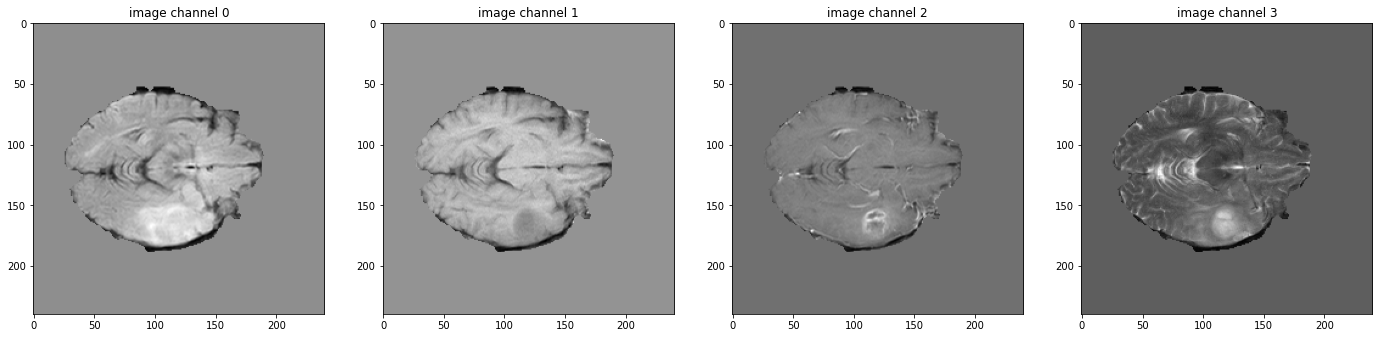

label shape: torch.Size([3, 240, 240, 155])


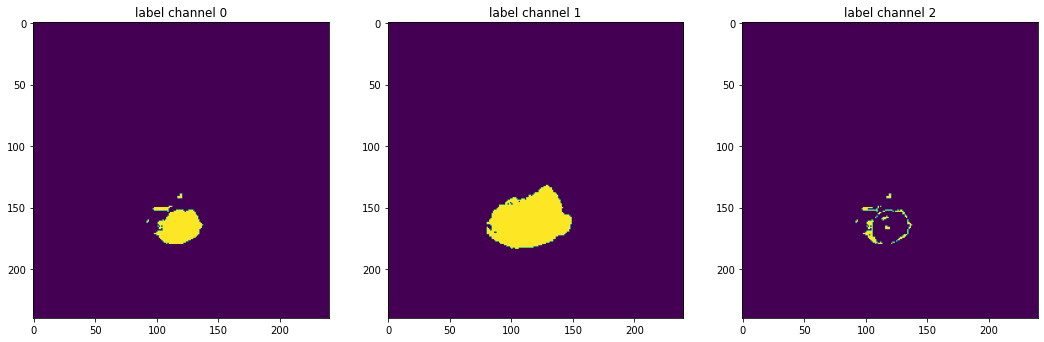

In [7]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
print(f"image shape: {val_ds[2]['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_ds[2]["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_ds[2]['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_ds[2]["label"][i, :, :, 60].detach().cpu())
plt.show()

## Create Model, Loss, Optimizer

In [8]:
max_epochs = 300
val_interval = 1

# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose(
    [EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold_values=True)]
)

# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

## Execute a typical PyTorch training process

In [ ]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():

            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = sliding_window_inference(
                    inputs=val_inputs, roi_size=(240, 240, 160), sw_batch_size=1, predictor=model, overlap=0.5
                )
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/300
1/388, train_loss: 0.9785, step time: 16.5686
2/388, train_loss: 0.9814, step time: 0.4695
3/388, train_loss: 0.9888, step time: 0.4694
4/388, train_loss: 0.9578, step time: 0.4705
5/388, train_loss: 0.9840, step time: 0.4716
6/388, train_loss: 0.9398, step time: 0.4722
7/388, train_loss: 0.9725, step time: 0.4717
8/388, train_loss: 0.9405, step time: 0.4698
9/388, train_loss: 0.9852, step time: 0.4682
10/388, train_loss: 0.9434, step time: 0.4713
11/388, train_loss: 0.8947, step time: 0.4677
12/388, train_loss: 0.8908, step time: 0.4718
13/388, train_loss: 0.9646, step time: 0.4725
14/388, train_loss: 0.9018, step time: 0.4728
15/388, train_loss: 0.9303, step time: 0.4725
16/388, train_loss: 0.9549, step time: 0.4697
17/388, train_loss: 0.9709, step time: 0.4690
18/388, train_loss: 0.9358, step time: 0.4680
19/388, train_loss: 0.9586, step time: 0.4703
20/388, train_loss: 0.8867, step time: 0.4716
21/388, train_loss: 0.9415, step time: 0.4772
22/388, train_loss:

178/388, train_loss: 0.9382, step time: 0.4732
179/388, train_loss: 0.9766, step time: 0.4724
180/388, train_loss: 0.9662, step time: 0.4698
181/388, train_loss: 0.9841, step time: 0.4711
182/388, train_loss: 0.8751, step time: 0.4717
183/388, train_loss: 0.9415, step time: 0.4699
184/388, train_loss: 0.9068, step time: 0.4701
185/388, train_loss: 0.9871, step time: 0.4719
186/388, train_loss: 0.9636, step time: 0.4709
187/388, train_loss: 0.8016, step time: 0.4725
188/388, train_loss: 0.9715, step time: 0.4687
189/388, train_loss: 0.9800, step time: 0.4727
190/388, train_loss: 0.9231, step time: 0.4720
191/388, train_loss: 0.9332, step time: 0.4716
192/388, train_loss: 0.9841, step time: 0.4733
193/388, train_loss: 0.9538, step time: 0.4706
194/388, train_loss: 0.9520, step time: 0.4708
195/388, train_loss: 0.8938, step time: 0.4698
196/388, train_loss: 0.9374, step time: 0.4682
197/388, train_loss: 0.8740, step time: 0.4688
198/388, train_loss: 0.9084, step time: 0.4698
199/388, trai

353/388, train_loss: 0.9311, step time: 0.4693
354/388, train_loss: 0.8958, step time: 0.4711
355/388, train_loss: 0.8157, step time: 0.4803
356/388, train_loss: 0.9693, step time: 0.4726
357/388, train_loss: 0.8517, step time: 0.4720
358/388, train_loss: 0.8995, step time: 0.4717
359/388, train_loss: 0.8473, step time: 0.4716
360/388, train_loss: 0.8423, step time: 0.4733
361/388, train_loss: 0.8731, step time: 0.4765
362/388, train_loss: 0.9218, step time: 0.4710
363/388, train_loss: 0.9152, step time: 0.4702
364/388, train_loss: 0.8817, step time: 0.4705
365/388, train_loss: 0.8435, step time: 0.4719
366/388, train_loss: 0.8959, step time: 0.4710
367/388, train_loss: 0.9407, step time: 0.4717
368/388, train_loss: 0.8880, step time: 0.4684
369/388, train_loss: 0.9850, step time: 0.4745
370/388, train_loss: 0.8319, step time: 0.4732
371/388, train_loss: 0.9708, step time: 0.4820
372/388, train_loss: 0.9523, step time: 0.4753
373/388, train_loss: 0.8892, step time: 0.4798
374/388, trai

137/388, train_loss: 0.9437, step time: 0.4753
138/388, train_loss: 0.9363, step time: 0.4736
139/388, train_loss: 0.9211, step time: 0.4701
140/388, train_loss: 0.9173, step time: 0.4742
141/388, train_loss: 0.7605, step time: 0.4753
142/388, train_loss: 0.9313, step time: 0.4788
143/388, train_loss: 0.9828, step time: 0.4730
144/388, train_loss: 0.8692, step time: 0.4737
145/388, train_loss: 0.9144, step time: 0.4710
146/388, train_loss: 0.7670, step time: 0.4921
147/388, train_loss: 0.8449, step time: 0.4914
148/388, train_loss: 0.8968, step time: 0.5095
149/388, train_loss: 0.9627, step time: 0.5014
150/388, train_loss: 0.9584, step time: 0.4855
151/388, train_loss: 0.8923, step time: 0.4878
152/388, train_loss: 0.8402, step time: 0.4805
153/388, train_loss: 0.9882, step time: 0.9077
154/388, train_loss: 0.9203, step time: 0.5282
155/388, train_loss: 0.9871, step time: 0.5003
156/388, train_loss: 0.9040, step time: 0.4949
157/388, train_loss: 0.9822, step time: 0.4837
158/388, trai

312/388, train_loss: 0.7459, step time: 0.4783
313/388, train_loss: 0.8728, step time: 0.9291
314/388, train_loss: 0.8397, step time: 0.5456
315/388, train_loss: 0.9520, step time: 0.5146
316/388, train_loss: 0.8157, step time: 0.4983
317/388, train_loss: 0.9547, step time: 0.4828
318/388, train_loss: 0.9158, step time: 0.4880
319/388, train_loss: 0.9411, step time: 0.4913
320/388, train_loss: 0.7223, step time: 0.8701
321/388, train_loss: 0.8759, step time: 0.5421
322/388, train_loss: 0.9295, step time: 0.5109
323/388, train_loss: 0.8214, step time: 0.4928
324/388, train_loss: 0.8531, step time: 0.5495
325/388, train_loss: 0.7397, step time: 0.5279
326/388, train_loss: 0.9218, step time: 0.5045
327/388, train_loss: 0.9518, step time: 0.5103
328/388, train_loss: 0.9629, step time: 0.4852
329/388, train_loss: 0.8271, step time: 0.4862
330/388, train_loss: 0.9789, step time: 0.9721
331/388, train_loss: 0.9128, step time: 0.5276
332/388, train_loss: 0.6410, step time: 0.5068
333/388, trai

96/388, train_loss: 0.7386, step time: 0.5004
97/388, train_loss: 0.7469, step time: 0.5011
98/388, train_loss: 0.9132, step time: 0.4837
99/388, train_loss: 0.7620, step time: 1.0359
100/388, train_loss: 0.8052, step time: 0.5410
101/388, train_loss: 0.7891, step time: 0.5075
102/388, train_loss: 0.8534, step time: 0.4976
103/388, train_loss: 0.7563, step time: 0.4989
104/388, train_loss: 0.6630, step time: 0.5016
105/388, train_loss: 0.7081, step time: 0.5131
106/388, train_loss: 0.7810, step time: 0.5012
107/388, train_loss: 0.8375, step time: 0.4993
108/388, train_loss: 0.8075, step time: 0.4892
109/388, train_loss: 0.6484, step time: 0.5381
110/388, train_loss: 0.9849, step time: 0.5184
111/388, train_loss: 0.9784, step time: 0.4939
112/388, train_loss: 0.7709, step time: 0.4941
113/388, train_loss: 0.9465, step time: 0.4864
114/388, train_loss: 0.8808, step time: 0.7968
115/388, train_loss: 0.8922, step time: 0.5483
116/388, train_loss: 0.8511, step time: 0.5199
117/388, train_lo

271/388, train_loss: 0.6899, step time: 0.5028
272/388, train_loss: 0.8879, step time: 0.4942
273/388, train_loss: 0.9152, step time: 0.4965
274/388, train_loss: 0.7558, step time: 0.4836
275/388, train_loss: 0.6629, step time: 0.4915
276/388, train_loss: 0.9150, step time: 0.4898
277/388, train_loss: 0.8356, step time: 1.1975
278/388, train_loss: 0.8054, step time: 0.5428
279/388, train_loss: 0.8535, step time: 0.5100
280/388, train_loss: 0.7478, step time: 0.4940
281/388, train_loss: 0.8829, step time: 0.4998
282/388, train_loss: 0.6064, step time: 0.5099
283/388, train_loss: 0.7425, step time: 0.5006
284/388, train_loss: 0.6771, step time: 0.4866
285/388, train_loss: 0.5852, step time: 0.4918
286/388, train_loss: 0.8509, step time: 1.1668
287/388, train_loss: 0.9346, step time: 0.5257
288/388, train_loss: 0.6564, step time: 0.4975
289/388, train_loss: 0.9021, step time: 0.4934
290/388, train_loss: 0.5174, step time: 0.4810
291/388, train_loss: 0.8575, step time: 0.4902
292/388, trai

54/388, train_loss: 0.8162, step time: 0.5364
55/388, train_loss: 0.8909, step time: 0.5528
56/388, train_loss: 0.8992, step time: 0.6518
57/388, train_loss: 0.6988, step time: 0.5308
58/388, train_loss: 0.8532, step time: 0.5024
59/388, train_loss: 0.8011, step time: 0.5264
60/388, train_loss: 0.9144, step time: 0.6224
61/388, train_loss: 0.9606, step time: 0.5555
62/388, train_loss: 0.7695, step time: 0.5362
63/388, train_loss: 0.8115, step time: 0.5311
64/388, train_loss: 0.5665, step time: 0.5167
65/388, train_loss: 0.4196, step time: 0.5478
66/388, train_loss: 0.5573, step time: 0.5391
67/388, train_loss: 0.9241, step time: 0.6384
68/388, train_loss: 0.6139, step time: 0.5588
69/388, train_loss: 0.8910, step time: 0.5199
70/388, train_loss: 0.6904, step time: 0.4932
71/388, train_loss: 0.7129, step time: 1.1642
72/388, train_loss: 0.5417, step time: 0.5354
73/388, train_loss: 0.5998, step time: 0.5008
74/388, train_loss: 0.7665, step time: 0.4940
75/388, train_loss: 0.5879, step t

230/388, train_loss: 0.5986, step time: 0.4893
231/388, train_loss: 0.3263, step time: 0.4910
232/388, train_loss: 0.4347, step time: 0.4834
233/388, train_loss: 0.8448, step time: 0.4914
234/388, train_loss: 0.6220, step time: 0.5069
235/388, train_loss: 0.5913, step time: 0.4831
236/388, train_loss: 0.9413, step time: 0.4845
237/388, train_loss: 0.7110, step time: 1.1940
238/388, train_loss: 0.6222, step time: 0.5332
239/388, train_loss: 0.3578, step time: 0.5026
240/388, train_loss: 0.8939, step time: 0.4960
241/388, train_loss: 0.6604, step time: 0.4844
242/388, train_loss: 0.4940, step time: 0.4773
243/388, train_loss: 0.3954, step time: 0.4788
244/388, train_loss: 0.5196, step time: 0.4863
245/388, train_loss: 0.7862, step time: 0.4892
246/388, train_loss: 0.6588, step time: 1.1276
247/388, train_loss: 0.6727, step time: 0.5451
248/388, train_loss: 0.6676, step time: 0.5037
249/388, train_loss: 0.6121, step time: 0.4988
250/388, train_loss: 0.7620, step time: 0.4952
251/388, trai

12/388, train_loss: 0.5124, step time: 0.6556
13/388, train_loss: 0.7426, step time: 0.5621
14/388, train_loss: 0.3781, step time: 0.5176
15/388, train_loss: 0.5728, step time: 0.5254
16/388, train_loss: 0.5231, step time: 0.5210
17/388, train_loss: 0.6895, step time: 0.5030
18/388, train_loss: 0.7416, step time: 0.5091
19/388, train_loss: 0.4928, step time: 0.5510
20/388, train_loss: 0.5138, step time: 0.5179
21/388, train_loss: 0.5434, step time: 0.5137
22/388, train_loss: 0.4883, step time: 0.4985
23/388, train_loss: 0.5279, step time: 0.9236
24/388, train_loss: 0.6186, step time: 0.5562
25/388, train_loss: 0.4399, step time: 0.5255
26/388, train_loss: 0.4740, step time: 0.5035
27/388, train_loss: 0.5457, step time: 0.5358
28/388, train_loss: 0.3447, step time: 0.5161
29/388, train_loss: 0.6313, step time: 0.5196
30/388, train_loss: 0.6502, step time: 0.4876
31/388, train_loss: 0.5144, step time: 1.0685
32/388, train_loss: 0.4734, step time: 0.5307
33/388, train_loss: 0.9548, step t

189/388, train_loss: 0.5247, step time: 0.4950
190/388, train_loss: 0.5045, step time: 0.5148
191/388, train_loss: 0.3842, step time: 0.5014
192/388, train_loss: 0.5462, step time: 1.0344
193/388, train_loss: 0.4745, step time: 0.5482
194/388, train_loss: 0.4112, step time: 0.5124
195/388, train_loss: 0.5285, step time: 0.4891
196/388, train_loss: 0.2183, step time: 1.1567
197/388, train_loss: 0.3310, step time: 0.5499
198/388, train_loss: 0.3772, step time: 0.5022
199/388, train_loss: 0.8505, step time: 0.4915
200/388, train_loss: 0.6905, step time: 0.4826
201/388, train_loss: 0.6252, step time: 0.5039
202/388, train_loss: 0.3789, step time: 0.4932
203/388, train_loss: 0.4587, step time: 0.5299
204/388, train_loss: 0.4168, step time: 0.5143
205/388, train_loss: 0.4139, step time: 0.4924
206/388, train_loss: 0.4805, step time: 0.5018
207/388, train_loss: 0.3379, step time: 0.5123
208/388, train_loss: 0.4845, step time: 0.4869
209/388, train_loss: 0.5294, step time: 0.4881
210/388, trai

364/388, train_loss: 0.1679, step time: 0.4980
365/388, train_loss: 0.9272, step time: 0.4840
366/388, train_loss: 0.7830, step time: 0.4888
367/388, train_loss: 0.4192, step time: 1.0860
368/388, train_loss: 0.9032, step time: 0.5329
369/388, train_loss: 0.6294, step time: 0.5004
370/388, train_loss: 0.6462, step time: 0.4812
371/388, train_loss: 0.4810, step time: 0.4768
372/388, train_loss: 0.3724, step time: 0.4811
373/388, train_loss: 0.5853, step time: 0.4963
374/388, train_loss: 0.7309, step time: 0.4952
375/388, train_loss: 0.3474, step time: 0.8592
376/388, train_loss: 0.5613, step time: 0.5534
377/388, train_loss: 0.4984, step time: 0.5155
378/388, train_loss: 0.5729, step time: 0.4862
379/388, train_loss: 0.5651, step time: 0.4921
380/388, train_loss: 0.8115, step time: 0.4866
381/388, train_loss: 0.4984, step time: 0.4939
382/388, train_loss: 0.2945, step time: 0.5217
383/388, train_loss: 0.3215, step time: 0.4966
384/388, train_loss: 0.2966, step time: 0.4840
385/388, trai

149/388, train_loss: 0.1679, step time: 0.4866
150/388, train_loss: 0.2303, step time: 1.1471
151/388, train_loss: 0.5284, step time: 0.5193
152/388, train_loss: 0.3235, step time: 0.5057
153/388, train_loss: 0.3813, step time: 0.4921
154/388, train_loss: 0.2384, step time: 0.4793
155/388, train_loss: 0.3732, step time: 1.1721
156/388, train_loss: 0.3925, step time: 0.5383
157/388, train_loss: 0.3879, step time: 0.5090
158/388, train_loss: 0.3625, step time: 0.4905
159/388, train_loss: 0.5527, step time: 0.4912
160/388, train_loss: 0.6568, step time: 1.1882
161/388, train_loss: 0.3302, step time: 0.5313
162/388, train_loss: 0.1807, step time: 0.5032
163/388, train_loss: 0.4805, step time: 0.4829
164/388, train_loss: 0.3326, step time: 0.4927
165/388, train_loss: 0.3340, step time: 0.4833
166/388, train_loss: 0.8123, step time: 0.4789
167/388, train_loss: 0.4880, step time: 0.4841
168/388, train_loss: 0.5113, step time: 0.4745
169/388, train_loss: 0.6836, step time: 1.0722
170/388, trai

324/388, train_loss: 0.2223, step time: 0.5065
325/388, train_loss: 0.3750, step time: 0.5002
326/388, train_loss: 0.1690, step time: 0.4903
327/388, train_loss: 0.5482, step time: 0.5511
328/388, train_loss: 0.2982, step time: 0.5481
329/388, train_loss: 0.3934, step time: 0.5095
330/388, train_loss: 0.3739, step time: 0.4984
331/388, train_loss: 0.4237, step time: 0.4820
332/388, train_loss: 0.2928, step time: 0.5070
333/388, train_loss: 0.4546, step time: 0.5009
334/388, train_loss: 0.3191, step time: 0.7162
335/388, train_loss: 0.2636, step time: 0.5708
336/388, train_loss: 0.5564, step time: 0.5228
337/388, train_loss: 0.3896, step time: 0.4974
338/388, train_loss: 0.2597, step time: 0.5073
339/388, train_loss: 0.3724, step time: 0.5427
340/388, train_loss: 0.4303, step time: 0.5234
341/388, train_loss: 0.4801, step time: 0.5057
342/388, train_loss: 0.2909, step time: 0.5083
343/388, train_loss: 0.2483, step time: 0.5052
344/388, train_loss: 0.4774, step time: 0.4934
345/388, trai

108/388, train_loss: 0.3704, step time: 0.5074
109/388, train_loss: 0.3169, step time: 0.4990
110/388, train_loss: 0.1790, step time: 0.4936
111/388, train_loss: 0.2475, step time: 0.4826
112/388, train_loss: 0.3137, step time: 0.4848
113/388, train_loss: 0.2426, step time: 0.4806
114/388, train_loss: 0.7683, step time: 0.8174
115/388, train_loss: 0.1941, step time: 0.5641
116/388, train_loss: 0.2857, step time: 0.5315
117/388, train_loss: 0.3813, step time: 0.5048
118/388, train_loss: 0.2772, step time: 0.5040
119/388, train_loss: 0.2917, step time: 0.4938
120/388, train_loss: 0.2456, step time: 0.4963
121/388, train_loss: 0.8327, step time: 0.4916
122/388, train_loss: 0.2329, step time: 0.5249
123/388, train_loss: 0.4722, step time: 0.5032
124/388, train_loss: 0.4389, step time: 0.5005
125/388, train_loss: 0.5619, step time: 0.4848
126/388, train_loss: 0.2432, step time: 0.4994
127/388, train_loss: 0.3157, step time: 0.4826
128/388, train_loss: 0.2556, step time: 0.4785
129/388, trai

283/388, train_loss: 0.2590, step time: 0.4979
284/388, train_loss: 0.4256, step time: 0.4957
285/388, train_loss: 0.3825, step time: 1.1477
286/388, train_loss: 0.2914, step time: 0.5425
287/388, train_loss: 0.2780, step time: 0.5104
288/388, train_loss: 0.1957, step time: 0.4980
289/388, train_loss: 0.3896, step time: 0.4901
290/388, train_loss: 0.5968, step time: 0.4897
291/388, train_loss: 0.7216, step time: 0.4906
292/388, train_loss: 0.5163, step time: 1.1494
293/388, train_loss: 0.2678, step time: 0.5292
294/388, train_loss: 0.6283, step time: 0.5147
295/388, train_loss: 0.2071, step time: 0.4912
296/388, train_loss: 0.4704, step time: 0.4850
297/388, train_loss: 0.6420, step time: 0.4893
298/388, train_loss: 0.1747, step time: 0.7303
299/388, train_loss: 0.2859, step time: 0.5507
300/388, train_loss: 0.4435, step time: 0.5093
301/388, train_loss: 0.3913, step time: 0.4966
302/388, train_loss: 0.4910, step time: 0.4888
303/388, train_loss: 0.4841, step time: 0.4857
304/388, trai

66/388, train_loss: 0.1311, step time: 0.4949
67/388, train_loss: 0.2379, step time: 0.4813
68/388, train_loss: 0.3724, step time: 0.4925
69/388, train_loss: 0.3018, step time: 1.1691
70/388, train_loss: 0.2974, step time: 0.5477
71/388, train_loss: 0.2769, step time: 0.5190
72/388, train_loss: 0.2309, step time: 0.4966
73/388, train_loss: 0.2562, step time: 0.4979
74/388, train_loss: 0.1964, step time: 0.4821
75/388, train_loss: 0.3202, step time: 0.4907
76/388, train_loss: 0.3837, step time: 0.4794
77/388, train_loss: 0.6889, step time: 1.1236
78/388, train_loss: 0.2640, step time: 0.5254
79/388, train_loss: 0.5904, step time: 0.5070
80/388, train_loss: 0.2701, step time: 0.4913
81/388, train_loss: 0.2960, step time: 0.4939
82/388, train_loss: 0.2769, step time: 0.4788
83/388, train_loss: 0.5853, step time: 0.4854
84/388, train_loss: 0.6653, step time: 0.5074
85/388, train_loss: 0.3598, step time: 0.4879
86/388, train_loss: 0.3424, step time: 0.4923
87/388, train_loss: 0.2942, step t

242/388, train_loss: 0.2736, step time: 0.5080
243/388, train_loss: 0.2139, step time: 0.4994
244/388, train_loss: 0.2040, step time: 0.4870
245/388, train_loss: 0.2821, step time: 0.5238
246/388, train_loss: 0.2163, step time: 0.5099
247/388, train_loss: 0.2080, step time: 0.5045
248/388, train_loss: 0.2223, step time: 0.4923
249/388, train_loss: 0.2094, step time: 0.5158
250/388, train_loss: 0.6888, step time: 0.4968
251/388, train_loss: 0.1700, step time: 0.4972
252/388, train_loss: 0.3538, step time: 0.4897
253/388, train_loss: 0.1642, step time: 1.1379
254/388, train_loss: 0.2077, step time: 0.5413
255/388, train_loss: 0.3870, step time: 0.5148
256/388, train_loss: 0.1808, step time: 0.4925
257/388, train_loss: 0.1503, step time: 0.6244
258/388, train_loss: 0.2899, step time: 0.5493
259/388, train_loss: 0.1692, step time: 0.4977
260/388, train_loss: 0.5753, step time: 0.4892
261/388, train_loss: 0.4616, step time: 0.4906
262/388, train_loss: 0.5027, step time: 0.4816
263/388, trai

25/388, train_loss: 0.3046, step time: 0.5217
26/388, train_loss: 0.1622, step time: 0.4986
27/388, train_loss: 0.2298, step time: 0.9913
28/388, train_loss: 0.2769, step time: 0.5517
29/388, train_loss: 0.4890, step time: 0.5318
30/388, train_loss: 0.2538, step time: 0.4996
31/388, train_loss: 0.6151, step time: 0.4993
32/388, train_loss: 0.4937, step time: 0.4832
33/388, train_loss: 0.2184, step time: 0.5015
34/388, train_loss: 0.3508, step time: 0.5402
35/388, train_loss: 0.1508, step time: 0.5827
36/388, train_loss: 0.4999, step time: 0.5287
37/388, train_loss: 0.2835, step time: 0.5028
38/388, train_loss: 0.6799, step time: 0.5685
39/388, train_loss: 0.2521, step time: 0.6227
40/388, train_loss: 0.3670, step time: 0.5394
41/388, train_loss: 0.5204, step time: 0.5081
42/388, train_loss: 0.3247, step time: 0.5768
43/388, train_loss: 0.2455, step time: 0.5759
44/388, train_loss: 0.3054, step time: 0.5319
45/388, train_loss: 0.2129, step time: 0.5117
46/388, train_loss: 0.4656, step t

201/388, train_loss: 0.3046, step time: 0.4878
202/388, train_loss: 0.2621, step time: 1.1342
203/388, train_loss: 0.3735, step time: 0.5312
204/388, train_loss: 0.2603, step time: 0.5110
205/388, train_loss: 0.2301, step time: 0.5022
206/388, train_loss: 0.3035, step time: 0.4959
207/388, train_loss: 0.2213, step time: 0.4795
208/388, train_loss: 0.2195, step time: 0.4855
209/388, train_loss: 0.2780, step time: 0.4798
210/388, train_loss: 0.1578, step time: 0.4816
211/388, train_loss: 0.3275, step time: 0.4913
212/388, train_loss: 0.2811, step time: 0.4946
213/388, train_loss: 0.2290, step time: 0.5571
214/388, train_loss: 0.2592, step time: 0.5316
215/388, train_loss: 0.1905, step time: 0.4928
216/388, train_loss: 0.5256, step time: 0.4937
217/388, train_loss: 0.1840, step time: 0.4795
218/388, train_loss: 0.2464, step time: 0.4871
219/388, train_loss: 0.2205, step time: 0.5945
220/388, train_loss: 0.3410, step time: 0.5622
221/388, train_loss: 0.4940, step time: 0.5247
222/388, trai

376/388, train_loss: 0.1274, step time: 0.4902
377/388, train_loss: 0.2116, step time: 0.4794
378/388, train_loss: 0.2906, step time: 0.4894
379/388, train_loss: 0.1987, step time: 0.4811
380/388, train_loss: 0.4402, step time: 0.5017
381/388, train_loss: 0.2553, step time: 0.4944
382/388, train_loss: 0.2004, step time: 0.4808
383/388, train_loss: 0.1739, step time: 0.4975
384/388, train_loss: 0.3048, step time: 0.4782
385/388, train_loss: 0.2449, step time: 0.5487
386/388, train_loss: 0.3106, step time: 0.5255
387/388, train_loss: 0.2411, step time: 0.4927
388/388, train_loss: 0.3361, step time: 0.4908
epoch 9 average loss: 0.2993
current epoch: 9 current mean dice: 0.6630 tc: 0.7339 wt: 0.8520 et: 0.4031
best mean dice: 0.6708 at epoch: 8
time consuming of epoch 9 is: 300.4522
----------
epoch 10/300
1/388, train_loss: 0.6214, step time: 0.4788
2/388, train_loss: 0.4422, step time: 0.4958
3/388, train_loss: 0.1457, step time: 1.1119
4/388, train_loss: 0.2380, step time: 0.5566
5/388,

161/388, train_loss: 0.1691, step time: 0.5359
162/388, train_loss: 0.2134, step time: 0.5057
163/388, train_loss: 0.5337, step time: 0.4952
164/388, train_loss: 0.1733, step time: 0.4885
165/388, train_loss: 0.0978, step time: 0.5453
166/388, train_loss: 0.1691, step time: 0.5311
167/388, train_loss: 0.2414, step time: 0.5028
168/388, train_loss: 0.4251, step time: 0.5081
169/388, train_loss: 0.3685, step time: 0.4885
170/388, train_loss: 0.2065, step time: 0.4848
171/388, train_loss: 0.1970, step time: 0.5120
172/388, train_loss: 0.3783, step time: 0.4962
173/388, train_loss: 0.1584, step time: 0.4944
174/388, train_loss: 0.1051, step time: 0.4813
175/388, train_loss: 0.1193, step time: 0.5216
176/388, train_loss: 0.3167, step time: 0.4980
177/388, train_loss: 0.2751, step time: 0.5025
178/388, train_loss: 0.3564, step time: 0.5278
179/388, train_loss: 0.4749, step time: 0.5131
180/388, train_loss: 0.2356, step time: 0.4990
181/388, train_loss: 0.1704, step time: 0.4906
182/388, trai

336/388, train_loss: 0.1597, step time: 0.4967
337/388, train_loss: 0.4002, step time: 0.4796
338/388, train_loss: 0.2957, step time: 0.4937
339/388, train_loss: 0.3820, step time: 0.5630
340/388, train_loss: 0.2713, step time: 0.5396
341/388, train_loss: 0.2668, step time: 0.5030
342/388, train_loss: 0.2734, step time: 0.5002
343/388, train_loss: 0.1362, step time: 0.4895
344/388, train_loss: 0.2153, step time: 0.4950
345/388, train_loss: 0.1614, step time: 1.1166
346/388, train_loss: 0.1985, step time: 0.5262
347/388, train_loss: 0.3208, step time: 0.4999
348/388, train_loss: 0.1904, step time: 0.4870
349/388, train_loss: 0.1529, step time: 0.5043
350/388, train_loss: 0.5924, step time: 0.6187
351/388, train_loss: 0.1407, step time: 0.5482
352/388, train_loss: 0.2623, step time: 0.5175
353/388, train_loss: 0.2285, step time: 0.5065
354/388, train_loss: 0.2342, step time: 0.4898
355/388, train_loss: 0.4360, step time: 0.5038
356/388, train_loss: 0.1667, step time: 0.5713
357/388, trai

120/388, train_loss: 0.1473, step time: 0.5185
121/388, train_loss: 0.3914, step time: 0.4945
122/388, train_loss: 0.2841, step time: 0.4957
123/388, train_loss: 0.3650, step time: 0.4789
124/388, train_loss: 0.2445, step time: 0.8928
125/388, train_loss: 0.1447, step time: 0.5363
126/388, train_loss: 0.2910, step time: 0.5114
127/388, train_loss: 0.1500, step time: 0.5044
128/388, train_loss: 0.6357, step time: 0.4916
129/388, train_loss: 0.1884, step time: 0.4857
130/388, train_loss: 0.3896, step time: 0.4945
131/388, train_loss: 0.3048, step time: 0.4789
132/388, train_loss: 0.4715, step time: 0.4851
133/388, train_loss: 0.3693, step time: 1.1217
134/388, train_loss: 0.2257, step time: 0.5368
135/388, train_loss: 0.4844, step time: 0.5032
136/388, train_loss: 0.4907, step time: 0.4903
137/388, train_loss: 0.2234, step time: 0.4889
138/388, train_loss: 0.2529, step time: 0.4988
139/388, train_loss: 0.2729, step time: 0.4998
140/388, train_loss: 0.2982, step time: 0.5189
141/388, trai

295/388, train_loss: 0.1955, step time: 0.4916
296/388, train_loss: 0.1595, step time: 0.4782
297/388, train_loss: 0.3743, step time: 0.4785
298/388, train_loss: 0.0885, step time: 0.5061
299/388, train_loss: 0.3550, step time: 0.5194
300/388, train_loss: 0.4822, step time: 0.5317
301/388, train_loss: 0.3876, step time: 0.5408
302/388, train_loss: 0.0868, step time: 0.5232
303/388, train_loss: 0.3607, step time: 0.5670
304/388, train_loss: 0.2011, step time: 0.5257
305/388, train_loss: 0.1714, step time: 0.5033
306/388, train_loss: 0.1756, step time: 0.4981
307/388, train_loss: 0.5180, step time: 0.4851
308/388, train_loss: 0.3034, step time: 0.4918
309/388, train_loss: 0.2794, step time: 0.4861
310/388, train_loss: 0.2534, step time: 0.4853
311/388, train_loss: 0.3683, step time: 1.1918
312/388, train_loss: 0.1640, step time: 0.5426
313/388, train_loss: 0.1715, step time: 0.5187
314/388, train_loss: 0.1016, step time: 0.4985
315/388, train_loss: 0.5008, step time: 0.4960
316/388, trai

79/388, train_loss: 0.1044, step time: 0.4938
80/388, train_loss: 0.4156, step time: 0.4840
81/388, train_loss: 0.4849, step time: 0.9607
82/388, train_loss: 0.1712, step time: 0.5711
83/388, train_loss: 0.2956, step time: 0.5277
84/388, train_loss: 0.3149, step time: 0.5254
85/388, train_loss: 0.3515, step time: 0.5046
86/388, train_loss: 0.4373, step time: 0.5073
87/388, train_loss: 0.6011, step time: 0.5857
88/388, train_loss: 0.1854, step time: 0.5417
89/388, train_loss: 0.0862, step time: 0.5160
90/388, train_loss: 0.4225, step time: 0.5070
91/388, train_loss: 0.4356, step time: 0.4985
92/388, train_loss: 0.1921, step time: 0.5161
93/388, train_loss: 0.1472, step time: 0.5011
94/388, train_loss: 0.3867, step time: 0.4958
95/388, train_loss: 0.3084, step time: 0.4907
96/388, train_loss: 0.2271, step time: 0.4777
97/388, train_loss: 0.7423, step time: 0.5017
98/388, train_loss: 0.2485, step time: 0.4834
99/388, train_loss: 0.1462, step time: 0.4998
100/388, train_loss: 0.6902, step 

254/388, train_loss: 0.2500, step time: 0.4904
255/388, train_loss: 0.1595, step time: 0.4998
256/388, train_loss: 0.1816, step time: 0.4967
257/388, train_loss: 0.1695, step time: 0.4950
258/388, train_loss: 0.2085, step time: 0.5149
259/388, train_loss: 0.1204, step time: 0.5351
260/388, train_loss: 0.1637, step time: 0.5324
261/388, train_loss: 0.4154, step time: 0.5490
262/388, train_loss: 0.2122, step time: 0.5220
263/388, train_loss: 0.1571, step time: 0.4995
264/388, train_loss: 0.2055, step time: 0.5018
265/388, train_loss: 0.3093, step time: 0.4848
266/388, train_loss: 0.5355, step time: 1.0611
267/388, train_loss: 0.2194, step time: 0.5256
268/388, train_loss: 0.1763, step time: 0.5055
269/388, train_loss: 0.5753, step time: 0.4872
270/388, train_loss: 0.2066, step time: 0.4816
271/388, train_loss: 0.5853, step time: 0.4861
272/388, train_loss: 0.5126, step time: 0.5039
273/388, train_loss: 0.2409, step time: 0.4936
274/388, train_loss: 0.2533, step time: 0.4847
275/388, trai

37/388, train_loss: 0.1700, step time: 0.4986
38/388, train_loss: 0.0434, step time: 0.5830
39/388, train_loss: 0.1071, step time: 0.5711
40/388, train_loss: 0.2736, step time: 0.5410
41/388, train_loss: 0.1304, step time: 0.5116
42/388, train_loss: 0.1804, step time: 0.5105
43/388, train_loss: 0.0922, step time: 0.5780
44/388, train_loss: 0.2313, step time: 0.6082
45/388, train_loss: 0.5095, step time: 0.5435
46/388, train_loss: 0.1562, step time: 0.5117
47/388, train_loss: 0.3059, step time: 0.5043
48/388, train_loss: 0.1280, step time: 0.4847
49/388, train_loss: 0.1078, step time: 0.4842
50/388, train_loss: 0.1791, step time: 0.5053
51/388, train_loss: 0.1954, step time: 0.5190
52/388, train_loss: 0.2299, step time: 0.5891
53/388, train_loss: 0.2471, step time: 0.5413
54/388, train_loss: 0.1055, step time: 0.5001
55/388, train_loss: 0.3308, step time: 0.5867
56/388, train_loss: 0.1576, step time: 0.5817
57/388, train_loss: 0.1251, step time: 0.5414
58/388, train_loss: 0.1223, step t

213/388, train_loss: 0.1949, step time: 0.5144
214/388, train_loss: 0.1532, step time: 0.5038
215/388, train_loss: 0.2269, step time: 0.5021
216/388, train_loss: 0.2387, step time: 0.4913
217/388, train_loss: 0.1026, step time: 0.5309
218/388, train_loss: 0.2144, step time: 0.5199
219/388, train_loss: 0.3314, step time: 0.5142
220/388, train_loss: 0.4143, step time: 0.4949
221/388, train_loss: 0.5363, step time: 0.5102
222/388, train_loss: 0.5419, step time: 0.4950
223/388, train_loss: 0.1030, step time: 0.4951
224/388, train_loss: 0.2163, step time: 0.4795
225/388, train_loss: 0.6655, step time: 0.6653
226/388, train_loss: 0.1843, step time: 0.5502
227/388, train_loss: 0.6913, step time: 0.5368
228/388, train_loss: 0.2135, step time: 0.5077
229/388, train_loss: 0.2448, step time: 0.4970
230/388, train_loss: 0.1434, step time: 0.5110
231/388, train_loss: 0.1272, step time: 0.4955
232/388, train_loss: 0.3194, step time: 0.4812
233/388, train_loss: 0.1502, step time: 0.5161
234/388, trai

388/388, train_loss: 0.1479, step time: 0.4726
epoch 13 average loss: 0.2575
saved new best metric model
current epoch: 13 current mean dice: 0.7174 tc: 0.7734 wt: 0.8618 et: 0.5172
best mean dice: 0.7174 at epoch: 13
time consuming of epoch 13 is: 298.6160
----------
epoch 14/300
1/388, train_loss: 0.1646, step time: 0.4694
2/388, train_loss: 0.0828, step time: 0.4836
3/388, train_loss: 0.0949, step time: 0.4733
4/388, train_loss: 0.1728, step time: 1.0567
5/388, train_loss: 0.2127, step time: 0.5416
6/388, train_loss: 0.1033, step time: 0.5317
7/388, train_loss: 0.2113, step time: 0.5119
8/388, train_loss: 0.3239, step time: 0.5510
9/388, train_loss: 0.1963, step time: 0.5055
10/388, train_loss: 0.1899, step time: 0.5367
11/388, train_loss: 0.3159, step time: 0.6364
12/388, train_loss: 0.2275, step time: 0.5631
13/388, train_loss: 0.1674, step time: 0.5340
14/388, train_loss: 0.2721, step time: 0.5031
15/388, train_loss: 0.2176, step time: 0.5005
16/388, train_loss: 0.1968, step time

172/388, train_loss: 0.4476, step time: 0.5076
173/388, train_loss: 0.4499, step time: 0.4869
174/388, train_loss: 0.1346, step time: 1.0678
175/388, train_loss: 0.1089, step time: 0.5484
176/388, train_loss: 0.4124, step time: 0.5188
177/388, train_loss: 0.3974, step time: 0.5296
178/388, train_loss: 0.1109, step time: 0.5217
179/388, train_loss: 0.1259, step time: 0.5028
180/388, train_loss: 0.1559, step time: 0.4879
181/388, train_loss: 0.1151, step time: 0.4945
182/388, train_loss: 0.4046, step time: 0.4761
183/388, train_loss: 0.0953, step time: 0.4911
184/388, train_loss: 0.6555, step time: 0.5307
185/388, train_loss: 0.2636, step time: 0.5209
186/388, train_loss: 0.1403, step time: 0.5026
187/388, train_loss: 0.2486, step time: 0.4950
188/388, train_loss: 0.2277, step time: 0.7683
189/388, train_loss: 0.1549, step time: 0.5449
190/388, train_loss: 0.2020, step time: 0.5069
191/388, train_loss: 0.4915, step time: 0.4819
192/388, train_loss: 0.2140, step time: 0.6811
193/388, trai

347/388, train_loss: 0.3610, step time: 0.5290
348/388, train_loss: 0.1023, step time: 0.4936
349/388, train_loss: 0.2514, step time: 0.4960
350/388, train_loss: 0.3094, step time: 0.5131
351/388, train_loss: 0.3359, step time: 0.5010
352/388, train_loss: 0.2828, step time: 0.4819
353/388, train_loss: 0.1672, step time: 0.4762
354/388, train_loss: 0.1308, step time: 0.4769
355/388, train_loss: 0.1436, step time: 0.4930
356/388, train_loss: 0.3169, step time: 0.4959
357/388, train_loss: 0.5634, step time: 0.4834
358/388, train_loss: 0.1635, step time: 0.5003
359/388, train_loss: 0.1650, step time: 0.5061
360/388, train_loss: 0.1046, step time: 0.5362
361/388, train_loss: 0.5302, step time: 0.5201
362/388, train_loss: 0.3172, step time: 0.5108
363/388, train_loss: 0.2284, step time: 0.4986
364/388, train_loss: 0.4200, step time: 0.4921
365/388, train_loss: 0.0939, step time: 0.4978
366/388, train_loss: 0.2129, step time: 0.5436
367/388, train_loss: 0.3191, step time: 0.5314
368/388, trai

131/388, train_loss: 0.1584, step time: 0.4965
132/388, train_loss: 0.1360, step time: 0.4808
133/388, train_loss: 0.1340, step time: 0.4950
134/388, train_loss: 0.3989, step time: 0.4834
135/388, train_loss: 0.1304, step time: 0.4805
136/388, train_loss: 0.0499, step time: 0.4786
137/388, train_loss: 0.2335, step time: 0.4892
138/388, train_loss: 0.2615, step time: 0.5129
139/388, train_loss: 0.4350, step time: 0.4963
140/388, train_loss: 0.1512, step time: 0.4968
141/388, train_loss: 0.1053, step time: 0.4827
142/388, train_loss: 0.2405, step time: 0.4776
143/388, train_loss: 0.2392, step time: 0.4816
144/388, train_loss: 0.3302, step time: 0.4716
145/388, train_loss: 0.2671, step time: 0.4907
146/388, train_loss: 0.1889, step time: 0.4965
147/388, train_loss: 0.2423, step time: 1.0353
148/388, train_loss: 0.2656, step time: 0.5449
149/388, train_loss: 0.3714, step time: 0.5205
150/388, train_loss: 0.3041, step time: 0.4962
151/388, train_loss: 0.1018, step time: 0.4913
152/388, trai

306/388, train_loss: 0.1007, step time: 0.5306
307/388, train_loss: 0.2124, step time: 0.5065
308/388, train_loss: 0.2757, step time: 0.5086
309/388, train_loss: 0.1904, step time: 0.6107
310/388, train_loss: 0.1839, step time: 0.5465
311/388, train_loss: 0.2280, step time: 0.5172
312/388, train_loss: 0.3741, step time: 0.5058
313/388, train_loss: 0.1257, step time: 0.4916
314/388, train_loss: 0.5455, step time: 0.4894
315/388, train_loss: 0.2211, step time: 0.4832
316/388, train_loss: 0.1768, step time: 0.4842
317/388, train_loss: 0.4071, step time: 1.1361
318/388, train_loss: 0.1354, step time: 0.5361
319/388, train_loss: 0.0968, step time: 0.5138
320/388, train_loss: 0.1939, step time: 0.4988
321/388, train_loss: 0.3030, step time: 0.4934
322/388, train_loss: 0.3462, step time: 0.5024
323/388, train_loss: 0.4661, step time: 0.5032
324/388, train_loss: 0.3780, step time: 0.4868
325/388, train_loss: 0.2744, step time: 0.5087
326/388, train_loss: 0.2055, step time: 0.4991
327/388, trai

90/388, train_loss: 0.1761, step time: 0.4871
91/388, train_loss: 0.2934, step time: 0.4865
92/388, train_loss: 0.6210, step time: 0.4754
93/388, train_loss: 0.2033, step time: 0.4869
94/388, train_loss: 0.1028, step time: 0.5176
95/388, train_loss: 0.3752, step time: 0.5136
96/388, train_loss: 0.1156, step time: 0.4939
97/388, train_loss: 0.2455, step time: 0.4935
98/388, train_loss: 0.1461, step time: 0.4786
99/388, train_loss: 0.2932, step time: 0.9868
100/388, train_loss: 0.3296, step time: 0.5330
101/388, train_loss: 0.4986, step time: 0.5088
102/388, train_loss: 0.2370, step time: 0.4971
103/388, train_loss: 0.1784, step time: 0.4837
104/388, train_loss: 0.3557, step time: 0.4831
105/388, train_loss: 0.1956, step time: 0.4839
106/388, train_loss: 0.0786, step time: 0.4714
107/388, train_loss: 0.2226, step time: 0.4755
108/388, train_loss: 0.0944, step time: 0.4773
109/388, train_loss: 0.5941, step time: 0.5111
110/388, train_loss: 0.0950, step time: 0.5000
111/388, train_loss: 0.

265/388, train_loss: 0.1632, step time: 0.4861
266/388, train_loss: 0.1761, step time: 0.4859
267/388, train_loss: 0.2342, step time: 1.0992
268/388, train_loss: 0.0447, step time: 0.5485
269/388, train_loss: 0.2209, step time: 0.5229
270/388, train_loss: 0.1724, step time: 0.4989
271/388, train_loss: 0.1490, step time: 0.4978
272/388, train_loss: 0.4109, step time: 0.4804
273/388, train_loss: 0.5963, step time: 0.4781
274/388, train_loss: 0.2320, step time: 0.4891
275/388, train_loss: 0.2128, step time: 0.4987
276/388, train_loss: 0.6911, step time: 0.5217
277/388, train_loss: 0.1408, step time: 0.6031
278/388, train_loss: 0.3931, step time: 0.5521
279/388, train_loss: 0.3395, step time: 0.5301
280/388, train_loss: 0.2973, step time: 0.5116
281/388, train_loss: 0.1133, step time: 0.5016
282/388, train_loss: 0.3747, step time: 0.4980
283/388, train_loss: 0.6074, step time: 0.4799
284/388, train_loss: 0.4857, step time: 1.1774
285/388, train_loss: 0.1208, step time: 0.5412
286/388, trai

49/388, train_loss: 0.1978, step time: 0.4881
50/388, train_loss: 0.1645, step time: 0.4728
51/388, train_loss: 0.2129, step time: 1.0666
52/388, train_loss: 0.1114, step time: 0.5323
53/388, train_loss: 0.6730, step time: 0.5157
54/388, train_loss: 0.1438, step time: 0.4987
55/388, train_loss: 0.4309, step time: 0.4950
56/388, train_loss: 0.2098, step time: 0.9680
57/388, train_loss: 0.1210, step time: 0.5378
58/388, train_loss: 0.6838, step time: 0.5124
59/388, train_loss: 0.1706, step time: 0.4973
60/388, train_loss: 0.1188, step time: 0.4826
61/388, train_loss: 0.3334, step time: 0.4829
62/388, train_loss: 0.1954, step time: 0.4835
63/388, train_loss: 0.2697, step time: 0.4753
64/388, train_loss: 0.3157, step time: 0.5162
65/388, train_loss: 0.2143, step time: 0.5068
66/388, train_loss: 0.0822, step time: 0.4881
67/388, train_loss: 0.2888, step time: 0.4907
68/388, train_loss: 0.1706, step time: 0.5067
69/388, train_loss: 0.1425, step time: 0.5512
70/388, train_loss: 0.1147, step t

225/388, train_loss: 0.0523, step time: 0.4902
226/388, train_loss: 0.0721, step time: 0.4790
227/388, train_loss: 0.3538, step time: 0.4812
228/388, train_loss: 0.1367, step time: 0.4797
229/388, train_loss: 0.1745, step time: 0.4798
230/388, train_loss: 0.5019, step time: 0.8306
231/388, train_loss: 0.3386, step time: 0.5515
232/388, train_loss: 0.0636, step time: 0.5089
233/388, train_loss: 0.1786, step time: 0.4811
234/388, train_loss: 0.2140, step time: 0.4839
235/388, train_loss: 0.3634, step time: 0.4993
236/388, train_loss: 0.3017, step time: 0.5164
237/388, train_loss: 0.3669, step time: 0.4958
238/388, train_loss: 0.1951, step time: 0.5018
239/388, train_loss: 0.2007, step time: 0.4884
240/388, train_loss: 0.0742, step time: 0.5107
241/388, train_loss: 0.1356, step time: 0.4921
242/388, train_loss: 0.3609, step time: 0.4952
243/388, train_loss: 0.1796, step time: 0.4904
244/388, train_loss: 0.2849, step time: 0.5047
245/388, train_loss: 0.6380, step time: 0.4981
246/388, trai

8/388, train_loss: 0.2999, step time: 0.5070
9/388, train_loss: 0.2194, step time: 0.8630
10/388, train_loss: 0.4984, step time: 0.5965
11/388, train_loss: 0.2433, step time: 0.5712
12/388, train_loss: 0.0839, step time: 0.5396
13/388, train_loss: 0.3758, step time: 0.5075
14/388, train_loss: 0.1198, step time: 0.4898
15/388, train_loss: 0.1206, step time: 1.1169
16/388, train_loss: 0.5506, step time: 0.5393
17/388, train_loss: 0.2920, step time: 0.5173
18/388, train_loss: 0.2653, step time: 0.4978
19/388, train_loss: 0.6863, step time: 0.7251
20/388, train_loss: 0.2917, step time: 0.5753
21/388, train_loss: 0.1291, step time: 0.5258
22/388, train_loss: 0.1879, step time: 0.5508
23/388, train_loss: 0.3416, step time: 0.5114
24/388, train_loss: 0.2996, step time: 0.4879
25/388, train_loss: 0.2392, step time: 0.5176
26/388, train_loss: 0.2167, step time: 0.5109
27/388, train_loss: 0.1097, step time: 0.5719
28/388, train_loss: 0.1949, step time: 0.5455
29/388, train_loss: 0.1945, step tim

185/388, train_loss: 0.2431, step time: 0.4821
186/388, train_loss: 0.1190, step time: 0.5025
187/388, train_loss: 0.2179, step time: 0.4869
188/388, train_loss: 0.1867, step time: 0.4917
189/388, train_loss: 0.5175, step time: 0.5688
190/388, train_loss: 0.4972, step time: 0.5546
191/388, train_loss: 0.1247, step time: 0.5274
192/388, train_loss: 0.1778, step time: 0.5039
193/388, train_loss: 0.4188, step time: 0.4865
194/388, train_loss: 0.3815, step time: 0.5208
195/388, train_loss: 0.2326, step time: 0.4955
196/388, train_loss: 0.4555, step time: 0.4968
197/388, train_loss: 0.1856, step time: 0.5165
198/388, train_loss: 0.0715, step time: 0.4999
199/388, train_loss: 0.1197, step time: 0.4965
200/388, train_loss: 0.3290, step time: 0.4883
201/388, train_loss: 0.4412, step time: 0.4946
202/388, train_loss: 0.0979, step time: 0.4758
203/388, train_loss: 0.3431, step time: 0.4956
204/388, train_loss: 0.1525, step time: 0.4854
205/388, train_loss: 0.1781, step time: 0.4815
206/388, trai

360/388, train_loss: 0.2137, step time: 0.5467
361/388, train_loss: 0.2016, step time: 0.5123
362/388, train_loss: 0.1200, step time: 0.4933
363/388, train_loss: 0.2935, step time: 0.4994
364/388, train_loss: 0.0919, step time: 0.4811
365/388, train_loss: 0.2129, step time: 0.4830
366/388, train_loss: 0.1236, step time: 0.4819
367/388, train_loss: 0.2532, step time: 0.5029
368/388, train_loss: 0.1714, step time: 0.5010
369/388, train_loss: 0.2772, step time: 0.4852
370/388, train_loss: 0.3362, step time: 1.0380
371/388, train_loss: 0.4212, step time: 0.5520
372/388, train_loss: 0.2428, step time: 0.5219
373/388, train_loss: 0.1879, step time: 0.5128
374/388, train_loss: 0.0503, step time: 0.5041
375/388, train_loss: 0.1891, step time: 0.4939
376/388, train_loss: 0.5207, step time: 0.4930
377/388, train_loss: 0.2461, step time: 0.5165
378/388, train_loss: 0.2576, step time: 0.5051
379/388, train_loss: 0.1092, step time: 0.4919
380/388, train_loss: 0.4800, step time: 1.2050
381/388, trai

144/388, train_loss: 0.1455, step time: 0.4841
145/388, train_loss: 0.2261, step time: 0.4984
146/388, train_loss: 0.1566, step time: 0.5285
147/388, train_loss: 0.2034, step time: 0.5017
148/388, train_loss: 0.2359, step time: 0.4892
149/388, train_loss: 0.1743, step time: 0.5385
150/388, train_loss: 0.3170, step time: 0.5918
151/388, train_loss: 0.1341, step time: 0.5505
152/388, train_loss: 0.4153, step time: 0.5116
153/388, train_loss: 0.1825, step time: 0.5480
154/388, train_loss: 0.1035, step time: 0.5489
155/388, train_loss: 0.4751, step time: 0.5245
156/388, train_loss: 0.1695, step time: 0.5030
157/388, train_loss: 0.1125, step time: 0.4988
158/388, train_loss: 0.1524, step time: 0.5359
159/388, train_loss: 0.3440, step time: 0.5191
160/388, train_loss: 0.3166, step time: 0.5098
161/388, train_loss: 0.0984, step time: 0.5187
162/388, train_loss: 0.1045, step time: 0.5049
163/388, train_loss: 0.1007, step time: 0.4878
164/388, train_loss: 0.2134, step time: 0.4929
165/388, trai

319/388, train_loss: 0.1444, step time: 0.4952
320/388, train_loss: 0.1407, step time: 0.4876
321/388, train_loss: 0.1542, step time: 0.4999
322/388, train_loss: 0.3897, step time: 0.4983
323/388, train_loss: 0.2597, step time: 0.5124
324/388, train_loss: 0.4238, step time: 0.4956
325/388, train_loss: 0.0897, step time: 0.4966
326/388, train_loss: 0.3575, step time: 0.4804
327/388, train_loss: 0.2689, step time: 0.5035
328/388, train_loss: 0.3337, step time: 0.5112
329/388, train_loss: 0.2864, step time: 0.5869
330/388, train_loss: 0.1859, step time: 0.5328
331/388, train_loss: 0.0647, step time: 0.4989
332/388, train_loss: 0.1651, step time: 0.5016
333/388, train_loss: 0.1698, step time: 0.4841
334/388, train_loss: 0.2066, step time: 0.5637
335/388, train_loss: 0.0757, step time: 0.5340
336/388, train_loss: 0.2784, step time: 0.5113
337/388, train_loss: 0.3152, step time: 0.5015
338/388, train_loss: 0.5704, step time: 0.5413
339/388, train_loss: 0.0857, step time: 0.5414
340/388, trai

104/388, train_loss: 0.1410, step time: 0.4869
105/388, train_loss: 0.2066, step time: 0.4823
106/388, train_loss: 0.2075, step time: 0.5284
107/388, train_loss: 0.1493, step time: 0.5223
108/388, train_loss: 0.1356, step time: 0.4876
109/388, train_loss: 0.1354, step time: 0.4789
110/388, train_loss: 0.2415, step time: 0.5157
111/388, train_loss: 0.0934, step time: 0.5833
112/388, train_loss: 0.1377, step time: 0.5369
113/388, train_loss: 0.1393, step time: 0.5214
114/388, train_loss: 0.1596, step time: 0.5118
115/388, train_loss: 0.0955, step time: 0.4856
116/388, train_loss: 0.4123, step time: 0.4873
117/388, train_loss: 0.2355, step time: 0.4829
118/388, train_loss: 0.2149, step time: 0.5003
119/388, train_loss: 0.1753, step time: 0.5766
120/388, train_loss: 0.0998, step time: 0.5363
121/388, train_loss: 0.0886, step time: 0.5275
122/388, train_loss: 0.1682, step time: 0.5117
123/388, train_loss: 0.2407, step time: 0.4863
124/388, train_loss: 0.1688, step time: 0.5199
125/388, trai

279/388, train_loss: 0.4088, step time: 0.5432
280/388, train_loss: 0.3995, step time: 0.5184
281/388, train_loss: 0.1660, step time: 0.5061
282/388, train_loss: 0.2963, step time: 0.4975
283/388, train_loss: 0.1015, step time: 0.4897
284/388, train_loss: 0.1182, step time: 0.4917
285/388, train_loss: 0.1535, step time: 0.8702
286/388, train_loss: 0.1028, step time: 0.5319
287/388, train_loss: 0.2533, step time: 0.5060
288/388, train_loss: 0.2120, step time: 0.4972
289/388, train_loss: 0.3780, step time: 0.4841
290/388, train_loss: 0.2893, step time: 0.5268
291/388, train_loss: 0.4387, step time: 0.5063
292/388, train_loss: 0.2670, step time: 0.5078
293/388, train_loss: 0.3126, step time: 0.4813
294/388, train_loss: 0.3255, step time: 0.5623
295/388, train_loss: 0.1896, step time: 0.5438
296/388, train_loss: 0.2405, step time: 0.5322
297/388, train_loss: 0.1764, step time: 0.5180
298/388, train_loss: 0.3245, step time: 0.5185
299/388, train_loss: 0.1765, step time: 0.4933
300/388, trai

62/388, train_loss: 0.3210, step time: 0.5055
63/388, train_loss: 0.2272, step time: 0.4934
64/388, train_loss: 0.1465, step time: 0.4961
65/388, train_loss: 0.1040, step time: 0.4915
66/388, train_loss: 0.1145, step time: 0.4777
67/388, train_loss: 0.2588, step time: 0.8087
68/388, train_loss: 0.1361, step time: 0.5471
69/388, train_loss: 0.3241, step time: 0.5252
70/388, train_loss: 0.1014, step time: 0.5065
71/388, train_loss: 0.2901, step time: 0.4938
72/388, train_loss: 0.2873, step time: 0.4940
73/388, train_loss: 0.1401, step time: 0.5030
74/388, train_loss: 0.1216, step time: 0.4945
75/388, train_loss: 0.4999, step time: 0.4945
76/388, train_loss: 0.2535, step time: 0.5187
77/388, train_loss: 0.0516, step time: 0.5261
78/388, train_loss: 0.1041, step time: 0.5243
79/388, train_loss: 0.4684, step time: 0.5063
80/388, train_loss: 0.2511, step time: 0.5128
81/388, train_loss: 0.1449, step time: 0.4891
82/388, train_loss: 0.1003, step time: 0.4968
83/388, train_loss: 0.0915, step t

238/388, train_loss: 0.1925, step time: 0.4979
239/388, train_loss: 0.1725, step time: 0.4852
240/388, train_loss: 0.1168, step time: 0.4780
241/388, train_loss: 0.2356, step time: 1.1374
242/388, train_loss: 0.1497, step time: 0.5373
243/388, train_loss: 0.1380, step time: 0.5130
244/388, train_loss: 0.2936, step time: 0.5022
245/388, train_loss: 0.2166, step time: 0.4977
246/388, train_loss: 0.2138, step time: 0.4873
247/388, train_loss: 0.2229, step time: 0.4955
248/388, train_loss: 0.1225, step time: 0.4886
249/388, train_loss: 0.0908, step time: 0.4853
250/388, train_loss: 0.1121, step time: 0.4928
251/388, train_loss: 0.2534, step time: 1.0265
252/388, train_loss: 0.1185, step time: 0.5372
253/388, train_loss: 0.1500, step time: 0.5221
254/388, train_loss: 0.0860, step time: 0.4901
255/388, train_loss: 0.1620, step time: 0.4989
256/388, train_loss: 0.1519, step time: 0.4908
257/388, train_loss: 0.2304, step time: 0.5028
258/388, train_loss: 0.1822, step time: 0.4808
259/388, trai

20/388, train_loss: 0.1705, step time: 0.5447
21/388, train_loss: 0.4653, step time: 0.5158
22/388, train_loss: 0.0763, step time: 0.4987
23/388, train_loss: 0.2553, step time: 0.4986
24/388, train_loss: 0.1744, step time: 0.4945
25/388, train_loss: 0.1726, step time: 0.4795
26/388, train_loss: 0.2024, step time: 0.5008
27/388, train_loss: 0.3592, step time: 0.4888
28/388, train_loss: 0.1677, step time: 1.1250
29/388, train_loss: 0.0991, step time: 0.5388
30/388, train_loss: 0.0812, step time: 0.5066
31/388, train_loss: 0.0989, step time: 0.5031
32/388, train_loss: 0.4714, step time: 0.4920
33/388, train_loss: 0.1930, step time: 0.4924
34/388, train_loss: 0.0870, step time: 0.5148
35/388, train_loss: 0.6143, step time: 0.4975
36/388, train_loss: 0.2046, step time: 0.4837
37/388, train_loss: 0.2329, step time: 0.7438
38/388, train_loss: 0.6308, step time: 0.5476
39/388, train_loss: 0.1476, step time: 0.5158
40/388, train_loss: 0.0747, step time: 0.4971
41/388, train_loss: 0.4823, step t

197/388, train_loss: 0.5702, step time: 0.5080
198/388, train_loss: 0.1004, step time: 0.5396
199/388, train_loss: 0.2438, step time: 0.5324
200/388, train_loss: 0.1109, step time: 0.5014
201/388, train_loss: 0.2263, step time: 0.4971
202/388, train_loss: 0.2464, step time: 0.4817
203/388, train_loss: 0.0728, step time: 1.2154
204/388, train_loss: 0.5734, step time: 0.5413
205/388, train_loss: 0.1164, step time: 0.4997
206/388, train_loss: 0.2886, step time: 0.4948
207/388, train_loss: 0.3044, step time: 0.4923
208/388, train_loss: 0.3099, step time: 0.4854
209/388, train_loss: 0.3104, step time: 1.1214
210/388, train_loss: 0.1970, step time: 0.5311
211/388, train_loss: 0.2967, step time: 0.5010
212/388, train_loss: 0.3836, step time: 0.4937
213/388, train_loss: 0.1430, step time: 0.4922
214/388, train_loss: 0.1521, step time: 0.4940
215/388, train_loss: 0.5819, step time: 0.4760
216/388, train_loss: 0.1494, step time: 0.4776
217/388, train_loss: 0.1058, step time: 0.4827
218/388, trai

372/388, train_loss: 0.1307, step time: 0.5105
373/388, train_loss: 0.2575, step time: 0.5315
374/388, train_loss: 0.1194, step time: 0.5152
375/388, train_loss: 0.2728, step time: 0.4924
376/388, train_loss: 0.4918, step time: 0.5045
377/388, train_loss: 0.1984, step time: 1.0904
378/388, train_loss: 0.2961, step time: 0.5387
379/388, train_loss: 0.2113, step time: 0.5146
380/388, train_loss: 0.1214, step time: 0.4909
381/388, train_loss: 0.1188, step time: 0.5425
382/388, train_loss: 0.1974, step time: 0.5241
383/388, train_loss: 0.1152, step time: 0.6105
384/388, train_loss: 0.3984, step time: 0.5299
385/388, train_loss: 0.1287, step time: 0.5137
386/388, train_loss: 0.2742, step time: 0.5002
387/388, train_loss: 0.1302, step time: 0.5240
388/388, train_loss: 0.1453, step time: 0.5118
epoch 22 average loss: 0.2314
current epoch: 22 current mean dice: 0.7260 tc: 0.7590 wt: 0.8851 et: 0.5338
best mean dice: 0.7485 at epoch: 21
time consuming of epoch 22 is: 300.9668
----------
epoch 2

157/388, train_loss: 0.1075, step time: 0.4875
158/388, train_loss: 0.1121, step time: 0.4934
159/388, train_loss: 0.0858, step time: 0.4776
160/388, train_loss: 0.2083, step time: 0.4834
161/388, train_loss: 0.3755, step time: 0.4828
162/388, train_loss: 0.2588, step time: 0.4796
163/388, train_loss: 0.3372, step time: 1.0333
164/388, train_loss: 0.1711, step time: 0.5255
165/388, train_loss: 0.2297, step time: 0.5003
166/388, train_loss: 0.3039, step time: 0.4960
167/388, train_loss: 0.3445, step time: 0.4859
168/388, train_loss: 0.3439, step time: 0.4998
169/388, train_loss: 0.3000, step time: 0.5018
170/388, train_loss: 0.3655, step time: 0.4900
171/388, train_loss: 0.2855, step time: 0.4949
172/388, train_loss: 0.1256, step time: 0.4992
173/388, train_loss: 0.5583, step time: 0.4968
174/388, train_loss: 0.1667, step time: 0.4813
175/388, train_loss: 0.2565, step time: 0.4992
176/388, train_loss: 0.2819, step time: 0.4897
177/388, train_loss: 0.2175, step time: 0.4931
178/388, trai

332/388, train_loss: 0.3078, step time: 0.4851
333/388, train_loss: 0.0960, step time: 0.5307
334/388, train_loss: 0.0825, step time: 0.5170
335/388, train_loss: 0.1879, step time: 0.5019
336/388, train_loss: 0.3695, step time: 0.4965
337/388, train_loss: 0.1256, step time: 1.1307
338/388, train_loss: 0.1615, step time: 0.5309
339/388, train_loss: 0.0848, step time: 0.5040
340/388, train_loss: 0.2842, step time: 0.4957
341/388, train_loss: 0.2056, step time: 0.4886
342/388, train_loss: 0.1878, step time: 0.4766
343/388, train_loss: 0.0738, step time: 0.4822
344/388, train_loss: 0.0682, step time: 0.4846
345/388, train_loss: 0.1876, step time: 0.4891
346/388, train_loss: 0.0625, step time: 0.4829
347/388, train_loss: 0.2988, step time: 0.7373
348/388, train_loss: 0.1151, step time: 0.5553
349/388, train_loss: 0.1425, step time: 0.5164
350/388, train_loss: 0.2630, step time: 0.5054
351/388, train_loss: 0.1665, step time: 0.4884
352/388, train_loss: 0.1578, step time: 0.4985
353/388, trai

116/388, train_loss: 0.0992, step time: 0.5000
117/388, train_loss: 0.1388, step time: 0.4885
118/388, train_loss: 0.1425, step time: 0.4902
119/388, train_loss: 0.4214, step time: 0.4764
120/388, train_loss: 0.2217, step time: 0.6708
121/388, train_loss: 0.2302, step time: 0.5567
122/388, train_loss: 0.0692, step time: 0.5273
123/388, train_loss: 0.1578, step time: 0.5078
124/388, train_loss: 0.1740, step time: 0.4975
125/388, train_loss: 0.4259, step time: 0.4943
126/388, train_loss: 0.4852, step time: 0.4916
127/388, train_loss: 0.0979, step time: 0.4974
128/388, train_loss: 0.2801, step time: 0.4969
129/388, train_loss: 0.1190, step time: 0.4957
130/388, train_loss: 0.1035, step time: 0.5419
131/388, train_loss: 0.2437, step time: 0.5253
132/388, train_loss: 0.0978, step time: 0.5094
133/388, train_loss: 0.3891, step time: 0.4941
134/388, train_loss: 0.3401, step time: 0.4937
135/388, train_loss: 0.2447, step time: 1.0632
136/388, train_loss: 0.2036, step time: 0.5269
137/388, trai

291/388, train_loss: 0.0667, step time: 0.5159
292/388, train_loss: 0.3003, step time: 0.6503
293/388, train_loss: 0.3611, step time: 0.5431
294/388, train_loss: 0.1180, step time: 0.5169
295/388, train_loss: 0.2797, step time: 0.5055
296/388, train_loss: 0.3766, step time: 0.5636
297/388, train_loss: 0.2775, step time: 0.5326
298/388, train_loss: 0.1500, step time: 0.5032
299/388, train_loss: 0.1176, step time: 0.5089
300/388, train_loss: 0.2118, step time: 0.4967
301/388, train_loss: 0.1071, step time: 0.4937
302/388, train_loss: 0.3897, step time: 0.5095
303/388, train_loss: 0.2007, step time: 0.5166
304/388, train_loss: 0.1675, step time: 0.5688
305/388, train_loss: 0.0780, step time: 0.5295
306/388, train_loss: 0.1051, step time: 0.5127
307/388, train_loss: 0.4820, step time: 0.4959
308/388, train_loss: 0.0967, step time: 0.5071
309/388, train_loss: 0.1756, step time: 0.4893
310/388, train_loss: 0.1863, step time: 0.5077
311/388, train_loss: 0.2443, step time: 0.4985
312/388, trai

75/388, train_loss: 0.0907, step time: 0.4958
76/388, train_loss: 0.2404, step time: 0.5327
77/388, train_loss: 0.1191, step time: 0.5638
78/388, train_loss: 0.2279, step time: 0.5348
79/388, train_loss: 0.2827, step time: 0.4979
80/388, train_loss: 0.0586, step time: 0.5317
81/388, train_loss: 0.2220, step time: 0.5222
82/388, train_loss: 0.3178, step time: 0.5105
83/388, train_loss: 0.1248, step time: 0.5099
84/388, train_loss: 0.0878, step time: 0.5011
85/388, train_loss: 0.0337, step time: 0.4824
86/388, train_loss: 0.2440, step time: 0.5156
87/388, train_loss: 0.3172, step time: 0.4961
88/388, train_loss: 0.0977, step time: 0.4920
89/388, train_loss: 0.1627, step time: 0.4914
90/388, train_loss: 0.0611, step time: 0.9313
91/388, train_loss: 0.1595, step time: 0.5260
92/388, train_loss: 0.4230, step time: 0.5163
93/388, train_loss: 0.1056, step time: 0.4918
94/388, train_loss: 0.4929, step time: 0.4931
95/388, train_loss: 0.0954, step time: 0.5000
96/388, train_loss: 0.0759, step t

250/388, train_loss: 0.2330, step time: 0.5856
251/388, train_loss: 0.1858, step time: 0.5385
252/388, train_loss: 0.1309, step time: 0.5192
253/388, train_loss: 0.3247, step time: 0.4978
254/388, train_loss: 0.5452, step time: 0.4935
255/388, train_loss: 0.2489, step time: 0.4931
256/388, train_loss: 0.6149, step time: 0.7215
257/388, train_loss: 0.1069, step time: 0.5447
258/388, train_loss: 0.2959, step time: 0.5097
259/388, train_loss: 0.2677, step time: 0.4946
260/388, train_loss: 0.3052, step time: 0.4971
261/388, train_loss: 0.1512, step time: 0.4808
262/388, train_loss: 0.3861, step time: 0.4828
263/388, train_loss: 0.1482, step time: 0.4883
264/388, train_loss: 0.1938, step time: 0.4886
265/388, train_loss: 0.1836, step time: 0.7724
266/388, train_loss: 0.0672, step time: 0.5469
267/388, train_loss: 0.1592, step time: 0.5107
268/388, train_loss: 0.3468, step time: 0.5021
269/388, train_loss: 0.1817, step time: 0.4914
270/388, train_loss: 0.0981, step time: 0.4949
271/388, trai

33/388, train_loss: 0.1105, step time: 0.4950
34/388, train_loss: 0.3773, step time: 0.4890
35/388, train_loss: 0.1156, step time: 0.8816
36/388, train_loss: 0.5146, step time: 0.5254
37/388, train_loss: 0.1967, step time: 0.5026
38/388, train_loss: 0.4762, step time: 0.5396
39/388, train_loss: 0.2129, step time: 0.5144
40/388, train_loss: 0.1031, step time: 0.5018
41/388, train_loss: 0.1215, step time: 0.5148
42/388, train_loss: 0.1463, step time: 0.4978
43/388, train_loss: 0.2468, step time: 0.4817
44/388, train_loss: 0.3248, step time: 0.4886
45/388, train_loss: 0.1215, step time: 0.4998
46/388, train_loss: 0.2072, step time: 0.4916
47/388, train_loss: 0.1818, step time: 0.4891
48/388, train_loss: 0.3164, step time: 0.4729
49/388, train_loss: 0.2210, step time: 0.6132
50/388, train_loss: 0.2450, step time: 0.5628
51/388, train_loss: 0.1341, step time: 0.5224
52/388, train_loss: 0.3222, step time: 0.5095
53/388, train_loss: 0.3167, step time: 0.8127
54/388, train_loss: 0.1088, step t

209/388, train_loss: 0.4282, step time: 0.5011
210/388, train_loss: 0.1078, step time: 0.5010
211/388, train_loss: 0.1835, step time: 0.4845
212/388, train_loss: 0.2637, step time: 0.4846
213/388, train_loss: 0.2662, step time: 0.4939
214/388, train_loss: 0.2072, step time: 1.1346
215/388, train_loss: 0.1547, step time: 0.5389
216/388, train_loss: 0.0741, step time: 0.5114
217/388, train_loss: 0.1632, step time: 0.5013
218/388, train_loss: 0.2573, step time: 0.4966
219/388, train_loss: 0.1284, step time: 0.4802
220/388, train_loss: 0.2618, step time: 0.5435
221/388, train_loss: 0.2539, step time: 0.5177
222/388, train_loss: 0.1935, step time: 0.5025
223/388, train_loss: 0.0732, step time: 0.5476
224/388, train_loss: 0.3579, step time: 0.5249
225/388, train_loss: 0.1440, step time: 0.5176
226/388, train_loss: 0.1977, step time: 0.5598
227/388, train_loss: 0.1356, step time: 0.5353
228/388, train_loss: 0.2309, step time: 0.5056
229/388, train_loss: 0.2413, step time: 0.5014
230/388, trai

384/388, train_loss: 0.2209, step time: 0.5322
385/388, train_loss: 0.1439, step time: 0.5195
386/388, train_loss: 0.3539, step time: 0.4884
387/388, train_loss: 0.3247, step time: 0.4756
388/388, train_loss: 0.3566, step time: 0.5040
epoch 26 average loss: 0.2145
saved new best metric model
current epoch: 26 current mean dice: 0.7527 tc: 0.7988 wt: 0.8919 et: 0.5674
best mean dice: 0.7527 at epoch: 26
time consuming of epoch 26 is: 302.5642
----------
epoch 27/300
1/388, train_loss: 0.1682, step time: 0.4842
2/388, train_loss: 0.0995, step time: 0.4860
3/388, train_loss: 0.1228, step time: 0.4878
4/388, train_loss: 0.1879, step time: 1.1628
5/388, train_loss: 0.6121, step time: 0.5589
6/388, train_loss: 0.2455, step time: 0.5280
7/388, train_loss: 0.0627, step time: 0.5444
8/388, train_loss: 0.4193, step time: 0.5105
9/388, train_loss: 0.0972, step time: 0.8883
10/388, train_loss: 0.1269, step time: 0.5475
11/388, train_loss: 0.1523, step time: 0.5243
12/388, train_loss: 0.2587, step 

168/388, train_loss: 0.1306, step time: 0.4921
169/388, train_loss: 0.2209, step time: 0.7406
170/388, train_loss: 0.1432, step time: 0.5702
171/388, train_loss: 0.1054, step time: 0.5246
172/388, train_loss: 0.1044, step time: 0.4982
173/388, train_loss: 0.3908, step time: 0.4973
174/388, train_loss: 0.1904, step time: 0.4816
175/388, train_loss: 0.1818, step time: 0.5142
176/388, train_loss: 0.1050, step time: 0.5168
177/388, train_loss: 0.1648, step time: 0.5099
178/388, train_loss: 0.1114, step time: 0.4898
179/388, train_loss: 0.2148, step time: 0.7495
180/388, train_loss: 0.4834, step time: 0.5471
181/388, train_loss: 0.2728, step time: 0.5132
182/388, train_loss: 0.3369, step time: 0.5050
183/388, train_loss: 0.1162, step time: 0.4901
184/388, train_loss: 0.1214, step time: 0.4861
185/388, train_loss: 0.1525, step time: 0.4906
186/388, train_loss: 0.1932, step time: 0.4854
187/388, train_loss: 0.1154, step time: 0.4903
188/388, train_loss: 0.1314, step time: 1.2364
189/388, trai

343/388, train_loss: 0.0948, step time: 1.1463
344/388, train_loss: 0.1726, step time: 0.5349
345/388, train_loss: 0.1898, step time: 0.5078
346/388, train_loss: 0.1534, step time: 0.4878
347/388, train_loss: 0.1921, step time: 0.4941
348/388, train_loss: 0.1054, step time: 0.4809
349/388, train_loss: 0.1370, step time: 0.4860
350/388, train_loss: 0.0416, step time: 0.4851
351/388, train_loss: 0.2225, step time: 0.6331
352/388, train_loss: 0.0546, step time: 0.5446
353/388, train_loss: 0.2016, step time: 0.5087
354/388, train_loss: 0.1796, step time: 0.5031
355/388, train_loss: 0.2909, step time: 0.4890
356/388, train_loss: 0.1329, step time: 0.4901
357/388, train_loss: 0.2288, step time: 0.4764
358/388, train_loss: 0.1267, step time: 0.4993
359/388, train_loss: 0.0806, step time: 0.4811
360/388, train_loss: 0.3981, step time: 0.4902
361/388, train_loss: 0.1974, step time: 0.5080
362/388, train_loss: 0.1946, step time: 0.4969
363/388, train_loss: 0.1088, step time: 0.4951
364/388, trai

128/388, train_loss: 0.0717, step time: 0.4863
129/388, train_loss: 0.1520, step time: 0.4937
130/388, train_loss: 0.0876, step time: 0.4764
131/388, train_loss: 0.4905, step time: 0.4746
132/388, train_loss: 0.0938, step time: 0.4749
133/388, train_loss: 0.1785, step time: 0.4734
134/388, train_loss: 0.1642, step time: 0.4748
135/388, train_loss: 0.2188, step time: 0.4834
136/388, train_loss: 0.3036, step time: 0.4992
137/388, train_loss: 0.1682, step time: 0.4986
138/388, train_loss: 0.3600, step time: 0.5103
139/388, train_loss: 0.1057, step time: 0.4930
140/388, train_loss: 0.2096, step time: 0.5309
141/388, train_loss: 0.2236, step time: 0.5337
142/388, train_loss: 0.1242, step time: 0.5136
143/388, train_loss: 0.1423, step time: 0.4934
144/388, train_loss: 0.1285, step time: 0.4985
145/388, train_loss: 0.3371, step time: 0.4827
146/388, train_loss: 0.2638, step time: 0.5155
147/388, train_loss: 0.1494, step time: 0.4964
148/388, train_loss: 0.2885, step time: 0.5027
149/388, trai

303/388, train_loss: 0.6626, step time: 0.4943
304/388, train_loss: 0.2049, step time: 0.5347
305/388, train_loss: 0.2248, step time: 0.5107
306/388, train_loss: 0.1258, step time: 0.5049
307/388, train_loss: 0.2598, step time: 0.4850
308/388, train_loss: 0.0961, step time: 0.4918
309/388, train_loss: 0.2867, step time: 0.4870
310/388, train_loss: 0.0775, step time: 0.9841
311/388, train_loss: 0.1681, step time: 0.5390
312/388, train_loss: 0.3241, step time: 0.5163
313/388, train_loss: 0.1616, step time: 0.5013
314/388, train_loss: 0.5362, step time: 0.4862
315/388, train_loss: 0.1255, step time: 0.4825
316/388, train_loss: 0.1628, step time: 0.4937
317/388, train_loss: 0.0805, step time: 0.4886
318/388, train_loss: 0.1465, step time: 0.4967
319/388, train_loss: 0.2131, step time: 1.1925
320/388, train_loss: 0.1442, step time: 0.5317
321/388, train_loss: 0.2364, step time: 0.5083
322/388, train_loss: 0.1040, step time: 0.4992
323/388, train_loss: 0.2855, step time: 0.4812
324/388, trai

87/388, train_loss: 0.3361, step time: 0.6193
88/388, train_loss: 0.1038, step time: 0.5454
89/388, train_loss: 0.2399, step time: 0.5270
90/388, train_loss: 0.2777, step time: 0.5156
91/388, train_loss: 0.1129, step time: 0.5141
92/388, train_loss: 0.6003, step time: 0.5044
93/388, train_loss: 0.1151, step time: 0.5365
94/388, train_loss: 0.1788, step time: 0.5114
95/388, train_loss: 0.1220, step time: 0.5039
96/388, train_loss: 0.2633, step time: 0.4954
97/388, train_loss: 0.1180, step time: 0.4930
98/388, train_loss: 0.1081, step time: 0.4767
99/388, train_loss: 0.1358, step time: 0.5231
100/388, train_loss: 0.0680, step time: 0.5234
101/388, train_loss: 0.1295, step time: 0.5130
102/388, train_loss: 0.6663, step time: 0.5004
103/388, train_loss: 0.1092, step time: 0.5023
104/388, train_loss: 0.0954, step time: 0.4873
105/388, train_loss: 0.1723, step time: 0.5442
106/388, train_loss: 0.2346, step time: 0.5276
107/388, train_loss: 0.2297, step time: 0.5995
108/388, train_loss: 0.186

262/388, train_loss: 0.3652, step time: 0.4887
263/388, train_loss: 0.2409, step time: 0.4788
264/388, train_loss: 0.1066, step time: 0.4892
265/388, train_loss: 0.1489, step time: 0.9423
266/388, train_loss: 0.0866, step time: 0.5446
267/388, train_loss: 0.2057, step time: 0.5163
268/388, train_loss: 0.2617, step time: 0.4916
269/388, train_loss: 0.1132, step time: 0.4994
270/388, train_loss: 0.2135, step time: 0.4873
271/388, train_loss: 0.1432, step time: 0.8738
272/388, train_loss: 0.1979, step time: 0.5301
273/388, train_loss: 0.1980, step time: 0.5000
274/388, train_loss: 0.1700, step time: 0.5053
275/388, train_loss: 0.0932, step time: 0.4842
276/388, train_loss: 0.4042, step time: 0.4911
277/388, train_loss: 0.4070, step time: 0.4752
278/388, train_loss: 0.3905, step time: 0.9774
279/388, train_loss: 0.1321, step time: 0.5403
280/388, train_loss: 0.2097, step time: 0.5010
281/388, train_loss: 0.0698, step time: 0.4955
282/388, train_loss: 0.1936, step time: 0.4803
283/388, trai

46/388, train_loss: 0.1109, step time: 0.4999
47/388, train_loss: 0.0640, step time: 0.4917
48/388, train_loss: 0.1440, step time: 0.5051
49/388, train_loss: 0.1486, step time: 0.5090
50/388, train_loss: 0.0798, step time: 0.4963
51/388, train_loss: 0.0956, step time: 0.4960
52/388, train_loss: 0.1229, step time: 0.5059
53/388, train_loss: 0.2012, step time: 0.5001
54/388, train_loss: 0.2937, step time: 0.5042
55/388, train_loss: 0.1318, step time: 1.1660
56/388, train_loss: 0.0713, step time: 0.5420
57/388, train_loss: 0.2104, step time: 0.5191
58/388, train_loss: 0.2386, step time: 0.5043
59/388, train_loss: 0.2622, step time: 0.4863
60/388, train_loss: 0.1530, step time: 0.5529
61/388, train_loss: 0.1952, step time: 0.5501
62/388, train_loss: 0.2366, step time: 0.5335
63/388, train_loss: 0.2750, step time: 0.5902
64/388, train_loss: 0.3938, step time: 0.5321
65/388, train_loss: 0.2561, step time: 0.5108
66/388, train_loss: 0.1666, step time: 0.4863
67/388, train_loss: 0.1603, step t

222/388, train_loss: 0.1819, step time: 0.5103
223/388, train_loss: 0.1797, step time: 0.4868
224/388, train_loss: 0.1734, step time: 0.4733
225/388, train_loss: 0.0537, step time: 0.4986
226/388, train_loss: 0.5015, step time: 0.5209
227/388, train_loss: 0.1659, step time: 0.5099
228/388, train_loss: 0.2327, step time: 0.5058
229/388, train_loss: 0.1443, step time: 0.4952
230/388, train_loss: 0.1018, step time: 0.5932
231/388, train_loss: 0.2021, step time: 0.5348
232/388, train_loss: 0.1539, step time: 0.5095
233/388, train_loss: 0.1538, step time: 0.4976
234/388, train_loss: 0.0764, step time: 0.4836
235/388, train_loss: 0.0682, step time: 0.4872
236/388, train_loss: 0.0898, step time: 0.4768
237/388, train_loss: 0.1794, step time: 1.0309
238/388, train_loss: 0.1194, step time: 0.5301
239/388, train_loss: 0.2631, step time: 0.5183
240/388, train_loss: 0.1462, step time: 0.4957
241/388, train_loss: 0.2212, step time: 0.4874
242/388, train_loss: 0.4185, step time: 0.4883
243/388, trai

5/388, train_loss: 0.1798, step time: 1.1098
6/388, train_loss: 0.3428, step time: 0.5652
7/388, train_loss: 0.2480, step time: 0.5176
8/388, train_loss: 0.1490, step time: 0.5100
9/388, train_loss: 0.1082, step time: 0.4877
10/388, train_loss: 0.0990, step time: 0.5095
11/388, train_loss: 0.3382, step time: 0.5094
12/388, train_loss: 0.0997, step time: 0.6139
13/388, train_loss: 0.1259, step time: 0.5525
14/388, train_loss: 0.2004, step time: 0.5161
15/388, train_loss: 0.2185, step time: 0.5251
16/388, train_loss: 0.2705, step time: 0.6484
17/388, train_loss: 0.1033, step time: 0.5652
18/388, train_loss: 0.4680, step time: 0.5306
19/388, train_loss: 0.2869, step time: 0.5117
20/388, train_loss: 0.1826, step time: 0.4932
21/388, train_loss: 0.5084, step time: 0.8576
22/388, train_loss: 0.1514, step time: 0.5418
23/388, train_loss: 0.2175, step time: 0.5111
24/388, train_loss: 0.3200, step time: 0.5222
25/388, train_loss: 0.1486, step time: 0.5200
26/388, train_loss: 0.2511, step time: 

182/388, train_loss: 0.3278, step time: 0.5973
183/388, train_loss: 0.1588, step time: 0.5497
184/388, train_loss: 0.1802, step time: 0.5169
185/388, train_loss: 0.1378, step time: 0.4904
186/388, train_loss: 0.3360, step time: 0.4910
187/388, train_loss: 0.1421, step time: 0.4839
188/388, train_loss: 0.1304, step time: 0.5401
189/388, train_loss: 0.1192, step time: 0.5311
190/388, train_loss: 0.1424, step time: 0.5046
191/388, train_loss: 0.5040, step time: 0.5372
192/388, train_loss: 0.1396, step time: 0.5151
193/388, train_loss: 0.3456, step time: 0.4907
194/388, train_loss: 0.3827, step time: 0.5010
195/388, train_loss: 0.1841, step time: 1.2292
196/388, train_loss: 0.1637, step time: 0.5390
197/388, train_loss: 0.5235, step time: 0.5144
198/388, train_loss: 0.0972, step time: 0.4925
199/388, train_loss: 0.0740, step time: 0.4864
200/388, train_loss: 0.2479, step time: 0.4931
201/388, train_loss: 0.1363, step time: 0.4807
202/388, train_loss: 0.1798, step time: 0.7535
203/388, trai

357/388, train_loss: 0.2326, step time: 0.4958
358/388, train_loss: 0.3768, step time: 0.4934
359/388, train_loss: 0.3692, step time: 0.5191
360/388, train_loss: 0.1289, step time: 0.5119
361/388, train_loss: 0.1129, step time: 0.5369
362/388, train_loss: 0.1469, step time: 0.5108
363/388, train_loss: 0.3343, step time: 0.5035
364/388, train_loss: 0.1268, step time: 0.4933
365/388, train_loss: 0.0704, step time: 0.4906
366/388, train_loss: 0.1081, step time: 0.4828
367/388, train_loss: 0.3550, step time: 0.4846
368/388, train_loss: 0.2238, step time: 0.4962
369/388, train_loss: 0.2113, step time: 0.5015
370/388, train_loss: 0.8094, step time: 0.5001
371/388, train_loss: 0.1107, step time: 0.5772
372/388, train_loss: 0.1541, step time: 0.6288
373/388, train_loss: 0.2544, step time: 0.5427
374/388, train_loss: 0.3084, step time: 0.5265
375/388, train_loss: 0.1991, step time: 0.4969
376/388, train_loss: 0.1927, step time: 0.4973
377/388, train_loss: 0.6225, step time: 1.1008
378/388, trai

142/388, train_loss: 0.4901, step time: 0.4856
143/388, train_loss: 0.1409, step time: 0.4958
144/388, train_loss: 0.2596, step time: 0.5295
145/388, train_loss: 0.1224, step time: 0.6642
146/388, train_loss: 0.2083, step time: 0.5462
147/388, train_loss: 0.1755, step time: 0.5100
148/388, train_loss: 0.0865, step time: 0.4967
149/388, train_loss: 0.0850, step time: 0.4878
150/388, train_loss: 0.2272, step time: 0.4896
151/388, train_loss: 0.1227, step time: 0.4778
152/388, train_loss: 0.2104, step time: 0.4774
153/388, train_loss: 0.0998, step time: 0.4902
154/388, train_loss: 0.3335, step time: 0.4876
155/388, train_loss: 0.1588, step time: 0.5370
156/388, train_loss: 0.2753, step time: 0.5391
157/388, train_loss: 0.2573, step time: 0.5141
158/388, train_loss: 0.1042, step time: 0.5015
159/388, train_loss: 0.3078, step time: 0.5211
160/388, train_loss: 0.1376, step time: 0.5113
161/388, train_loss: 0.2900, step time: 0.4966
162/388, train_loss: 0.1202, step time: 1.0030
163/388, trai

317/388, train_loss: 0.1598, step time: 0.5820
318/388, train_loss: 0.2311, step time: 0.5507
319/388, train_loss: 0.1136, step time: 0.5200
320/388, train_loss: 0.1131, step time: 0.5049
321/388, train_loss: 0.4707, step time: 0.4845
322/388, train_loss: 0.1314, step time: 0.5148
323/388, train_loss: 0.2377, step time: 0.4928
324/388, train_loss: 0.1158, step time: 0.5189
325/388, train_loss: 0.1150, step time: 0.6017
326/388, train_loss: 0.2050, step time: 0.5269
327/388, train_loss: 0.1842, step time: 0.4882
328/388, train_loss: 0.1017, step time: 1.1316
329/388, train_loss: 0.2795, step time: 0.5429
330/388, train_loss: 0.1082, step time: 0.5015
331/388, train_loss: 0.2927, step time: 0.4977
332/388, train_loss: 0.1503, step time: 0.4866
333/388, train_loss: 0.1072, step time: 0.5048
334/388, train_loss: 0.2598, step time: 0.5183
335/388, train_loss: 0.4880, step time: 0.5704
336/388, train_loss: 0.2994, step time: 0.5406
337/388, train_loss: 0.1408, step time: 0.5146
338/388, trai

102/388, train_loss: 0.4746, step time: 0.5050
103/388, train_loss: 0.0821, step time: 0.4985
104/388, train_loss: 0.1919, step time: 0.5078
105/388, train_loss: 0.1750, step time: 0.5292
106/388, train_loss: 0.1728, step time: 0.5030
107/388, train_loss: 0.1935, step time: 0.5008
108/388, train_loss: 0.1105, step time: 1.0695
109/388, train_loss: 0.2030, step time: 0.5302
110/388, train_loss: 0.1384, step time: 0.5040
111/388, train_loss: 0.1992, step time: 0.4963
112/388, train_loss: 0.2661, step time: 0.4845
113/388, train_loss: 0.2505, step time: 0.5018
114/388, train_loss: 0.3020, step time: 0.5094
115/388, train_loss: 0.2692, step time: 0.5107
116/388, train_loss: 0.1627, step time: 0.4852
117/388, train_loss: 0.0821, step time: 0.4857
118/388, train_loss: 0.2104, step time: 0.4961
119/388, train_loss: 0.3777, step time: 0.4849
120/388, train_loss: 0.2000, step time: 1.1663
121/388, train_loss: 0.2225, step time: 0.5482
122/388, train_loss: 0.0767, step time: 0.5394
123/388, trai

277/388, train_loss: 0.1312, step time: 0.4946
278/388, train_loss: 0.1730, step time: 0.4896
279/388, train_loss: 0.2265, step time: 0.4930
280/388, train_loss: 0.5950, step time: 0.4955
281/388, train_loss: 0.1988, step time: 0.4911
282/388, train_loss: 0.1459, step time: 0.5170
283/388, train_loss: 0.1069, step time: 0.4965
284/388, train_loss: 0.1557, step time: 0.5090
285/388, train_loss: 0.6306, step time: 0.4933
286/388, train_loss: 0.1197, step time: 0.4925
287/388, train_loss: 0.2014, step time: 0.4783
288/388, train_loss: 0.1602, step time: 0.8229
289/388, train_loss: 0.3014, step time: 0.5444
290/388, train_loss: 0.0786, step time: 0.5112
291/388, train_loss: 0.0357, step time: 0.4909
292/388, train_loss: 0.1998, step time: 0.4948
293/388, train_loss: 0.3600, step time: 0.4832
294/388, train_loss: 0.5143, step time: 0.4865
295/388, train_loss: 0.0928, step time: 0.4873
296/388, train_loss: 0.0722, step time: 0.4853
297/388, train_loss: 0.3689, step time: 1.1073
298/388, trai

60/388, train_loss: 0.1188, step time: 0.5084
61/388, train_loss: 0.2046, step time: 0.5036
62/388, train_loss: 0.1058, step time: 0.5282
63/388, train_loss: 0.2594, step time: 0.5083
64/388, train_loss: 0.2177, step time: 0.6875
65/388, train_loss: 0.2104, step time: 0.5479
66/388, train_loss: 0.0989, step time: 0.5197
67/388, train_loss: 0.2173, step time: 0.5174
68/388, train_loss: 0.1960, step time: 0.5100
69/388, train_loss: 0.1047, step time: 0.5250
70/388, train_loss: 0.1927, step time: 0.5002
71/388, train_loss: 0.1475, step time: 0.5002
72/388, train_loss: 0.0967, step time: 0.8961
73/388, train_loss: 0.0828, step time: 0.5591
74/388, train_loss: 0.2047, step time: 0.5277
75/388, train_loss: 0.0796, step time: 0.5223
76/388, train_loss: 0.1135, step time: 0.5316
77/388, train_loss: 0.1825, step time: 0.6200
78/388, train_loss: 0.1275, step time: 0.5402
79/388, train_loss: 0.0979, step time: 0.4977
80/388, train_loss: 0.2724, step time: 0.4959
81/388, train_loss: 0.1113, step t

236/388, train_loss: 0.1789, step time: 0.4986
237/388, train_loss: 0.2029, step time: 0.5004
238/388, train_loss: 0.2384, step time: 0.4826
239/388, train_loss: 0.2825, step time: 0.4824
240/388, train_loss: 0.2713, step time: 0.5074
241/388, train_loss: 0.0705, step time: 0.4895
242/388, train_loss: 0.2129, step time: 0.4954
243/388, train_loss: 0.1406, step time: 0.4802
244/388, train_loss: 0.2056, step time: 0.5391
245/388, train_loss: 0.1696, step time: 0.5299
246/388, train_loss: 0.1873, step time: 0.6093
247/388, train_loss: 0.2681, step time: 0.5472
248/388, train_loss: 0.3842, step time: 0.5208
249/388, train_loss: 0.0941, step time: 0.5095
250/388, train_loss: 0.1136, step time: 0.4844
251/388, train_loss: 0.3213, step time: 0.4819
252/388, train_loss: 0.2716, step time: 0.5103
253/388, train_loss: 0.1644, step time: 0.4963
254/388, train_loss: 0.3285, step time: 0.9041
255/388, train_loss: 0.1697, step time: 0.5335
256/388, train_loss: 0.0779, step time: 0.5174
257/388, trai

18/388, train_loss: 0.1801, step time: 1.0029
19/388, train_loss: 0.2026, step time: 0.5500
20/388, train_loss: 0.3771, step time: 0.5325
21/388, train_loss: 0.3848, step time: 0.5166
22/388, train_loss: 0.0899, step time: 0.4945
23/388, train_loss: 0.1174, step time: 0.4958
24/388, train_loss: 0.1143, step time: 0.9226
25/388, train_loss: 0.1173, step time: 0.5376
26/388, train_loss: 0.2584, step time: 0.5168
27/388, train_loss: 0.2151, step time: 0.4989
28/388, train_loss: 0.1120, step time: 0.4990
29/388, train_loss: 0.2541, step time: 0.5430
30/388, train_loss: 0.1479, step time: 0.5586
31/388, train_loss: 0.2788, step time: 0.5323
32/388, train_loss: 0.1998, step time: 0.5073
33/388, train_loss: 0.2115, step time: 0.4950
34/388, train_loss: 0.3614, step time: 0.4996
35/388, train_loss: 0.3521, step time: 0.5542
36/388, train_loss: 0.5331, step time: 0.5267
37/388, train_loss: 0.1151, step time: 0.4893
38/388, train_loss: 0.2925, step time: 1.0480
39/388, train_loss: 0.1915, step t

195/388, train_loss: 0.1154, step time: 0.4986
196/388, train_loss: 0.1188, step time: 0.5385
197/388, train_loss: 0.5509, step time: 0.5481
198/388, train_loss: 0.1487, step time: 0.5178
199/388, train_loss: 0.1700, step time: 0.5068
200/388, train_loss: 0.1825, step time: 0.5024
201/388, train_loss: 0.2204, step time: 0.5044
202/388, train_loss: 0.3476, step time: 0.5191
203/388, train_loss: 0.1026, step time: 0.4994
204/388, train_loss: 0.1169, step time: 0.5061
205/388, train_loss: 0.1452, step time: 0.4997
206/388, train_loss: 0.5494, step time: 0.4844
207/388, train_loss: 0.2228, step time: 0.4983
208/388, train_loss: 0.1503, step time: 0.4992
209/388, train_loss: 0.2036, step time: 0.4951
210/388, train_loss: 0.0842, step time: 0.4861
211/388, train_loss: 0.2577, step time: 0.5218
212/388, train_loss: 0.2116, step time: 0.5431
213/388, train_loss: 0.2317, step time: 0.5121
214/388, train_loss: 0.2837, step time: 0.7862
215/388, train_loss: 0.0779, step time: 0.5580
216/388, trai

370/388, train_loss: 0.1547, step time: 0.5572
371/388, train_loss: 0.0913, step time: 0.5361
372/388, train_loss: 0.2144, step time: 0.5139
373/388, train_loss: 0.1166, step time: 0.5160
374/388, train_loss: 0.4197, step time: 0.4950
375/388, train_loss: 0.1274, step time: 0.4809
376/388, train_loss: 0.0766, step time: 0.4851
377/388, train_loss: 0.1212, step time: 0.4878
378/388, train_loss: 0.3001, step time: 0.4974
379/388, train_loss: 0.2128, step time: 0.8051
380/388, train_loss: 0.0599, step time: 0.5546
381/388, train_loss: 0.7099, step time: 0.5225
382/388, train_loss: 0.2610, step time: 0.5038
383/388, train_loss: 0.0467, step time: 0.4858
384/388, train_loss: 0.3346, step time: 0.4844
385/388, train_loss: 0.2406, step time: 0.4789
386/388, train_loss: 0.0671, step time: 1.0046
387/388, train_loss: 0.1164, step time: 0.5291
388/388, train_loss: 0.2309, step time: 0.4990
epoch 35 average loss: 0.2060
current epoch: 35 current mean dice: 0.7509 tc: 0.8024 wt: 0.8910 et: 0.5594


155/388, train_loss: 0.1057, step time: 0.5307
156/388, train_loss: 0.1086, step time: 0.5180
157/388, train_loss: 0.0945, step time: 0.4972
158/388, train_loss: 0.1857, step time: 0.4999
159/388, train_loss: 0.1831, step time: 0.4809
160/388, train_loss: 0.1023, step time: 0.4868
161/388, train_loss: 0.3794, step time: 0.4800
162/388, train_loss: 0.0783, step time: 0.5098
163/388, train_loss: 0.1793, step time: 0.4941
164/388, train_loss: 0.0767, step time: 0.4913
165/388, train_loss: 0.3282, step time: 1.1278
166/388, train_loss: 0.1521, step time: 0.5362
167/388, train_loss: 0.1239, step time: 0.5046
168/388, train_loss: 0.0923, step time: 0.4950
169/388, train_loss: 0.3264, step time: 0.4847
170/388, train_loss: 0.1695, step time: 0.4830
171/388, train_loss: 0.1812, step time: 0.4902
172/388, train_loss: 0.0936, step time: 0.4711
173/388, train_loss: 0.0801, step time: 0.4712
174/388, train_loss: 0.0906, step time: 0.4792
175/388, train_loss: 0.0714, step time: 0.5038
176/388, trai

330/388, train_loss: 0.1502, step time: 0.4921
331/388, train_loss: 0.2206, step time: 0.5138
332/388, train_loss: 0.1497, step time: 0.4948
333/388, train_loss: 0.4618, step time: 0.4991
334/388, train_loss: 0.1457, step time: 1.1172
335/388, train_loss: 0.2460, step time: 0.5569
336/388, train_loss: 0.1976, step time: 0.5318
337/388, train_loss: 0.1565, step time: 0.5190
338/388, train_loss: 0.1931, step time: 0.4943
339/388, train_loss: 0.0744, step time: 0.4935
340/388, train_loss: 0.1545, step time: 0.4757
341/388, train_loss: 0.1183, step time: 0.4907
342/388, train_loss: 0.2400, step time: 0.4949
343/388, train_loss: 0.2254, step time: 1.1522
344/388, train_loss: 0.2830, step time: 0.5466
345/388, train_loss: 0.0645, step time: 0.5170
346/388, train_loss: 0.0745, step time: 0.5073
347/388, train_loss: 0.3418, step time: 0.4960
348/388, train_loss: 0.2428, step time: 0.4990
349/388, train_loss: 0.0951, step time: 1.1532
350/388, train_loss: 0.2437, step time: 0.5476
351/388, trai

114/388, train_loss: 0.0754, step time: 0.4795
115/388, train_loss: 0.1875, step time: 0.4818
116/388, train_loss: 0.2744, step time: 0.9272
117/388, train_loss: 0.1151, step time: 0.5505
118/388, train_loss: 0.3891, step time: 0.5302
119/388, train_loss: 0.1413, step time: 0.5030
120/388, train_loss: 0.2410, step time: 0.4963
121/388, train_loss: 0.1236, step time: 0.4849
122/388, train_loss: 0.2001, step time: 0.9922
123/388, train_loss: 0.3765, step time: 0.5719
124/388, train_loss: 0.1964, step time: 0.5110
125/388, train_loss: 0.2107, step time: 0.4997
126/388, train_loss: 0.3861, step time: 0.5329
127/388, train_loss: 0.0725, step time: 0.5240
128/388, train_loss: 0.1696, step time: 0.5013
129/388, train_loss: 0.1544, step time: 0.5011
130/388, train_loss: 0.5795, step time: 0.4831
131/388, train_loss: 0.1397, step time: 0.4977
132/388, train_loss: 0.1053, step time: 0.4980
133/388, train_loss: 0.1751, step time: 0.4928
134/388, train_loss: 0.2976, step time: 0.4981
135/388, trai

289/388, train_loss: 0.1953, step time: 0.5057
290/388, train_loss: 0.3102, step time: 0.4942
291/388, train_loss: 0.2483, step time: 0.4824
292/388, train_loss: 0.1052, step time: 0.4968
293/388, train_loss: 0.1523, step time: 0.4810
294/388, train_loss: 0.1605, step time: 0.4963
295/388, train_loss: 0.3215, step time: 0.4901
296/388, train_loss: 0.1441, step time: 0.4851
297/388, train_loss: 0.1429, step time: 0.5107
298/388, train_loss: 0.2974, step time: 0.5629
299/388, train_loss: 0.1776, step time: 0.5213
300/388, train_loss: 0.1722, step time: 0.4868
301/388, train_loss: 0.1624, step time: 0.4980
302/388, train_loss: 0.2630, step time: 0.5192
303/388, train_loss: 0.1161, step time: 0.5101
304/388, train_loss: 0.1537, step time: 0.5040
305/388, train_loss: 0.1856, step time: 0.4999
306/388, train_loss: 0.1585, step time: 0.4852
307/388, train_loss: 0.0906, step time: 0.5247
308/388, train_loss: 0.2848, step time: 0.5039
309/388, train_loss: 0.2261, step time: 0.5023
310/388, trai

73/388, train_loss: 0.1924, step time: 0.5119
74/388, train_loss: 0.0936, step time: 0.4937
75/388, train_loss: 0.3095, step time: 0.5099
76/388, train_loss: 0.3440, step time: 0.4992
77/388, train_loss: 0.2460, step time: 0.4876
78/388, train_loss: 0.1037, step time: 1.2391
79/388, train_loss: 0.4177, step time: 0.5303
80/388, train_loss: 0.0675, step time: 0.5008
81/388, train_loss: 0.1779, step time: 0.4950
82/388, train_loss: 0.1989, step time: 0.4831
83/388, train_loss: 0.1224, step time: 1.1420
84/388, train_loss: 0.2209, step time: 0.5351
85/388, train_loss: 0.2086, step time: 0.5175
86/388, train_loss: 0.1839, step time: 0.4928
87/388, train_loss: 0.0425, step time: 0.4937
88/388, train_loss: 0.2861, step time: 0.4874
89/388, train_loss: 0.1584, step time: 0.4981
90/388, train_loss: 0.0700, step time: 0.4797
91/388, train_loss: 0.1704, step time: 0.4837
92/388, train_loss: 0.0564, step time: 0.4728
93/388, train_loss: 0.3528, step time: 0.4946
94/388, train_loss: 0.1082, step t

248/388, train_loss: 0.4952, step time: 0.5259
249/388, train_loss: 0.1013, step time: 0.5183
250/388, train_loss: 0.1635, step time: 0.5248
251/388, train_loss: 0.0325, step time: 0.5785
252/388, train_loss: 0.0990, step time: 0.5380
253/388, train_loss: 0.1026, step time: 0.5045
254/388, train_loss: 0.2025, step time: 0.5245
255/388, train_loss: 0.1108, step time: 0.6246
256/388, train_loss: 0.5036, step time: 0.5627
257/388, train_loss: 0.2240, step time: 0.5325
258/388, train_loss: 0.1231, step time: 0.5075
259/388, train_loss: 0.0703, step time: 0.5107
260/388, train_loss: 0.2284, step time: 0.5812
261/388, train_loss: 0.3833, step time: 0.5319
262/388, train_loss: 0.1483, step time: 0.5040
263/388, train_loss: 0.0821, step time: 0.4960
264/388, train_loss: 0.6952, step time: 1.1130
265/388, train_loss: 0.1344, step time: 0.5415
266/388, train_loss: 0.2897, step time: 0.5245
267/388, train_loss: 0.0631, step time: 0.5058
268/388, train_loss: 0.1065, step time: 0.4887
269/388, trai

31/388, train_loss: 0.0751, step time: 0.4880
32/388, train_loss: 0.2007, step time: 0.4830
33/388, train_loss: 0.2403, step time: 0.4967
34/388, train_loss: 0.1970, step time: 0.4925
35/388, train_loss: 0.1348, step time: 0.5633
36/388, train_loss: 0.0763, step time: 0.6192
37/388, train_loss: 0.1049, step time: 0.5578
38/388, train_loss: 0.3287, step time: 0.5184
39/388, train_loss: 0.1619, step time: 0.5122
40/388, train_loss: 0.2885, step time: 0.5714
41/388, train_loss: 0.3302, step time: 0.5701
42/388, train_loss: 0.0882, step time: 0.5346
43/388, train_loss: 0.1189, step time: 0.5171
44/388, train_loss: 0.2719, step time: 0.5049
45/388, train_loss: 0.2306, step time: 0.5082
46/388, train_loss: 0.1647, step time: 0.4901
47/388, train_loss: 0.1303, step time: 0.5094
48/388, train_loss: 0.2735, step time: 0.5750
49/388, train_loss: 0.0959, step time: 0.5324
50/388, train_loss: 0.2342, step time: 0.4986
51/388, train_loss: 0.0911, step time: 0.4815
52/388, train_loss: 0.1379, step t

207/388, train_loss: 0.5382, step time: 0.4949
208/388, train_loss: 0.2218, step time: 1.1943
209/388, train_loss: 0.1459, step time: 0.5296
210/388, train_loss: 0.0881, step time: 0.5040
211/388, train_loss: 0.1638, step time: 0.4991
212/388, train_loss: 0.2612, step time: 0.4901
213/388, train_loss: 0.0789, step time: 0.4905
214/388, train_loss: 0.1871, step time: 0.4814
215/388, train_loss: 0.1915, step time: 0.4854
216/388, train_loss: 0.0602, step time: 0.4982
217/388, train_loss: 0.0804, step time: 0.4900
218/388, train_loss: 0.4513, step time: 0.7872
219/388, train_loss: 0.1046, step time: 0.5689
220/388, train_loss: 0.2113, step time: 0.5381
221/388, train_loss: 0.5685, step time: 0.5151
222/388, train_loss: 0.1008, step time: 0.4893
223/388, train_loss: 0.2091, step time: 0.4913
224/388, train_loss: 0.2145, step time: 0.4950
225/388, train_loss: 0.1436, step time: 1.1834
226/388, train_loss: 0.1649, step time: 0.5337
227/388, train_loss: 0.3333, step time: 0.5111
228/388, trai

382/388, train_loss: 0.0730, step time: 0.4756
383/388, train_loss: 0.2697, step time: 1.0948
384/388, train_loss: 0.1043, step time: 0.5301
385/388, train_loss: 0.1847, step time: 0.5076
386/388, train_loss: 0.0914, step time: 0.4883
387/388, train_loss: 0.1171, step time: 0.4786
388/388, train_loss: 0.1476, step time: 0.4912
epoch 39 average loss: 0.1984
current epoch: 39 current mean dice: 0.7515 tc: 0.7983 wt: 0.8934 et: 0.5626
best mean dice: 0.7585 at epoch: 37
time consuming of epoch 39 is: 300.0198
----------
epoch 40/300
1/388, train_loss: 0.0982, step time: 0.4807
2/388, train_loss: 0.1137, step time: 0.5264
3/388, train_loss: 0.1061, step time: 0.5454
4/388, train_loss: 0.0871, step time: 0.6805
5/388, train_loss: 0.1149, step time: 0.5411
6/388, train_loss: 0.2223, step time: 0.5174
7/388, train_loss: 0.0989, step time: 0.4983
8/388, train_loss: 0.0924, step time: 0.4990
9/388, train_loss: 0.1043, step time: 0.5040
10/388, train_loss: 0.1787, step time: 1.1005
11/388, train

167/388, train_loss: 0.1833, step time: 1.1836
168/388, train_loss: 0.0690, step time: 0.5348
169/388, train_loss: 0.3784, step time: 0.5141
170/388, train_loss: 0.5828, step time: 0.4896
171/388, train_loss: 0.1886, step time: 0.4948
172/388, train_loss: 0.2548, step time: 0.4853
173/388, train_loss: 0.2101, step time: 0.4985
174/388, train_loss: 0.0773, step time: 0.4821
175/388, train_loss: 0.1876, step time: 0.4824
176/388, train_loss: 0.0777, step time: 0.4865
177/388, train_loss: 0.1625, step time: 0.4874
178/388, train_loss: 0.1660, step time: 0.4898
179/388, train_loss: 0.0963, step time: 0.4804
180/388, train_loss: 0.1667, step time: 0.4849
181/388, train_loss: 0.2723, step time: 0.4929
182/388, train_loss: 0.2045, step time: 0.4952
183/388, train_loss: 0.1477, step time: 0.4983
184/388, train_loss: 0.3972, step time: 0.4846
185/388, train_loss: 0.2533, step time: 0.6922
186/388, train_loss: 0.1766, step time: 0.5555
187/388, train_loss: 0.5592, step time: 0.5215
188/388, trai

342/388, train_loss: 0.0866, step time: 0.5142
343/388, train_loss: 0.2306, step time: 0.4867
344/388, train_loss: 0.2989, step time: 0.4833
345/388, train_loss: 0.1453, step time: 0.4886
346/388, train_loss: 0.1133, step time: 0.4765
347/388, train_loss: 0.0944, step time: 0.4877
348/388, train_loss: 0.0966, step time: 0.4966
349/388, train_loss: 0.4726, step time: 0.4906
350/388, train_loss: 0.1563, step time: 0.5281
351/388, train_loss: 0.3585, step time: 0.5345
352/388, train_loss: 0.4488, step time: 0.5147
353/388, train_loss: 0.1384, step time: 0.5043
354/388, train_loss: 0.3523, step time: 0.5586
355/388, train_loss: 0.1156, step time: 0.5744
356/388, train_loss: 0.0816, step time: 0.5288
357/388, train_loss: 0.0690, step time: 0.5163
358/388, train_loss: 0.2671, step time: 0.4936
359/388, train_loss: 0.0783, step time: 0.5186
360/388, train_loss: 0.2681, step time: 0.5705
361/388, train_loss: 0.1526, step time: 0.5297
362/388, train_loss: 0.2104, step time: 0.5068
363/388, trai

127/388, train_loss: 0.1340, step time: 0.5234
128/388, train_loss: 0.0938, step time: 0.4972
129/388, train_loss: 0.2651, step time: 0.5786
130/388, train_loss: 0.0786, step time: 0.5825
131/388, train_loss: 0.0964, step time: 0.5234
132/388, train_loss: 0.0904, step time: 0.5055
133/388, train_loss: 0.6071, step time: 0.5049
134/388, train_loss: 0.1257, step time: 0.4929
135/388, train_loss: 0.3633, step time: 0.7037
136/388, train_loss: 0.1062, step time: 0.5660
137/388, train_loss: 0.1721, step time: 0.5395
138/388, train_loss: 0.1274, step time: 0.5133
139/388, train_loss: 0.2205, step time: 0.5108
140/388, train_loss: 0.1069, step time: 0.4965
141/388, train_loss: 0.1390, step time: 0.4979
142/388, train_loss: 0.6330, step time: 1.2275
143/388, train_loss: 0.2923, step time: 0.5408
144/388, train_loss: 0.2645, step time: 0.5227
145/388, train_loss: 0.3954, step time: 0.4997
146/388, train_loss: 0.1615, step time: 0.4946
147/388, train_loss: 0.0816, step time: 0.4856
148/388, trai

302/388, train_loss: 0.3117, step time: 0.4804
303/388, train_loss: 0.1119, step time: 1.2109
304/388, train_loss: 0.2002, step time: 0.5218
305/388, train_loss: 0.5464, step time: 0.5083
306/388, train_loss: 0.1609, step time: 0.4884
307/388, train_loss: 0.3207, step time: 0.4972
308/388, train_loss: 0.0862, step time: 0.4784
309/388, train_loss: 0.0682, step time: 0.4796
310/388, train_loss: 0.2532, step time: 0.4835
311/388, train_loss: 0.0989, step time: 0.5175
312/388, train_loss: 0.1785, step time: 0.5124
313/388, train_loss: 0.2819, step time: 0.4876
314/388, train_loss: 0.7689, step time: 0.4911
315/388, train_loss: 0.4461, step time: 0.4777
316/388, train_loss: 0.1037, step time: 0.4804
317/388, train_loss: 0.1484, step time: 0.7389
318/388, train_loss: 0.2923, step time: 0.5614
319/388, train_loss: 0.3057, step time: 0.5176
320/388, train_loss: 0.2123, step time: 0.4902
321/388, train_loss: 0.2467, step time: 0.4851
322/388, train_loss: 0.1951, step time: 0.4871
323/388, trai

86/388, train_loss: 0.0992, step time: 0.5520
87/388, train_loss: 0.3564, step time: 0.5138
88/388, train_loss: 0.0686, step time: 0.4928
89/388, train_loss: 0.0982, step time: 0.4869
90/388, train_loss: 0.1974, step time: 0.4918
91/388, train_loss: 0.2769, step time: 0.4787
92/388, train_loss: 0.1071, step time: 0.6431
93/388, train_loss: 0.0823, step time: 0.5588
94/388, train_loss: 0.2109, step time: 0.5255
95/388, train_loss: 0.0873, step time: 0.5070
96/388, train_loss: 0.2186, step time: 0.5007
97/388, train_loss: 0.1945, step time: 0.4887
98/388, train_loss: 0.0897, step time: 1.1681
99/388, train_loss: 0.1117, step time: 0.5373
100/388, train_loss: 0.1200, step time: 0.5147
101/388, train_loss: 0.2595, step time: 0.4952
102/388, train_loss: 0.1809, step time: 0.4993
103/388, train_loss: 0.1791, step time: 0.4804
104/388, train_loss: 0.1240, step time: 0.4984
105/388, train_loss: 0.2170, step time: 0.4894
106/388, train_loss: 0.3961, step time: 0.4938
107/388, train_loss: 0.1557

261/388, train_loss: 0.3157, step time: 0.4874
262/388, train_loss: 0.2038, step time: 1.1375
263/388, train_loss: 0.1094, step time: 0.5317
264/388, train_loss: 0.1054, step time: 0.5150
265/388, train_loss: 0.0981, step time: 0.4914
266/388, train_loss: 0.2671, step time: 0.4992
267/388, train_loss: 0.2929, step time: 0.4861
268/388, train_loss: 0.2054, step time: 0.4792
269/388, train_loss: 0.3312, step time: 0.4921
270/388, train_loss: 0.1067, step time: 0.4916
271/388, train_loss: 0.2422, step time: 0.4789
272/388, train_loss: 0.1732, step time: 0.5294
273/388, train_loss: 0.2797, step time: 0.4934
274/388, train_loss: 0.0637, step time: 0.4951
275/388, train_loss: 0.4360, step time: 0.4938
276/388, train_loss: 0.2300, step time: 0.4844
277/388, train_loss: 0.2448, step time: 0.5181
278/388, train_loss: 0.1878, step time: 0.5016
279/388, train_loss: 0.1173, step time: 0.4927
280/388, train_loss: 0.1348, step time: 1.0062
281/388, train_loss: 0.2762, step time: 0.5395
282/388, trai

45/388, train_loss: 0.0762, step time: 0.5218
46/388, train_loss: 0.0870, step time: 0.5005
47/388, train_loss: 0.0570, step time: 1.0599
48/388, train_loss: 0.1304, step time: 0.5478
49/388, train_loss: 0.0408, step time: 0.5266
50/388, train_loss: 0.1808, step time: 0.5194
51/388, train_loss: 0.0897, step time: 0.5784
52/388, train_loss: 0.1268, step time: 0.5489
53/388, train_loss: 0.1298, step time: 0.5306
54/388, train_loss: 0.2160, step time: 0.5076
55/388, train_loss: 0.1598, step time: 0.4997
56/388, train_loss: 0.1873, step time: 0.4836
57/388, train_loss: 0.0875, step time: 0.5011
58/388, train_loss: 0.3754, step time: 0.9794
59/388, train_loss: 0.1321, step time: 0.5270
60/388, train_loss: 0.0951, step time: 0.5067
61/388, train_loss: 0.2348, step time: 0.4982
62/388, train_loss: 0.1113, step time: 0.4992
63/388, train_loss: 0.2083, step time: 0.4906
64/388, train_loss: 0.1021, step time: 0.4925
65/388, train_loss: 0.3142, step time: 0.4863
66/388, train_loss: 0.0910, step t

221/388, train_loss: 0.2771, step time: 1.1553
222/388, train_loss: 0.3083, step time: 0.5484
223/388, train_loss: 0.1456, step time: 0.5182
224/388, train_loss: 0.1553, step time: 0.5055
225/388, train_loss: 0.2138, step time: 0.4859
226/388, train_loss: 0.2406, step time: 0.4908
227/388, train_loss: 0.1960, step time: 0.4837
228/388, train_loss: 0.2221, step time: 0.7072
229/388, train_loss: 0.3005, step time: 0.5308
230/388, train_loss: 0.2971, step time: 0.4958
231/388, train_loss: 0.5765, step time: 0.4986
232/388, train_loss: 0.4235, step time: 0.5052
233/388, train_loss: 0.1496, step time: 0.5151
234/388, train_loss: 0.3155, step time: 0.6423
235/388, train_loss: 0.0926, step time: 0.5718
236/388, train_loss: 0.1817, step time: 0.5306
237/388, train_loss: 0.2050, step time: 0.5104
238/388, train_loss: 0.1096, step time: 0.4910
239/388, train_loss: 0.3748, step time: 0.5012
240/388, train_loss: 0.1759, step time: 0.4999
241/388, train_loss: 0.2666, step time: 0.5035
242/388, trai

3/388, train_loss: 0.0488, step time: 0.4858
4/388, train_loss: 0.3492, step time: 0.5105
5/388, train_loss: 0.0652, step time: 0.5175
6/388, train_loss: 0.3170, step time: 0.5008
7/388, train_loss: 0.1302, step time: 0.4979
8/388, train_loss: 0.4109, step time: 1.1566
9/388, train_loss: 0.3276, step time: 0.5359
10/388, train_loss: 0.0836, step time: 0.5273
11/388, train_loss: 0.1893, step time: 0.5123
12/388, train_loss: 0.0807, step time: 0.4943
13/388, train_loss: 0.1484, step time: 0.4870
14/388, train_loss: 0.0861, step time: 0.4838
15/388, train_loss: 0.0740, step time: 1.0023
16/388, train_loss: 0.0913, step time: 0.5505
17/388, train_loss: 0.1136, step time: 0.5116
18/388, train_loss: 0.2503, step time: 0.4976
19/388, train_loss: 0.1109, step time: 0.4932
20/388, train_loss: 0.0754, step time: 1.1593
21/388, train_loss: 0.2545, step time: 0.5419
22/388, train_loss: 0.2627, step time: 0.5083
23/388, train_loss: 0.2210, step time: 0.5009
24/388, train_loss: 0.2442, step time: 0.

180/388, train_loss: 0.1402, step time: 0.4898
181/388, train_loss: 0.5399, step time: 0.6292
182/388, train_loss: 0.1421, step time: 0.5461
183/388, train_loss: 0.3805, step time: 0.5167
184/388, train_loss: 0.1890, step time: 0.5035
185/388, train_loss: 0.1884, step time: 0.4862
186/388, train_loss: 0.3195, step time: 0.4917
187/388, train_loss: 0.0682, step time: 1.0958
188/388, train_loss: 0.1060, step time: 0.5300
189/388, train_loss: 0.1398, step time: 0.5068
190/388, train_loss: 0.5043, step time: 0.4891
191/388, train_loss: 0.2368, step time: 0.5239
192/388, train_loss: 0.4808, step time: 0.4974
193/388, train_loss: 0.0710, step time: 0.4987
194/388, train_loss: 0.1895, step time: 0.5276
195/388, train_loss: 0.2118, step time: 0.5072
196/388, train_loss: 0.2675, step time: 0.4897
197/388, train_loss: 0.1912, step time: 0.5313
198/388, train_loss: 0.1711, step time: 0.5013
199/388, train_loss: 0.1901, step time: 0.5023
200/388, train_loss: 0.1255, step time: 0.5239
201/388, trai

355/388, train_loss: 0.0999, step time: 0.5113
356/388, train_loss: 0.2047, step time: 0.4897
357/388, train_loss: 0.1294, step time: 0.4775
358/388, train_loss: 0.0694, step time: 0.9635
359/388, train_loss: 0.0766, step time: 0.5493
360/388, train_loss: 0.2647, step time: 0.5204
361/388, train_loss: 0.0924, step time: 0.4991
362/388, train_loss: 0.0863, step time: 0.4911
363/388, train_loss: 0.6337, step time: 0.4959
364/388, train_loss: 0.1750, step time: 0.4808
365/388, train_loss: 0.0839, step time: 1.0240
366/388, train_loss: 0.1556, step time: 0.5366
367/388, train_loss: 0.2772, step time: 0.5097
368/388, train_loss: 0.2275, step time: 0.4832
369/388, train_loss: 0.2523, step time: 0.9548
370/388, train_loss: 0.3028, step time: 0.5318
371/388, train_loss: 0.2993, step time: 0.5140
372/388, train_loss: 0.0591, step time: 0.4902
373/388, train_loss: 0.0703, step time: 0.4956
374/388, train_loss: 0.0947, step time: 0.4796
375/388, train_loss: 0.2232, step time: 0.4806
376/388, trai

139/388, train_loss: 0.0489, step time: 0.5081
140/388, train_loss: 0.3536, step time: 0.4939
141/388, train_loss: 0.1601, step time: 0.4957
142/388, train_loss: 0.3693, step time: 0.5171
143/388, train_loss: 0.1813, step time: 0.5029
144/388, train_loss: 0.1990, step time: 0.5119
145/388, train_loss: 0.2795, step time: 0.5936
146/388, train_loss: 0.0653, step time: 0.5450
147/388, train_loss: 0.1883, step time: 0.5099
148/388, train_loss: 0.2239, step time: 0.5044
149/388, train_loss: 0.0967, step time: 0.4988
150/388, train_loss: 0.1575, step time: 0.5058
151/388, train_loss: 0.2070, step time: 0.4802
152/388, train_loss: 0.1832, step time: 0.4895
153/388, train_loss: 0.3094, step time: 1.1948
154/388, train_loss: 0.3772, step time: 0.5429
155/388, train_loss: 0.0513, step time: 0.5127
156/388, train_loss: 0.1844, step time: 0.5002
157/388, train_loss: 0.3421, step time: 0.4924
158/388, train_loss: 0.1005, step time: 0.9819
159/388, train_loss: 0.1050, step time: 0.5397
160/388, trai

314/388, train_loss: 0.3261, step time: 0.5395
315/388, train_loss: 0.1755, step time: 0.5383
316/388, train_loss: 0.2665, step time: 0.5354
317/388, train_loss: 0.2811, step time: 0.5130
318/388, train_loss: 0.2551, step time: 0.5465
319/388, train_loss: 0.1448, step time: 0.6010
320/388, train_loss: 0.1323, step time: 0.5735
321/388, train_loss: 0.5854, step time: 0.5334
322/388, train_loss: 0.0583, step time: 0.5044
323/388, train_loss: 0.1158, step time: 1.1324
324/388, train_loss: 0.2204, step time: 0.5436
325/388, train_loss: 0.5440, step time: 0.5112
326/388, train_loss: 0.0977, step time: 0.5045
327/388, train_loss: 0.1294, step time: 0.4888
328/388, train_loss: 0.2947, step time: 0.4891
329/388, train_loss: 0.4484, step time: 1.2306
330/388, train_loss: 0.3029, step time: 0.5346
331/388, train_loss: 0.9650, step time: 0.4987
332/388, train_loss: 0.1914, step time: 0.4906
333/388, train_loss: 0.1854, step time: 0.4835
334/388, train_loss: 0.1309, step time: 0.4780
335/388, trai

99/388, train_loss: 0.1322, step time: 0.5361
100/388, train_loss: 0.1517, step time: 0.4979
101/388, train_loss: 0.1214, step time: 0.4938
102/388, train_loss: 0.2793, step time: 0.4879
103/388, train_loss: 0.4147, step time: 0.4974
104/388, train_loss: 0.0856, step time: 0.4841
105/388, train_loss: 0.1597, step time: 0.4896
106/388, train_loss: 0.1363, step time: 0.4745
107/388, train_loss: 0.1030, step time: 0.4847
108/388, train_loss: 0.1909, step time: 0.5037
109/388, train_loss: 0.1392, step time: 0.4923
110/388, train_loss: 0.1304, step time: 1.2018
111/388, train_loss: 0.1026, step time: 0.5361
112/388, train_loss: 0.3039, step time: 0.5187
113/388, train_loss: 0.1810, step time: 0.5067
114/388, train_loss: 0.1627, step time: 0.4897
115/388, train_loss: 0.0834, step time: 0.4962
116/388, train_loss: 0.1818, step time: 0.4919
117/388, train_loss: 0.2282, step time: 0.4838
118/388, train_loss: 0.1918, step time: 0.4878
119/388, train_loss: 0.2416, step time: 0.4854
120/388, train

274/388, train_loss: 0.1035, step time: 0.4782
275/388, train_loss: 0.0553, step time: 0.7706
276/388, train_loss: 0.1361, step time: 0.5459
277/388, train_loss: 0.0971, step time: 0.5173
278/388, train_loss: 0.0969, step time: 0.5000
279/388, train_loss: 0.1559, step time: 0.4936
280/388, train_loss: 0.2862, step time: 0.4840
281/388, train_loss: 0.1253, step time: 0.4939
282/388, train_loss: 0.2736, step time: 1.1695
283/388, train_loss: 0.2950, step time: 0.5260
284/388, train_loss: 0.0951, step time: 0.5009
285/388, train_loss: 0.2612, step time: 0.4871
286/388, train_loss: 0.1160, step time: 0.4949
287/388, train_loss: 0.1724, step time: 0.5168
288/388, train_loss: 0.2148, step time: 0.5102
289/388, train_loss: 0.0453, step time: 0.4947
290/388, train_loss: 0.2090, step time: 0.4811
291/388, train_loss: 0.2115, step time: 0.5038
292/388, train_loss: 0.2203, step time: 0.5113
293/388, train_loss: 0.2253, step time: 0.5635
294/388, train_loss: 0.0789, step time: 0.5373
295/388, trai

58/388, train_loss: 0.0750, step time: 0.5168
59/388, train_loss: 0.2414, step time: 0.5006
60/388, train_loss: 0.3833, step time: 0.4927
61/388, train_loss: 0.3576, step time: 0.4831
62/388, train_loss: 0.2856, step time: 0.4789
63/388, train_loss: 0.0765, step time: 0.5073
64/388, train_loss: 0.1395, step time: 0.5105
65/388, train_loss: 0.2548, step time: 0.5214
66/388, train_loss: 0.1597, step time: 0.5381
67/388, train_loss: 0.1877, step time: 0.6038
68/388, train_loss: 0.1952, step time: 0.5305
69/388, train_loss: 0.1715, step time: 0.4997
70/388, train_loss: 0.1101, step time: 0.4963
71/388, train_loss: 0.3529, step time: 0.5837
72/388, train_loss: 0.1289, step time: 0.5598
73/388, train_loss: 0.0916, step time: 0.5265
74/388, train_loss: 0.1902, step time: 0.5092
75/388, train_loss: 0.0986, step time: 0.4914
76/388, train_loss: 0.0712, step time: 0.4902
77/388, train_loss: 0.1601, step time: 1.1980
78/388, train_loss: 0.1286, step time: 0.5499
79/388, train_loss: 0.1117, step t

234/388, train_loss: 0.2418, step time: 0.4897
235/388, train_loss: 0.2687, step time: 0.4995
236/388, train_loss: 0.0884, step time: 0.4814
237/388, train_loss: 0.3440, step time: 1.1218
238/388, train_loss: 0.2879, step time: 0.5284
239/388, train_loss: 0.0874, step time: 0.4975
240/388, train_loss: 0.1899, step time: 0.4981
241/388, train_loss: 0.2209, step time: 0.4869
242/388, train_loss: 0.1054, step time: 0.5088
243/388, train_loss: 0.2922, step time: 0.4984
244/388, train_loss: 0.2399, step time: 0.4844
245/388, train_loss: 0.1213, step time: 0.4898
246/388, train_loss: 0.4260, step time: 0.4923
247/388, train_loss: 0.4301, step time: 0.5542
248/388, train_loss: 0.3001, step time: 0.5332
249/388, train_loss: 0.0609, step time: 0.5118
250/388, train_loss: 0.0615, step time: 0.5077
251/388, train_loss: 0.1194, step time: 0.4896
252/388, train_loss: 0.0959, step time: 0.4917
253/388, train_loss: 0.1501, step time: 0.4941
254/388, train_loss: 0.0963, step time: 0.4929
255/388, trai

17/388, train_loss: 0.0902, step time: 0.5262
18/388, train_loss: 0.1993, step time: 0.5039
19/388, train_loss: 0.1526, step time: 0.5005
20/388, train_loss: 0.1841, step time: 0.5550
21/388, train_loss: 0.1137, step time: 0.5301
22/388, train_loss: 0.2834, step time: 0.5377
23/388, train_loss: 0.1348, step time: 0.6179
24/388, train_loss: 0.1312, step time: 0.5741
25/388, train_loss: 0.1821, step time: 0.5384
26/388, train_loss: 0.5058, step time: 0.5037
27/388, train_loss: 0.0876, step time: 1.0000
28/388, train_loss: 0.2788, step time: 0.5658
29/388, train_loss: 0.1366, step time: 0.5432
30/388, train_loss: 0.1644, step time: 0.5203
31/388, train_loss: 0.2415, step time: 0.5024
32/388, train_loss: 0.2453, step time: 0.4919
33/388, train_loss: 0.2072, step time: 0.4906
34/388, train_loss: 0.0698, step time: 0.4780
35/388, train_loss: 0.1315, step time: 1.0378
36/388, train_loss: 0.2551, step time: 0.5664
37/388, train_loss: 0.1105, step time: 0.5227
38/388, train_loss: 0.0975, step t

194/388, train_loss: 0.2281, step time: 0.4950
195/388, train_loss: 0.2575, step time: 0.5013
196/388, train_loss: 0.1360, step time: 0.5681
197/388, train_loss: 0.5431, step time: 0.5493
198/388, train_loss: 0.0347, step time: 0.5122
199/388, train_loss: 0.1902, step time: 0.4956
200/388, train_loss: 0.2171, step time: 0.4971
201/388, train_loss: 0.1321, step time: 0.4880
202/388, train_loss: 0.2261, step time: 0.4912
203/388, train_loss: 0.1897, step time: 0.4973
204/388, train_loss: 0.0724, step time: 1.2007
205/388, train_loss: 0.0780, step time: 0.5202
206/388, train_loss: 0.1482, step time: 0.4976
207/388, train_loss: 0.3734, step time: 0.4954
208/388, train_loss: 0.6006, step time: 0.4809
209/388, train_loss: 0.3002, step time: 0.4785
210/388, train_loss: 0.1435, step time: 0.4745
211/388, train_loss: 0.0640, step time: 1.0419
212/388, train_loss: 0.1498, step time: 0.5377
213/388, train_loss: 0.3251, step time: 0.5037
214/388, train_loss: 0.3448, step time: 0.5056
215/388, trai

369/388, train_loss: 0.1570, step time: 0.4884
370/388, train_loss: 0.2475, step time: 0.8113
371/388, train_loss: 0.1092, step time: 0.5619
372/388, train_loss: 0.1780, step time: 0.5314
373/388, train_loss: 0.1553, step time: 0.5067
374/388, train_loss: 0.1014, step time: 0.5049
375/388, train_loss: 0.1191, step time: 0.4913
376/388, train_loss: 0.1829, step time: 0.5164
377/388, train_loss: 0.5468, step time: 0.5236
378/388, train_loss: 0.2658, step time: 0.5019
379/388, train_loss: 0.1524, step time: 0.4966
380/388, train_loss: 0.3566, step time: 0.5800
381/388, train_loss: 0.0927, step time: 0.5357
382/388, train_loss: 0.2175, step time: 0.5134
383/388, train_loss: 0.2642, step time: 0.4906
384/388, train_loss: 0.3541, step time: 0.4725
385/388, train_loss: 0.3289, step time: 0.5043
386/388, train_loss: 0.0724, step time: 0.5122
387/388, train_loss: 0.1665, step time: 0.5582
388/388, train_loss: 0.2224, step time: 0.6198
epoch 48 average loss: 0.1978
current epoch: 48 current mean

154/388, train_loss: 0.1766, step time: 0.5003
155/388, train_loss: 0.2103, step time: 0.4857
156/388, train_loss: 0.1423, step time: 0.5191
157/388, train_loss: 0.1401, step time: 0.5527
158/388, train_loss: 0.0695, step time: 0.5257
159/388, train_loss: 0.1041, step time: 0.5039
160/388, train_loss: 0.1670, step time: 0.4853
161/388, train_loss: 0.0394, step time: 0.4936
162/388, train_loss: 0.1310, step time: 0.4749
163/388, train_loss: 0.2212, step time: 0.5189
164/388, train_loss: 0.2274, step time: 0.5014
165/388, train_loss: 0.0654, step time: 1.0815
166/388, train_loss: 0.0803, step time: 0.5354
167/388, train_loss: 0.1073, step time: 0.5032
168/388, train_loss: 0.3016, step time: 0.4947
169/388, train_loss: 0.2873, step time: 0.4973
170/388, train_loss: 0.1897, step time: 0.5023
171/388, train_loss: 0.2571, step time: 0.5608
172/388, train_loss: 0.0452, step time: 0.5256
173/388, train_loss: 0.1513, step time: 0.5120
174/388, train_loss: 0.1188, step time: 0.4904
175/388, trai

329/388, train_loss: 0.1316, step time: 0.4962
330/388, train_loss: 0.0931, step time: 0.4802
331/388, train_loss: 0.2662, step time: 0.4960
332/388, train_loss: 0.1067, step time: 0.5203
333/388, train_loss: 0.0864, step time: 0.5146
334/388, train_loss: 0.2259, step time: 0.4943
335/388, train_loss: 0.2816, step time: 0.5234
336/388, train_loss: 0.1396, step time: 0.5027
337/388, train_loss: 0.0629, step time: 0.4829
338/388, train_loss: 0.2818, step time: 1.1261
339/388, train_loss: 0.1042, step time: 0.5386
340/388, train_loss: 0.2602, step time: 0.5149
341/388, train_loss: 0.1417, step time: 0.4971
342/388, train_loss: 0.1056, step time: 0.4994
343/388, train_loss: 0.0752, step time: 0.4889
344/388, train_loss: 0.3748, step time: 0.4942
345/388, train_loss: 0.3304, step time: 0.4794
346/388, train_loss: 0.0593, step time: 0.4801
347/388, train_loss: 0.2023, step time: 1.1575
348/388, train_loss: 0.1537, step time: 0.5341
349/388, train_loss: 0.0868, step time: 0.5026
350/388, trai

114/388, train_loss: 0.1485, step time: 0.4826
115/388, train_loss: 0.1546, step time: 1.1782
116/388, train_loss: 0.1437, step time: 0.5361
117/388, train_loss: 0.1059, step time: 0.5052
118/388, train_loss: 0.2308, step time: 0.4866
119/388, train_loss: 0.1506, step time: 0.4928
120/388, train_loss: 0.4750, step time: 0.4800
121/388, train_loss: 0.0767, step time: 1.0069
122/388, train_loss: 0.0971, step time: 0.5427
123/388, train_loss: 0.1587, step time: 0.5123
124/388, train_loss: 0.1733, step time: 0.4940
125/388, train_loss: 0.1582, step time: 0.4909
126/388, train_loss: 0.2687, step time: 0.4942
127/388, train_loss: 0.1550, step time: 0.4813
128/388, train_loss: 0.2327, step time: 0.4945
129/388, train_loss: 0.0566, step time: 0.4819
130/388, train_loss: 0.3372, step time: 0.4914
131/388, train_loss: 0.3655, step time: 0.5003
132/388, train_loss: 0.0668, step time: 0.4781
133/388, train_loss: 0.3100, step time: 0.4873
134/388, train_loss: 0.1196, step time: 0.5208
135/388, trai

289/388, train_loss: 0.1568, step time: 0.4835
290/388, train_loss: 0.3584, step time: 0.5033
291/388, train_loss: 0.1726, step time: 0.5014
292/388, train_loss: 0.2092, step time: 0.4950
293/388, train_loss: 0.2136, step time: 0.5034
294/388, train_loss: 0.1879, step time: 0.5404
295/388, train_loss: 0.1292, step time: 0.5068
296/388, train_loss: 0.2534, step time: 0.4869
297/388, train_loss: 0.2317, step time: 0.4984
298/388, train_loss: 0.1743, step time: 0.5211
299/388, train_loss: 0.1124, step time: 0.5288
300/388, train_loss: 0.2482, step time: 0.5544
301/388, train_loss: 0.0679, step time: 0.5359
302/388, train_loss: 0.3513, step time: 0.5111
303/388, train_loss: 0.5721, step time: 0.5360
304/388, train_loss: 0.2221, step time: 0.5255
305/388, train_loss: 0.1452, step time: 0.5020
306/388, train_loss: 0.3461, step time: 0.4916
307/388, train_loss: 0.2797, step time: 0.5064
308/388, train_loss: 0.1553, step time: 0.4942
309/388, train_loss: 0.4410, step time: 0.5276
310/388, trai

73/388, train_loss: 0.1397, step time: 0.4865
74/388, train_loss: 0.2309, step time: 0.5209
75/388, train_loss: 0.1310, step time: 0.5350
76/388, train_loss: 0.1889, step time: 0.5195
77/388, train_loss: 0.3572, step time: 0.4972
78/388, train_loss: 0.0697, step time: 0.5014
79/388, train_loss: 0.2427, step time: 1.0732
80/388, train_loss: 0.0952, step time: 0.5257
81/388, train_loss: 0.2229, step time: 0.5035
82/388, train_loss: 0.1824, step time: 0.4919
83/388, train_loss: 0.3086, step time: 0.4847
84/388, train_loss: 0.2118, step time: 0.5312
85/388, train_loss: 0.1841, step time: 0.5039
86/388, train_loss: 0.1102, step time: 0.4949
87/388, train_loss: 0.2979, step time: 0.4839
88/388, train_loss: 0.1279, step time: 0.4955
89/388, train_loss: 0.0483, step time: 0.4905
90/388, train_loss: 0.0916, step time: 0.4832
91/388, train_loss: 0.2641, step time: 0.5033
92/388, train_loss: 0.1451, step time: 0.5178
93/388, train_loss: 0.1086, step time: 0.5017
94/388, train_loss: 0.3311, step t

248/388, train_loss: 0.1275, step time: 0.4944
249/388, train_loss: 0.2064, step time: 0.4848
250/388, train_loss: 0.0919, step time: 0.6449
251/388, train_loss: 0.1875, step time: 0.5477
252/388, train_loss: 0.2078, step time: 0.5107
253/388, train_loss: 0.1787, step time: 0.4887
254/388, train_loss: 0.2765, step time: 0.5114
255/388, train_loss: 0.2222, step time: 0.5485
256/388, train_loss: 0.1023, step time: 0.5242
257/388, train_loss: 0.0849, step time: 0.5045
258/388, train_loss: 0.1650, step time: 0.4959
259/388, train_loss: 0.1476, step time: 0.4825
260/388, train_loss: 0.3648, step time: 1.0081
261/388, train_loss: 0.1410, step time: 0.5546
262/388, train_loss: 0.0661, step time: 0.5239
263/388, train_loss: 0.2767, step time: 0.5180
264/388, train_loss: 0.1857, step time: 0.5668
265/388, train_loss: 0.1169, step time: 0.5212
266/388, train_loss: 0.1488, step time: 0.5130
267/388, train_loss: 0.0872, step time: 0.4983
268/388, train_loss: 0.3849, step time: 0.5012
269/388, trai

31/388, train_loss: 0.1971, step time: 0.5135
32/388, train_loss: 0.2596, step time: 0.4877
33/388, train_loss: 0.0736, step time: 0.4836
34/388, train_loss: 0.1496, step time: 0.7814
35/388, train_loss: 0.1030, step time: 0.5544
36/388, train_loss: 0.0678, step time: 0.5165
37/388, train_loss: 0.0731, step time: 0.5096
38/388, train_loss: 0.1813, step time: 0.4935
39/388, train_loss: 0.1401, step time: 0.4950
40/388, train_loss: 0.1731, step time: 0.4906
41/388, train_loss: 0.0594, step time: 0.5369
42/388, train_loss: 0.2653, step time: 0.4998
43/388, train_loss: 0.2251, step time: 0.5099
44/388, train_loss: 0.1113, step time: 0.4935
45/388, train_loss: 0.1558, step time: 0.5152
46/388, train_loss: 0.1209, step time: 0.5209
47/388, train_loss: 0.0804, step time: 0.6596
48/388, train_loss: 0.1095, step time: 0.5318
49/388, train_loss: 0.1773, step time: 0.5100
50/388, train_loss: 0.1408, step time: 0.4934
51/388, train_loss: 0.3351, step time: 0.4947
52/388, train_loss: 0.0871, step t

207/388, train_loss: 0.0622, step time: 0.5872
208/388, train_loss: 0.2296, step time: 0.5589
209/388, train_loss: 0.1151, step time: 0.5206
210/388, train_loss: 0.2384, step time: 0.5128
211/388, train_loss: 0.1128, step time: 0.4887
212/388, train_loss: 0.3068, step time: 0.7894
213/388, train_loss: 0.2976, step time: 0.5632
214/388, train_loss: 0.1890, step time: 0.5227
215/388, train_loss: 0.1971, step time: 0.5086
216/388, train_loss: 0.1666, step time: 0.5521
217/388, train_loss: 0.1892, step time: 0.5386
218/388, train_loss: 0.1948, step time: 0.5156
219/388, train_loss: 0.0883, step time: 0.5027
220/388, train_loss: 0.2231, step time: 0.4862
221/388, train_loss: 0.0848, step time: 0.4803
222/388, train_loss: 0.0668, step time: 1.1634
223/388, train_loss: 0.1324, step time: 0.5223
224/388, train_loss: 0.6022, step time: 0.5083
225/388, train_loss: 0.4355, step time: 0.4950
226/388, train_loss: 0.0813, step time: 0.4859
227/388, train_loss: 0.1031, step time: 0.4805
228/388, trai

382/388, train_loss: 0.0875, step time: 0.5337
383/388, train_loss: 0.2900, step time: 0.5110
384/388, train_loss: 0.2086, step time: 0.4976
385/388, train_loss: 0.1534, step time: 0.5040
386/388, train_loss: 0.1431, step time: 0.5197
387/388, train_loss: 0.1161, step time: 0.5074
388/388, train_loss: 0.2219, step time: 0.5032
epoch 52 average loss: 0.1908
current epoch: 52 current mean dice: 0.7431 tc: 0.7879 wt: 0.8917 et: 0.5497
best mean dice: 0.7635 at epoch: 50
time consuming of epoch 52 is: 304.0809
----------
epoch 53/300
1/388, train_loss: 0.2066, step time: 0.4715
2/388, train_loss: 0.2435, step time: 0.5960
3/388, train_loss: 0.2521, step time: 0.5745
4/388, train_loss: 0.0915, step time: 0.5526
5/388, train_loss: 0.0684, step time: 0.5114
6/388, train_loss: 0.2244, step time: 0.5122
7/388, train_loss: 0.2514, step time: 0.6046
8/388, train_loss: 0.1902, step time: 0.5704
9/388, train_loss: 0.1304, step time: 0.5213
10/388, train_loss: 0.3017, step time: 0.5095
11/388, train

167/388, train_loss: 0.1497, step time: 0.5139
168/388, train_loss: 0.1484, step time: 0.4905
169/388, train_loss: 0.2293, step time: 0.4857
170/388, train_loss: 0.2768, step time: 0.5075
171/388, train_loss: 0.1254, step time: 0.5862
172/388, train_loss: 0.0775, step time: 0.5585
173/388, train_loss: 0.0968, step time: 0.5150
174/388, train_loss: 0.2136, step time: 0.5034
175/388, train_loss: 0.1493, step time: 0.4875
176/388, train_loss: 0.2448, step time: 0.4826
177/388, train_loss: 0.1601, step time: 0.4845
178/388, train_loss: 0.1724, step time: 0.6040
179/388, train_loss: 0.0748, step time: 0.5644
180/388, train_loss: 0.0875, step time: 0.5265
181/388, train_loss: 0.1048, step time: 0.5134
182/388, train_loss: 0.1206, step time: 0.5083
183/388, train_loss: 0.2658, step time: 0.5520
184/388, train_loss: 0.0537, step time: 0.5199
185/388, train_loss: 0.3363, step time: 0.5000
186/388, train_loss: 0.1160, step time: 0.4981
187/388, train_loss: 0.0838, step time: 0.4936
188/388, trai

342/388, train_loss: 0.2831, step time: 0.4899
343/388, train_loss: 0.1682, step time: 0.4943
344/388, train_loss: 0.0935, step time: 0.5149
345/388, train_loss: 0.0946, step time: 0.4981
346/388, train_loss: 0.1056, step time: 0.4845
347/388, train_loss: 0.3019, step time: 0.5301
348/388, train_loss: 0.2053, step time: 0.5103
349/388, train_loss: 0.0879, step time: 0.5006
350/388, train_loss: 0.1927, step time: 0.4845
351/388, train_loss: 0.1451, step time: 0.4983
352/388, train_loss: 0.1030, step time: 0.5117
353/388, train_loss: 0.0598, step time: 0.5004
354/388, train_loss: 0.0979, step time: 0.5061
355/388, train_loss: 0.4078, step time: 0.5701
356/388, train_loss: 0.0680, step time: 0.5409
357/388, train_loss: 0.1194, step time: 0.5077
358/388, train_loss: 0.2213, step time: 0.5039
359/388, train_loss: 0.0463, step time: 1.2117
360/388, train_loss: 0.3684, step time: 0.5330
361/388, train_loss: 0.1928, step time: 0.5077
362/388, train_loss: 0.3801, step time: 0.4894
363/388, trai

127/388, train_loss: 0.0898, step time: 0.4858
128/388, train_loss: 0.1536, step time: 0.4905
129/388, train_loss: 0.0917, step time: 1.1634
130/388, train_loss: 0.1685, step time: 0.5408
131/388, train_loss: 0.1130, step time: 0.5038
132/388, train_loss: 0.3283, step time: 0.4891
133/388, train_loss: 0.1575, step time: 0.4945
134/388, train_loss: 0.1184, step time: 0.4775
135/388, train_loss: 0.1724, step time: 0.5006
136/388, train_loss: 0.0485, step time: 0.4911
137/388, train_loss: 0.2568, step time: 0.5115
138/388, train_loss: 0.1804, step time: 0.4985
139/388, train_loss: 0.0924, step time: 0.4927
140/388, train_loss: 0.3365, step time: 0.4903
141/388, train_loss: 0.0955, step time: 0.5408
142/388, train_loss: 0.2624, step time: 0.5200
143/388, train_loss: 0.1172, step time: 0.5025
144/388, train_loss: 0.1247, step time: 0.5153
145/388, train_loss: 0.5179, step time: 0.5186
146/388, train_loss: 0.1240, step time: 0.4924
147/388, train_loss: 0.1321, step time: 0.4792
148/388, trai

302/388, train_loss: 0.1782, step time: 1.1035
303/388, train_loss: 0.1935, step time: 0.5284
304/388, train_loss: 0.2311, step time: 0.5038
305/388, train_loss: 0.0956, step time: 0.4871
306/388, train_loss: 0.1307, step time: 0.4931
307/388, train_loss: 0.1214, step time: 0.4787
308/388, train_loss: 0.1438, step time: 0.4745
309/388, train_loss: 0.0759, step time: 0.4781
310/388, train_loss: 0.1727, step time: 0.4747
311/388, train_loss: 0.2179, step time: 0.9161
312/388, train_loss: 0.2316, step time: 0.5339
313/388, train_loss: 0.5935, step time: 0.5082
314/388, train_loss: 0.2304, step time: 0.4989
315/388, train_loss: 0.2244, step time: 0.4991
316/388, train_loss: 0.1922, step time: 0.4904
317/388, train_loss: 0.0335, step time: 0.5361
318/388, train_loss: 0.3524, step time: 0.5102
319/388, train_loss: 0.1612, step time: 0.4962
320/388, train_loss: 0.1034, step time: 0.4871
321/388, train_loss: 0.4125, step time: 0.4884
322/388, train_loss: 0.1700, step time: 0.4901
323/388, trai

86/388, train_loss: 0.2382, step time: 0.4989
87/388, train_loss: 0.1320, step time: 0.4899
88/388, train_loss: 0.1754, step time: 0.5141
89/388, train_loss: 0.2689, step time: 0.6206
90/388, train_loss: 0.0976, step time: 0.5520
91/388, train_loss: 0.1239, step time: 0.4982
92/388, train_loss: 0.2678, step time: 0.6855
93/388, train_loss: 0.0569, step time: 0.5448
94/388, train_loss: 0.3832, step time: 0.5186
95/388, train_loss: 0.1719, step time: 0.5128
96/388, train_loss: 0.4902, step time: 1.1407
97/388, train_loss: 0.1802, step time: 0.5501
98/388, train_loss: 0.5698, step time: 0.5173
99/388, train_loss: 0.0601, step time: 0.5358
100/388, train_loss: 0.1363, step time: 0.5139
101/388, train_loss: 0.1459, step time: 0.4940
102/388, train_loss: 0.6318, step time: 0.4894
103/388, train_loss: 0.2465, step time: 1.1470
104/388, train_loss: 0.0668, step time: 0.5338
105/388, train_loss: 0.3232, step time: 0.5054
106/388, train_loss: 0.1731, step time: 0.4814
107/388, train_loss: 0.1116

261/388, train_loss: 0.1505, step time: 0.4908
262/388, train_loss: 0.1599, step time: 0.4968
263/388, train_loss: 0.2133, step time: 0.5104
264/388, train_loss: 0.2745, step time: 0.5039
265/388, train_loss: 0.1595, step time: 1.0139
266/388, train_loss: 0.2488, step time: 0.5400
267/388, train_loss: 0.1012, step time: 0.5114
268/388, train_loss: 0.0367, step time: 0.4928
269/388, train_loss: 0.2483, step time: 0.4981
270/388, train_loss: 0.4669, step time: 0.4843
271/388, train_loss: 0.0747, step time: 0.4936
272/388, train_loss: 0.3386, step time: 0.5167
273/388, train_loss: 0.1090, step time: 0.5025
274/388, train_loss: 0.2495, step time: 0.4885
275/388, train_loss: 0.2761, step time: 0.5049
276/388, train_loss: 0.0519, step time: 0.5250
277/388, train_loss: 0.1923, step time: 0.5201
278/388, train_loss: 0.1569, step time: 0.4969
279/388, train_loss: 0.0678, step time: 0.4936
280/388, train_loss: 0.3738, step time: 1.1783
281/388, train_loss: 0.2065, step time: 0.5266
282/388, trai

45/388, train_loss: 0.2135, step time: 0.5175
46/388, train_loss: 0.0870, step time: 0.5075
47/388, train_loss: 0.1436, step time: 0.4974
48/388, train_loss: 0.1082, step time: 0.5154
49/388, train_loss: 0.1061, step time: 0.5180
50/388, train_loss: 0.1140, step time: 0.5106
51/388, train_loss: 0.0784, step time: 0.4894
52/388, train_loss: 0.3011, step time: 0.5804
53/388, train_loss: 0.2384, step time: 0.5809
54/388, train_loss: 0.2324, step time: 0.5301
55/388, train_loss: 0.1220, step time: 0.5019
56/388, train_loss: 0.1074, step time: 0.5254
57/388, train_loss: 0.2466, step time: 0.5166
58/388, train_loss: 0.2552, step time: 0.5118
59/388, train_loss: 0.1779, step time: 0.4978
60/388, train_loss: 0.3089, step time: 0.4981
61/388, train_loss: 0.2110, step time: 0.4768
62/388, train_loss: 0.2084, step time: 1.1796
63/388, train_loss: 0.2375, step time: 0.5452
64/388, train_loss: 0.1101, step time: 0.5128
65/388, train_loss: 0.3910, step time: 0.5000
66/388, train_loss: 0.1887, step t

221/388, train_loss: 0.0507, step time: 0.4964
222/388, train_loss: 0.0940, step time: 0.5380
223/388, train_loss: 0.2710, step time: 0.5224
224/388, train_loss: 0.2248, step time: 0.4891
225/388, train_loss: 0.1383, step time: 1.0101
226/388, train_loss: 0.2010, step time: 0.5376
227/388, train_loss: 0.1549, step time: 0.5161
228/388, train_loss: 0.5013, step time: 0.4958
229/388, train_loss: 0.1051, step time: 0.5000
230/388, train_loss: 0.1824, step time: 0.5013
231/388, train_loss: 0.2841, step time: 0.5016
232/388, train_loss: 0.1847, step time: 0.9067
233/388, train_loss: 0.0658, step time: 0.5306
234/388, train_loss: 0.4575, step time: 0.5009
235/388, train_loss: 0.3803, step time: 0.4940
236/388, train_loss: 0.0833, step time: 0.5097
237/388, train_loss: 0.1557, step time: 0.5851
238/388, train_loss: 0.1556, step time: 0.5540
239/388, train_loss: 0.1707, step time: 0.5147
240/388, train_loss: 0.1486, step time: 0.4996
241/388, train_loss: 0.1137, step time: 0.5537
242/388, trai

3/388, train_loss: 0.2099, step time: 1.1713
4/388, train_loss: 0.4691, step time: 0.5559
5/388, train_loss: 0.1122, step time: 0.5327
6/388, train_loss: 0.0882, step time: 0.5241
7/388, train_loss: 0.1760, step time: 0.5109
8/388, train_loss: 0.5591, step time: 0.5035
9/388, train_loss: 0.2059, step time: 0.4940
10/388, train_loss: 0.1806, step time: 1.0486
11/388, train_loss: 0.1815, step time: 0.5521
12/388, train_loss: 0.1570, step time: 0.5288
13/388, train_loss: 0.1045, step time: 0.5044
14/388, train_loss: 0.2410, step time: 0.4922
15/388, train_loss: 0.1997, step time: 0.4878
16/388, train_loss: 0.0697, step time: 0.7825
17/388, train_loss: 0.1049, step time: 0.5513
18/388, train_loss: 0.2040, step time: 0.5239
19/388, train_loss: 0.1008, step time: 0.5063
20/388, train_loss: 0.1535, step time: 0.4984
21/388, train_loss: 0.2409, step time: 0.4986
22/388, train_loss: 0.2896, step time: 0.5886
23/388, train_loss: 0.0652, step time: 0.5302
24/388, train_loss: 0.2894, step time: 0.

180/388, train_loss: 0.1032, step time: 0.4931
181/388, train_loss: 0.2071, step time: 0.4827
182/388, train_loss: 0.1312, step time: 0.4831
183/388, train_loss: 0.3571, step time: 0.6857
184/388, train_loss: 0.1132, step time: 0.5413
185/388, train_loss: 0.1767, step time: 0.5367
186/388, train_loss: 0.0933, step time: 0.5258
187/388, train_loss: 0.2836, step time: 0.5429
188/388, train_loss: 0.1066, step time: 0.5111
189/388, train_loss: 0.2256, step time: 0.5085
190/388, train_loss: 0.2592, step time: 0.4937
191/388, train_loss: 0.1376, step time: 0.4881
192/388, train_loss: 0.2014, step time: 0.5050
193/388, train_loss: 0.2722, step time: 0.4889
194/388, train_loss: 0.2547, step time: 0.9606
195/388, train_loss: 0.1230, step time: 0.5447
196/388, train_loss: 0.0528, step time: 0.5264
197/388, train_loss: 0.3783, step time: 0.5123
198/388, train_loss: 0.1657, step time: 0.4984
199/388, train_loss: 0.2313, step time: 0.5088
200/388, train_loss: 0.1017, step time: 0.4964
201/388, trai

355/388, train_loss: 0.1483, step time: 0.6048
356/388, train_loss: 0.2340, step time: 0.5487
357/388, train_loss: 0.0958, step time: 0.5305
358/388, train_loss: 0.7240, step time: 0.5208
359/388, train_loss: 0.2198, step time: 0.5553
360/388, train_loss: 0.3772, step time: 0.5344
361/388, train_loss: 0.1757, step time: 0.5124
362/388, train_loss: 0.0632, step time: 0.4993
363/388, train_loss: 0.2475, step time: 0.5047
364/388, train_loss: 0.1475, step time: 0.4802
365/388, train_loss: 0.2878, step time: 0.9914
366/388, train_loss: 0.2598, step time: 0.5490
367/388, train_loss: 0.1027, step time: 0.5122
368/388, train_loss: 0.3758, step time: 0.4923
369/388, train_loss: 0.1680, step time: 0.4941
370/388, train_loss: 0.3158, step time: 0.4862
371/388, train_loss: 0.1940, step time: 0.4929
372/388, train_loss: 0.0734, step time: 0.5358
373/388, train_loss: 0.0540, step time: 0.5209
374/388, train_loss: 0.0938, step time: 0.5142
375/388, train_loss: 0.1146, step time: 0.5079
376/388, trai

140/388, train_loss: 0.0951, step time: 0.4968
141/388, train_loss: 0.2478, step time: 0.4902
142/388, train_loss: 0.0335, step time: 0.4901
143/388, train_loss: 0.1089, step time: 0.4872
144/388, train_loss: 0.1465, step time: 0.4816
145/388, train_loss: 0.1887, step time: 0.4713
146/388, train_loss: 0.4769, step time: 0.4758
147/388, train_loss: 0.0973, step time: 0.5009
148/388, train_loss: 0.0875, step time: 0.5077
149/388, train_loss: 0.2773, step time: 0.5861
150/388, train_loss: 0.1630, step time: 0.5457
151/388, train_loss: 0.0601, step time: 0.5375
152/388, train_loss: 0.1411, step time: 0.4976
153/388, train_loss: 0.0887, step time: 0.5249
154/388, train_loss: 0.1075, step time: 0.5128
155/388, train_loss: 0.1745, step time: 0.4978
156/388, train_loss: 0.1308, step time: 0.4873
157/388, train_loss: 0.0834, step time: 0.4862
158/388, train_loss: 0.2334, step time: 0.4785
159/388, train_loss: 0.1552, step time: 0.4917
160/388, train_loss: 0.1024, step time: 0.4958
161/388, trai

315/388, train_loss: 0.1353, step time: 0.4801
316/388, train_loss: 0.1436, step time: 0.4824
317/388, train_loss: 0.0892, step time: 0.4874
318/388, train_loss: 0.3329, step time: 0.5001
319/388, train_loss: 0.1637, step time: 0.6896
320/388, train_loss: 0.3727, step time: 0.5410
321/388, train_loss: 0.2856, step time: 0.5397
322/388, train_loss: 0.1823, step time: 0.5291
323/388, train_loss: 0.1641, step time: 0.5206
324/388, train_loss: 0.2903, step time: 0.5170
325/388, train_loss: 0.0840, step time: 0.5058
326/388, train_loss: 0.5281, step time: 0.4956
327/388, train_loss: 0.2974, step time: 0.4964
328/388, train_loss: 0.3065, step time: 0.4834
329/388, train_loss: 0.1380, step time: 0.4895
330/388, train_loss: 0.1532, step time: 1.0028
331/388, train_loss: 0.0698, step time: 0.5353
332/388, train_loss: 0.2138, step time: 0.5135
333/388, train_loss: 0.1049, step time: 0.4945
334/388, train_loss: 0.0755, step time: 0.4981
335/388, train_loss: 0.0531, step time: 0.4821
336/388, trai

99/388, train_loss: 0.2614, step time: 0.4939
100/388, train_loss: 0.0723, step time: 1.1673
101/388, train_loss: 0.1444, step time: 0.5352
102/388, train_loss: 0.1684, step time: 0.5163
103/388, train_loss: 0.1609, step time: 0.5022
104/388, train_loss: 0.1384, step time: 0.4905
105/388, train_loss: 0.1090, step time: 0.4876
106/388, train_loss: 0.1235, step time: 0.4909
107/388, train_loss: 0.1832, step time: 0.4868
108/388, train_loss: 0.3097, step time: 0.5121
109/388, train_loss: 0.1442, step time: 0.5042
110/388, train_loss: 0.2945, step time: 0.5026
111/388, train_loss: 0.0772, step time: 0.5677
112/388, train_loss: 0.1923, step time: 0.5247
113/388, train_loss: 0.1301, step time: 0.4889
114/388, train_loss: 0.2153, step time: 0.4848
115/388, train_loss: 0.3351, step time: 0.5020
116/388, train_loss: 0.1680, step time: 0.4918
117/388, train_loss: 0.3604, step time: 1.1585
118/388, train_loss: 0.1327, step time: 0.5281
119/388, train_loss: 0.2664, step time: 0.5229
120/388, train

274/388, train_loss: 0.1756, step time: 0.4872
275/388, train_loss: 0.2886, step time: 1.1539
276/388, train_loss: 0.1374, step time: 0.5349
277/388, train_loss: 0.1910, step time: 0.5078
278/388, train_loss: 0.1281, step time: 0.4917
279/388, train_loss: 0.1041, step time: 0.5000
280/388, train_loss: 0.1117, step time: 0.4827
281/388, train_loss: 0.1388, step time: 0.5071
282/388, train_loss: 0.2626, step time: 0.4977
283/388, train_loss: 0.0886, step time: 0.4863
284/388, train_loss: 0.1998, step time: 1.2338
285/388, train_loss: 0.1566, step time: 0.5418
286/388, train_loss: 0.1096, step time: 0.5209
287/388, train_loss: 0.1657, step time: 0.5122
288/388, train_loss: 0.2522, step time: 0.5048
289/388, train_loss: 0.0386, step time: 0.4999
290/388, train_loss: 0.2452, step time: 0.5003
291/388, train_loss: 0.2544, step time: 0.5006
292/388, train_loss: 0.2267, step time: 0.4912
293/388, train_loss: 0.4119, step time: 0.4939
294/388, train_loss: 0.2177, step time: 0.4774
295/388, trai

58/388, train_loss: 0.3549, step time: 0.5117
59/388, train_loss: 0.1822, step time: 0.5333
60/388, train_loss: 0.1076, step time: 0.5180
61/388, train_loss: 0.1918, step time: 0.5059
62/388, train_loss: 0.4972, step time: 0.4903
63/388, train_loss: 0.1283, step time: 0.5009
64/388, train_loss: 0.1961, step time: 0.4963
65/388, train_loss: 0.0726, step time: 0.4856
66/388, train_loss: 0.2072, step time: 0.5660
67/388, train_loss: 0.1866, step time: 0.5649
68/388, train_loss: 0.2767, step time: 0.5929
69/388, train_loss: 0.1453, step time: 0.5532
70/388, train_loss: 0.2510, step time: 0.5212
71/388, train_loss: 0.1493, step time: 0.5337
72/388, train_loss: 0.1513, step time: 0.6235
73/388, train_loss: 0.3609, step time: 0.5622
74/388, train_loss: 0.1253, step time: 0.5190
75/388, train_loss: 0.1682, step time: 0.5036
76/388, train_loss: 0.3825, step time: 0.5656
77/388, train_loss: 0.2996, step time: 0.7038
78/388, train_loss: 0.0925, step time: 0.5565
79/388, train_loss: 0.1037, step t

234/388, train_loss: 0.0711, step time: 0.4979
235/388, train_loss: 0.2978, step time: 0.5269
236/388, train_loss: 0.3074, step time: 0.5268
237/388, train_loss: 0.0493, step time: 0.5789
238/388, train_loss: 0.0952, step time: 0.5269
239/388, train_loss: 0.1038, step time: 0.5038
240/388, train_loss: 0.1248, step time: 0.4912
241/388, train_loss: 0.2341, step time: 0.4995
242/388, train_loss: 0.5512, step time: 0.5445
243/388, train_loss: 0.1848, step time: 0.5359
244/388, train_loss: 0.1804, step time: 0.5104
245/388, train_loss: 0.3549, step time: 1.1488
246/388, train_loss: 0.1460, step time: 0.5380
247/388, train_loss: 0.0685, step time: 0.5018
248/388, train_loss: 0.1002, step time: 0.4992
249/388, train_loss: 0.2324, step time: 0.6744
250/388, train_loss: 0.1319, step time: 0.5830
251/388, train_loss: 0.1679, step time: 0.5359
252/388, train_loss: 0.0783, step time: 0.5188
253/388, train_loss: 0.2078, step time: 0.4965
254/388, train_loss: 0.2143, step time: 0.5023
255/388, trai

17/388, train_loss: 0.0959, step time: 0.4903
18/388, train_loss: 0.0767, step time: 0.4807
19/388, train_loss: 0.0916, step time: 1.0276
20/388, train_loss: 0.2631, step time: 0.5432
21/388, train_loss: 0.2156, step time: 0.4875
22/388, train_loss: 0.1568, step time: 0.5186
23/388, train_loss: 0.2703, step time: 0.5711
24/388, train_loss: 0.1488, step time: 0.5342
25/388, train_loss: 0.5020, step time: 0.5040
26/388, train_loss: 0.0795, step time: 0.5110
27/388, train_loss: 0.1394, step time: 0.5134
28/388, train_loss: 0.1240, step time: 0.5608
29/388, train_loss: 0.2257, step time: 0.7416
30/388, train_loss: 0.2099, step time: 0.5657
31/388, train_loss: 0.5277, step time: 0.5249
32/388, train_loss: 0.1385, step time: 0.5109
33/388, train_loss: 0.0849, step time: 0.5031
34/388, train_loss: 0.1092, step time: 0.4950
35/388, train_loss: 0.0910, step time: 0.5041
36/388, train_loss: 0.1801, step time: 0.5174
37/388, train_loss: 0.2800, step time: 0.4966
38/388, train_loss: 0.1127, step t

194/388, train_loss: 0.1444, step time: 0.5327
195/388, train_loss: 0.1802, step time: 0.5057
196/388, train_loss: 0.1194, step time: 0.4897
197/388, train_loss: 0.1165, step time: 0.5078
198/388, train_loss: 0.2699, step time: 0.5099
199/388, train_loss: 0.0924, step time: 0.5031
200/388, train_loss: 0.2146, step time: 0.4887
201/388, train_loss: 0.0691, step time: 0.4986
202/388, train_loss: 0.0754, step time: 0.4829
203/388, train_loss: 0.1814, step time: 0.7538
204/388, train_loss: 0.2900, step time: 0.5554
205/388, train_loss: 0.1971, step time: 0.5333
206/388, train_loss: 0.0827, step time: 0.4979
207/388, train_loss: 0.1732, step time: 0.4983
208/388, train_loss: 0.1253, step time: 0.4829
209/388, train_loss: 0.2093, step time: 1.0478
210/388, train_loss: 0.1180, step time: 0.5419
211/388, train_loss: 0.1983, step time: 0.5282
212/388, train_loss: 0.1268, step time: 0.4967
213/388, train_loss: 0.2295, step time: 0.4933
214/388, train_loss: 0.2122, step time: 0.4934
215/388, trai

369/388, train_loss: 0.1607, step time: 0.5983
370/388, train_loss: 0.0967, step time: 0.5464
371/388, train_loss: 0.1486, step time: 0.5274
372/388, train_loss: 0.1373, step time: 0.5077
373/388, train_loss: 0.2363, step time: 0.5065
374/388, train_loss: 0.1887, step time: 0.4806
375/388, train_loss: 0.2094, step time: 0.5337
376/388, train_loss: 0.1436, step time: 0.5406
377/388, train_loss: 0.1705, step time: 0.5084
378/388, train_loss: 0.1196, step time: 0.4907
379/388, train_loss: 0.4165, step time: 0.5217
380/388, train_loss: 0.3182, step time: 0.5107
381/388, train_loss: 0.1455, step time: 0.5111
382/388, train_loss: 0.0318, step time: 0.4922
383/388, train_loss: 0.0493, step time: 0.4964
384/388, train_loss: 0.1686, step time: 0.4881
385/388, train_loss: 0.4652, step time: 0.9364
386/388, train_loss: 0.1467, step time: 0.5468
387/388, train_loss: 0.2222, step time: 0.5233
388/388, train_loss: 0.1945, step time: 0.4933
epoch 61 average loss: 0.1850
current epoch: 61 current mean

154/388, train_loss: 0.0972, step time: 0.5120
155/388, train_loss: 0.2981, step time: 0.5010
156/388, train_loss: 0.1565, step time: 0.4882
157/388, train_loss: 0.1299, step time: 0.5355
158/388, train_loss: 0.0865, step time: 0.5195
159/388, train_loss: 0.3076, step time: 0.5065
160/388, train_loss: 0.2520, step time: 0.4847
161/388, train_loss: 0.1505, step time: 0.5276
162/388, train_loss: 0.2343, step time: 0.5018
163/388, train_loss: 0.1134, step time: 0.4937
164/388, train_loss: 0.2796, step time: 0.5449
165/388, train_loss: 0.0866, step time: 0.5399
166/388, train_loss: 0.2564, step time: 0.6312
167/388, train_loss: 0.2706, step time: 0.5537
168/388, train_loss: 0.1401, step time: 0.5332
169/388, train_loss: 0.1148, step time: 0.5038
170/388, train_loss: 0.2277, step time: 0.5176
171/388, train_loss: 0.1419, step time: 0.5353
172/388, train_loss: 0.1015, step time: 0.5315
173/388, train_loss: 0.0934, step time: 0.5383
174/388, train_loss: 0.1676, step time: 0.5332
175/388, trai

329/388, train_loss: 0.0583, step time: 0.4982
330/388, train_loss: 0.2722, step time: 0.4985
331/388, train_loss: 0.2647, step time: 0.5020
332/388, train_loss: 0.1820, step time: 0.5825
333/388, train_loss: 0.1107, step time: 0.5271
334/388, train_loss: 0.0818, step time: 0.4913
335/388, train_loss: 0.3419, step time: 0.5585
336/388, train_loss: 0.1920, step time: 0.5410
337/388, train_loss: 0.2943, step time: 0.5079
338/388, train_loss: 0.1812, step time: 0.5118
339/388, train_loss: 0.2486, step time: 0.4943
340/388, train_loss: 0.1438, step time: 0.4904
341/388, train_loss: 0.1896, step time: 1.1904
342/388, train_loss: 0.2091, step time: 0.5360
343/388, train_loss: 0.1724, step time: 0.4991
344/388, train_loss: 0.1946, step time: 0.4959
345/388, train_loss: 0.2021, step time: 0.4965
346/388, train_loss: 0.1203, step time: 0.4839
347/388, train_loss: 0.1594, step time: 0.4950
348/388, train_loss: 0.1894, step time: 0.4761
349/388, train_loss: 0.1275, step time: 0.4831
350/388, trai

114/388, train_loss: 0.3383, step time: 0.4971
115/388, train_loss: 0.0976, step time: 0.5335
116/388, train_loss: 0.3762, step time: 0.5228
117/388, train_loss: 0.2181, step time: 0.4967
118/388, train_loss: 0.1487, step time: 0.5055
119/388, train_loss: 0.1212, step time: 0.4971
120/388, train_loss: 0.2709, step time: 0.4960
121/388, train_loss: 0.1969, step time: 1.1614
122/388, train_loss: 0.1370, step time: 0.5320
123/388, train_loss: 0.2180, step time: 0.5060
124/388, train_loss: 0.3090, step time: 0.4965
125/388, train_loss: 0.1745, step time: 0.4822
126/388, train_loss: 0.3742, step time: 0.4817
127/388, train_loss: 0.0879, step time: 0.4918
128/388, train_loss: 0.0834, step time: 0.4852
129/388, train_loss: 0.3636, step time: 0.4914
130/388, train_loss: 0.1690, step time: 0.4918
131/388, train_loss: 0.1067, step time: 0.4925
132/388, train_loss: 0.1591, step time: 1.2275
133/388, train_loss: 0.2373, step time: 0.5371
134/388, train_loss: 0.1040, step time: 0.5035
135/388, trai

289/388, train_loss: 0.2520, step time: 0.5934
290/388, train_loss: 0.0561, step time: 0.5412
291/388, train_loss: 0.1218, step time: 0.5260
292/388, train_loss: 0.2453, step time: 0.4996
293/388, train_loss: 0.1219, step time: 0.4944
294/388, train_loss: 0.1505, step time: 0.4781
295/388, train_loss: 0.1680, step time: 0.5114
296/388, train_loss: 0.1322, step time: 0.5382
297/388, train_loss: 0.1200, step time: 0.5235
298/388, train_loss: 0.1681, step time: 0.5141
299/388, train_loss: 0.0778, step time: 0.4914
300/388, train_loss: 0.1095, step time: 0.4877
301/388, train_loss: 0.1246, step time: 0.6901
302/388, train_loss: 0.2787, step time: 0.5647
303/388, train_loss: 0.2365, step time: 0.5495
304/388, train_loss: 0.1727, step time: 0.5165
305/388, train_loss: 0.0792, step time: 0.5040
306/388, train_loss: 0.0414, step time: 0.5389
307/388, train_loss: 0.0869, step time: 0.5477
308/388, train_loss: 0.1804, step time: 0.5314
309/388, train_loss: 0.2057, step time: 0.4981
310/388, trai

73/388, train_loss: 0.0804, step time: 0.6033
74/388, train_loss: 0.2744, step time: 0.5439
75/388, train_loss: 0.1164, step time: 0.5133
76/388, train_loss: 0.1053, step time: 0.4940
77/388, train_loss: 0.1994, step time: 0.4840
78/388, train_loss: 0.1258, step time: 1.0421
79/388, train_loss: 0.0988, step time: 0.5532
80/388, train_loss: 0.1025, step time: 0.5182
81/388, train_loss: 0.1759, step time: 0.5084
82/388, train_loss: 0.0713, step time: 0.4924
83/388, train_loss: 0.0791, step time: 0.4886
84/388, train_loss: 0.1576, step time: 0.4927
85/388, train_loss: 0.0724, step time: 0.4815
86/388, train_loss: 0.2955, step time: 0.5269
87/388, train_loss: 0.1060, step time: 0.5221
88/388, train_loss: 0.2083, step time: 0.5227
89/388, train_loss: 0.1821, step time: 0.5767
90/388, train_loss: 0.2863, step time: 0.5315
91/388, train_loss: 0.0907, step time: 0.5124
92/388, train_loss: 0.2744, step time: 0.5070
93/388, train_loss: 0.2655, step time: 0.4960
94/388, train_loss: 0.3643, step t

248/388, train_loss: 0.1773, step time: 0.4950
249/388, train_loss: 0.6065, step time: 0.4963
250/388, train_loss: 0.1835, step time: 0.5236
251/388, train_loss: 0.1893, step time: 0.5102
252/388, train_loss: 0.2475, step time: 0.5092
253/388, train_loss: 0.2162, step time: 0.5739
254/388, train_loss: 0.2404, step time: 0.5354
255/388, train_loss: 0.1770, step time: 0.5065
256/388, train_loss: 0.1370, step time: 0.5014
257/388, train_loss: 0.0647, step time: 0.4879
258/388, train_loss: 0.4517, step time: 0.4912
259/388, train_loss: 0.2391, step time: 1.1308
260/388, train_loss: 0.2292, step time: 0.5396
261/388, train_loss: 0.0857, step time: 0.5182
262/388, train_loss: 0.2402, step time: 0.4965
263/388, train_loss: 0.1208, step time: 0.4922
264/388, train_loss: 0.0592, step time: 0.4910
265/388, train_loss: 0.1650, step time: 0.4959
266/388, train_loss: 0.1290, step time: 0.9021
267/388, train_loss: 0.0962, step time: 0.5363
268/388, train_loss: 0.0386, step time: 0.5061
269/388, trai

31/388, train_loss: 0.0476, step time: 0.5231
32/388, train_loss: 0.2091, step time: 0.5741
33/388, train_loss: 0.2467, step time: 0.6724
34/388, train_loss: 0.0865, step time: 0.5607
35/388, train_loss: 0.0903, step time: 0.5114
36/388, train_loss: 0.1422, step time: 0.5435
37/388, train_loss: 0.1955, step time: 0.5357
38/388, train_loss: 0.2992, step time: 0.5018
39/388, train_loss: 0.1105, step time: 0.4971
40/388, train_loss: 0.0675, step time: 0.4821
41/388, train_loss: 0.2196, step time: 1.2010
42/388, train_loss: 0.1863, step time: 0.5438
43/388, train_loss: 0.2664, step time: 0.5112
44/388, train_loss: 0.0581, step time: 0.4938
45/388, train_loss: 0.1488, step time: 0.5020
46/388, train_loss: 0.1020, step time: 0.5041
47/388, train_loss: 0.0955, step time: 0.5885
48/388, train_loss: 0.2922, step time: 0.6292
49/388, train_loss: 0.3707, step time: 0.5225
50/388, train_loss: 0.2015, step time: 1.2234
51/388, train_loss: 0.0977, step time: 0.5546
52/388, train_loss: 0.0744, step t

207/388, train_loss: 0.0773, step time: 0.5413
208/388, train_loss: 0.3489, step time: 0.5212
209/388, train_loss: 0.2686, step time: 0.5011
210/388, train_loss: 0.1563, step time: 0.4996
211/388, train_loss: 0.1075, step time: 1.2237
212/388, train_loss: 0.2106, step time: 0.5403
213/388, train_loss: 0.0597, step time: 0.5087
214/388, train_loss: 0.2341, step time: 0.4869
215/388, train_loss: 0.1804, step time: 0.4950
216/388, train_loss: 0.2405, step time: 0.4805
217/388, train_loss: 0.1248, step time: 0.5472
218/388, train_loss: 0.1200, step time: 0.5547
219/388, train_loss: 0.1801, step time: 0.5410
220/388, train_loss: 0.0697, step time: 0.5793
221/388, train_loss: 0.2697, step time: 0.5461
222/388, train_loss: 0.4550, step time: 0.5260
223/388, train_loss: 0.4089, step time: 0.5027
224/388, train_loss: 0.0914, step time: 1.1617
225/388, train_loss: 0.1086, step time: 0.5387
226/388, train_loss: 0.1000, step time: 0.5151
227/388, train_loss: 0.1022, step time: 0.4966
228/388, trai

382/388, train_loss: 0.3990, step time: 1.1827
383/388, train_loss: 0.2940, step time: 0.5387
384/388, train_loss: 0.0912, step time: 0.5029
385/388, train_loss: 0.1619, step time: 0.4949
386/388, train_loss: 0.2547, step time: 0.4782
387/388, train_loss: 0.3344, step time: 0.4757
388/388, train_loss: 0.2598, step time: 1.0186
epoch 65 average loss: 0.1899
current epoch: 65 current mean dice: 0.7682 tc: 0.8111 wt: 0.9031 et: 0.5904
best mean dice: 0.7711 at epoch: 58
time consuming of epoch 65 is: 306.2707
----------
epoch 66/300
1/388, train_loss: 0.1895, step time: 0.4754
2/388, train_loss: 0.0977, step time: 0.4793
3/388, train_loss: 0.1745, step time: 1.1485
4/388, train_loss: 0.2406, step time: 0.5339
5/388, train_loss: 0.0953, step time: 0.5169
6/388, train_loss: 0.1597, step time: 0.5076
7/388, train_loss: 0.2474, step time: 0.5521
8/388, train_loss: 0.0652, step time: 0.7927
9/388, train_loss: 0.1621, step time: 0.5752
10/388, train_loss: 0.1684, step time: 0.5292
11/388, train

167/388, train_loss: 0.1190, step time: 0.5220
168/388, train_loss: 0.1172, step time: 0.4911
169/388, train_loss: 0.1233, step time: 0.4825
170/388, train_loss: 0.2234, step time: 0.4985
171/388, train_loss: 0.0601, step time: 0.4797
172/388, train_loss: 0.2038, step time: 0.4845
173/388, train_loss: 0.2744, step time: 0.4859
174/388, train_loss: 0.2090, step time: 0.4720
175/388, train_loss: 0.1856, step time: 0.4911
176/388, train_loss: 0.1177, step time: 0.5186
177/388, train_loss: 0.3451, step time: 0.5101
178/388, train_loss: 0.0856, step time: 1.1417
179/388, train_loss: 0.3107, step time: 0.5414
180/388, train_loss: 0.0442, step time: 0.5060
181/388, train_loss: 0.1479, step time: 0.5015
182/388, train_loss: 0.1631, step time: 0.5474
183/388, train_loss: 0.1535, step time: 0.5130
184/388, train_loss: 0.3129, step time: 0.4994
185/388, train_loss: 0.1634, step time: 0.4957
186/388, train_loss: 0.0864, step time: 0.4787
187/388, train_loss: 0.0630, step time: 0.4856
188/388, trai

342/388, train_loss: 0.2254, step time: 0.4975
343/388, train_loss: 0.4327, step time: 0.4955
344/388, train_loss: 0.2003, step time: 1.1169
345/388, train_loss: 0.1010, step time: 0.5446
346/388, train_loss: 0.2678, step time: 0.4978
347/388, train_loss: 0.0960, step time: 0.4887
348/388, train_loss: 0.1142, step time: 0.4917
349/388, train_loss: 0.1128, step time: 0.4806
350/388, train_loss: 0.1256, step time: 0.4891
351/388, train_loss: 0.3049, step time: 0.5243
352/388, train_loss: 0.0634, step time: 0.5061
353/388, train_loss: 0.1477, step time: 0.4895
354/388, train_loss: 0.0662, step time: 0.4933
355/388, train_loss: 0.5222, step time: 1.1541
356/388, train_loss: 0.2214, step time: 0.5312
357/388, train_loss: 0.1452, step time: 0.5062
358/388, train_loss: 0.0890, step time: 0.4912
359/388, train_loss: 0.2076, step time: 0.4952
360/388, train_loss: 0.0410, step time: 0.4811
361/388, train_loss: 0.1732, step time: 0.4888
362/388, train_loss: 0.1922, step time: 0.4829
363/388, trai

127/388, train_loss: 0.0792, step time: 0.4943
128/388, train_loss: 0.1421, step time: 1.1443
129/388, train_loss: 0.1154, step time: 0.5396
130/388, train_loss: 0.1030, step time: 0.5068
131/388, train_loss: 0.1684, step time: 0.4923
132/388, train_loss: 0.2345, step time: 0.4943
133/388, train_loss: 0.1300, step time: 0.4882
134/388, train_loss: 0.2800, step time: 0.5804
135/388, train_loss: 0.1685, step time: 0.5517
136/388, train_loss: 0.1903, step time: 0.5178
137/388, train_loss: 0.1433, step time: 0.4989
138/388, train_loss: 0.0732, step time: 0.5006
139/388, train_loss: 0.0968, step time: 0.4938
140/388, train_loss: 0.3757, step time: 0.5017
141/388, train_loss: 0.0911, step time: 0.5289
142/388, train_loss: 0.4597, step time: 0.5331
143/388, train_loss: 0.1317, step time: 0.5160
144/388, train_loss: 0.2604, step time: 0.4979
145/388, train_loss: 0.4395, step time: 0.4831
146/388, train_loss: 0.0737, step time: 1.0582
147/388, train_loss: 0.1071, step time: 0.5586
148/388, trai

302/388, train_loss: 0.0724, step time: 0.4895
303/388, train_loss: 0.2782, step time: 0.4882
304/388, train_loss: 0.3112, step time: 0.5078
305/388, train_loss: 0.4349, step time: 0.4953
306/388, train_loss: 0.1389, step time: 0.4932
307/388, train_loss: 0.2526, step time: 0.4875
308/388, train_loss: 0.2847, step time: 0.5848
309/388, train_loss: 0.1599, step time: 0.5300
310/388, train_loss: 0.2861, step time: 0.5002
311/388, train_loss: 0.2053, step time: 0.5020
312/388, train_loss: 0.1155, step time: 0.4843
313/388, train_loss: 0.3251, step time: 0.4857
314/388, train_loss: 0.2029, step time: 0.4861
315/388, train_loss: 0.0896, step time: 0.4760
316/388, train_loss: 0.0927, step time: 0.7189
317/388, train_loss: 0.1712, step time: 0.5464
318/388, train_loss: 0.1979, step time: 0.5148
319/388, train_loss: 0.2284, step time: 0.5040
320/388, train_loss: 0.0506, step time: 0.5442
321/388, train_loss: 0.1905, step time: 0.5236
322/388, train_loss: 0.0806, step time: 0.5057
323/388, trai

86/388, train_loss: 0.3083, step time: 0.5115
87/388, train_loss: 0.1101, step time: 0.5057
88/388, train_loss: 0.1531, step time: 0.4855
89/388, train_loss: 0.0589, step time: 1.1463
90/388, train_loss: 0.1635, step time: 0.5520
91/388, train_loss: 0.1392, step time: 0.5217
92/388, train_loss: 0.2580, step time: 0.5414
93/388, train_loss: 0.0985, step time: 0.5310
94/388, train_loss: 0.1716, step time: 0.5149
95/388, train_loss: 0.1123, step time: 0.4850
96/388, train_loss: 0.1249, step time: 0.5219
97/388, train_loss: 0.1300, step time: 0.4999
98/388, train_loss: 0.2126, step time: 0.5019
99/388, train_loss: 0.1661, step time: 0.5006
100/388, train_loss: 0.0748, step time: 1.2610
101/388, train_loss: 0.0944, step time: 0.5327
102/388, train_loss: 0.1429, step time: 0.5105
103/388, train_loss: 0.0810, step time: 0.5086
104/388, train_loss: 0.1405, step time: 0.4879
105/388, train_loss: 0.2499, step time: 0.4964
106/388, train_loss: 0.3625, step time: 1.1295
107/388, train_loss: 0.2336

261/388, train_loss: 0.0853, step time: 0.4949
262/388, train_loss: 0.2418, step time: 0.4765
263/388, train_loss: 0.0966, step time: 0.9687
264/388, train_loss: 0.2210, step time: 0.5259
265/388, train_loss: 0.1583, step time: 0.5044
266/388, train_loss: 0.1751, step time: 0.4920
267/388, train_loss: 0.0847, step time: 0.4982
268/388, train_loss: 0.3451, step time: 0.4864
269/388, train_loss: 0.2842, step time: 0.4861
270/388, train_loss: 0.2143, step time: 0.4857
271/388, train_loss: 0.1735, step time: 0.4941
272/388, train_loss: 0.1569, step time: 0.4784
273/388, train_loss: 0.1437, step time: 0.4873
274/388, train_loss: 0.1259, step time: 0.4801
275/388, train_loss: 0.2725, step time: 0.4960
276/388, train_loss: 0.2059, step time: 0.4929
277/388, train_loss: 0.2777, step time: 0.4894
278/388, train_loss: 0.3139, step time: 0.4977
279/388, train_loss: 0.3583, step time: 0.8380
280/388, train_loss: 0.1113, step time: 0.5374
281/388, train_loss: 0.0282, step time: 0.5043
282/388, trai

45/388, train_loss: 0.2872, step time: 0.6432
46/388, train_loss: 0.1562, step time: 0.5619
47/388, train_loss: 0.0871, step time: 0.5234
48/388, train_loss: 0.3396, step time: 0.5034
49/388, train_loss: 0.0864, step time: 0.5093
50/388, train_loss: 0.3385, step time: 0.5003
51/388, train_loss: 0.2819, step time: 0.6045
52/388, train_loss: 0.0457, step time: 0.5699
53/388, train_loss: 0.1577, step time: 0.5316
54/388, train_loss: 0.2447, step time: 0.5064
55/388, train_loss: 0.2556, step time: 0.5210
56/388, train_loss: 0.1121, step time: 0.5707
57/388, train_loss: 0.2602, step time: 0.5380
58/388, train_loss: 0.1203, step time: 0.5141
59/388, train_loss: 0.4297, step time: 0.4925
60/388, train_loss: 0.0958, step time: 0.5180
61/388, train_loss: 0.1194, step time: 0.4988
62/388, train_loss: 0.2372, step time: 0.7155
63/388, train_loss: 0.1828, step time: 0.5657
64/388, train_loss: 0.1464, step time: 0.5376
65/388, train_loss: 0.1191, step time: 0.5720
66/388, train_loss: 0.1115, step t

221/388, train_loss: 0.1904, step time: 0.4781
222/388, train_loss: 0.0599, step time: 0.4728
223/388, train_loss: 0.1417, step time: 0.4807
224/388, train_loss: 0.0367, step time: 0.4907
225/388, train_loss: 0.2570, step time: 0.4876
226/388, train_loss: 0.0817, step time: 0.4937
227/388, train_loss: 0.2022, step time: 0.5041
228/388, train_loss: 0.2292, step time: 0.4906
229/388, train_loss: 0.1690, step time: 0.5147
230/388, train_loss: 0.3070, step time: 0.5031
231/388, train_loss: 0.0898, step time: 0.5251
232/388, train_loss: 0.1297, step time: 0.5311
233/388, train_loss: 0.1292, step time: 0.5108
234/388, train_loss: 0.4105, step time: 0.5175
235/388, train_loss: 0.0807, step time: 0.5795
236/388, train_loss: 0.0927, step time: 0.5350
237/388, train_loss: 0.2657, step time: 0.5173
238/388, train_loss: 0.1442, step time: 0.5033
239/388, train_loss: 0.1453, step time: 0.5065
240/388, train_loss: 0.1648, step time: 0.4842
241/388, train_loss: 0.0925, step time: 0.4893
242/388, trai

3/388, train_loss: 0.0948, step time: 1.0351
4/388, train_loss: 0.1461, step time: 0.5502
5/388, train_loss: 0.2006, step time: 0.5018
6/388, train_loss: 0.1493, step time: 0.5082
7/388, train_loss: 0.1374, step time: 1.1558
8/388, train_loss: 0.1452, step time: 0.5696
9/388, train_loss: 0.1074, step time: 0.5144
10/388, train_loss: 0.1048, step time: 0.4980
11/388, train_loss: 0.2610, step time: 0.5281
12/388, train_loss: 0.4233, step time: 0.5062
13/388, train_loss: 0.1171, step time: 0.4909
14/388, train_loss: 0.2214, step time: 0.9461
15/388, train_loss: 0.0776, step time: 0.5728
16/388, train_loss: 0.1889, step time: 0.5389
17/388, train_loss: 0.1471, step time: 0.5077
18/388, train_loss: 0.1021, step time: 0.4985
19/388, train_loss: 0.2085, step time: 0.4997
20/388, train_loss: 0.1094, step time: 0.5713
21/388, train_loss: 0.0721, step time: 0.5043
22/388, train_loss: 0.2933, step time: 0.5778
23/388, train_loss: 0.2277, step time: 0.5925
24/388, train_loss: 0.1763, step time: 0.

180/388, train_loss: 0.2828, step time: 0.4987
181/388, train_loss: 0.1596, step time: 0.4960
182/388, train_loss: 0.2882, step time: 0.5010
183/388, train_loss: 0.1735, step time: 0.4844
184/388, train_loss: 0.1620, step time: 0.5024
185/388, train_loss: 0.0688, step time: 0.5009
186/388, train_loss: 0.1484, step time: 0.4947
187/388, train_loss: 0.4097, step time: 0.4930
188/388, train_loss: 0.2379, step time: 0.4883
189/388, train_loss: 0.0684, step time: 0.4973
190/388, train_loss: 0.0636, step time: 0.5189
191/388, train_loss: 0.0675, step time: 0.5120
192/388, train_loss: 0.2875, step time: 0.5183
193/388, train_loss: 0.1156, step time: 0.5492
194/388, train_loss: 0.1100, step time: 0.5705
195/388, train_loss: 0.2003, step time: 0.5122
196/388, train_loss: 0.1245, step time: 0.4984
197/388, train_loss: 0.1090, step time: 0.4863
198/388, train_loss: 0.0554, step time: 0.5213
199/388, train_loss: 0.1244, step time: 0.5161
200/388, train_loss: 0.1921, step time: 0.5045
201/388, trai

355/388, train_loss: 0.1032, step time: 0.4985
356/388, train_loss: 0.1856, step time: 0.4902
357/388, train_loss: 0.1959, step time: 0.9405
358/388, train_loss: 0.0715, step time: 0.5716
359/388, train_loss: 0.1327, step time: 0.5258
360/388, train_loss: 0.1178, step time: 0.5135
361/388, train_loss: 0.1900, step time: 0.4925
362/388, train_loss: 0.1227, step time: 0.4910
363/388, train_loss: 0.1448, step time: 0.4798
364/388, train_loss: 0.2579, step time: 0.4992
365/388, train_loss: 0.1268, step time: 0.9911
366/388, train_loss: 0.1090, step time: 0.5308
367/388, train_loss: 0.0845, step time: 0.5035
368/388, train_loss: 0.0600, step time: 0.4876
369/388, train_loss: 0.4455, step time: 0.4969
370/388, train_loss: 0.0919, step time: 0.5024
371/388, train_loss: 0.3349, step time: 0.5154
372/388, train_loss: 0.1609, step time: 0.5165
373/388, train_loss: 0.2010, step time: 0.5055
374/388, train_loss: 0.0326, step time: 0.4839
375/388, train_loss: 0.1410, step time: 0.4939
376/388, trai

140/388, train_loss: 0.1886, step time: 0.5299
141/388, train_loss: 0.1260, step time: 0.5159
142/388, train_loss: 0.2063, step time: 0.5066
143/388, train_loss: 0.2301, step time: 0.5196
144/388, train_loss: 0.2283, step time: 0.5804
145/388, train_loss: 0.0840, step time: 0.5391
146/388, train_loss: 0.1194, step time: 0.5150
147/388, train_loss: 0.2373, step time: 0.5012
148/388, train_loss: 0.2247, step time: 0.4835
149/388, train_loss: 0.4440, step time: 0.4818
150/388, train_loss: 0.2415, step time: 0.9804
151/388, train_loss: 0.1286, step time: 0.5401
152/388, train_loss: 0.0742, step time: 0.5171
153/388, train_loss: 0.1573, step time: 0.4875
154/388, train_loss: 0.6091, step time: 0.4860
155/388, train_loss: 0.0485, step time: 0.4905
156/388, train_loss: 0.1913, step time: 0.4754
157/388, train_loss: 0.0999, step time: 0.5068
158/388, train_loss: 0.2176, step time: 0.5021
159/388, train_loss: 0.1402, step time: 0.5286
160/388, train_loss: 0.2950, step time: 0.5677
161/388, trai

315/388, train_loss: 0.1074, step time: 0.5150
316/388, train_loss: 0.1948, step time: 0.5234
317/388, train_loss: 0.2202, step time: 0.5950
318/388, train_loss: 0.1664, step time: 0.6005
319/388, train_loss: 0.1853, step time: 0.5433
320/388, train_loss: 0.1943, step time: 0.5041
321/388, train_loss: 0.0962, step time: 0.7241
322/388, train_loss: 0.1209, step time: 0.6049
323/388, train_loss: 0.1700, step time: 0.5194
324/388, train_loss: 0.2346, step time: 0.4946
325/388, train_loss: 0.0677, step time: 0.4878
326/388, train_loss: 0.0775, step time: 0.4966
327/388, train_loss: 0.3204, step time: 0.5303
328/388, train_loss: 0.2061, step time: 0.5042
329/388, train_loss: 0.2843, step time: 0.5008
330/388, train_loss: 0.1514, step time: 0.4896
331/388, train_loss: 0.1863, step time: 0.5013
332/388, train_loss: 0.1513, step time: 0.4911
333/388, train_loss: 0.0777, step time: 1.0190
334/388, train_loss: 0.1105, step time: 0.5480
335/388, train_loss: 0.5011, step time: 0.5373
336/388, trai

100/388, train_loss: 0.0730, step time: 0.4841
101/388, train_loss: 0.2098, step time: 0.5549
102/388, train_loss: 0.2606, step time: 0.5192
103/388, train_loss: 0.1139, step time: 0.5089
104/388, train_loss: 0.1578, step time: 0.5004
105/388, train_loss: 0.0393, step time: 0.5666
106/388, train_loss: 0.1112, step time: 0.5342
107/388, train_loss: 0.1294, step time: 0.5020
108/388, train_loss: 0.1437, step time: 0.4855
109/388, train_loss: 0.1105, step time: 0.4874
110/388, train_loss: 0.2410, step time: 0.4786
111/388, train_loss: 0.1751, step time: 1.1529
112/388, train_loss: 0.1015, step time: 0.5265
113/388, train_loss: 0.3044, step time: 0.5092
114/388, train_loss: 0.2147, step time: 0.4956
115/388, train_loss: 0.0892, step time: 0.4961
116/388, train_loss: 0.0703, step time: 0.5256
117/388, train_loss: 0.0863, step time: 0.5110
118/388, train_loss: 0.0938, step time: 0.5087
119/388, train_loss: 0.0919, step time: 0.4915
120/388, train_loss: 0.0521, step time: 0.4943
121/388, trai

275/388, train_loss: 0.2076, step time: 0.5389
276/388, train_loss: 0.2811, step time: 0.5441
277/388, train_loss: 0.1102, step time: 0.4969
278/388, train_loss: 0.2215, step time: 0.4942
279/388, train_loss: 0.1927, step time: 0.4760
280/388, train_loss: 0.2707, step time: 0.5417
281/388, train_loss: 0.2015, step time: 0.5168
282/388, train_loss: 0.0916, step time: 0.4998
283/388, train_loss: 0.1077, step time: 0.5515
284/388, train_loss: 0.1895, step time: 0.6578
285/388, train_loss: 0.1230, step time: 0.5317
286/388, train_loss: 0.1346, step time: 0.5078
287/388, train_loss: 0.2355, step time: 0.4932
288/388, train_loss: 0.0766, step time: 0.4943
289/388, train_loss: 0.1790, step time: 0.5350
290/388, train_loss: 0.1165, step time: 0.5067
291/388, train_loss: 0.2648, step time: 0.9255
292/388, train_loss: 0.1625, step time: 0.5489
293/388, train_loss: 0.0777, step time: 0.5198
294/388, train_loss: 0.0920, step time: 0.4942
295/388, train_loss: 0.1572, step time: 0.4892
296/388, trai

59/388, train_loss: 0.1995, step time: 0.5540
60/388, train_loss: 0.1705, step time: 0.5018
61/388, train_loss: 0.0657, step time: 0.5071
62/388, train_loss: 0.2458, step time: 0.4864
63/388, train_loss: 0.0776, step time: 0.5345
64/388, train_loss: 0.2010, step time: 0.5584
65/388, train_loss: 0.1185, step time: 0.5138
66/388, train_loss: 0.0523, step time: 0.5047
67/388, train_loss: 0.1138, step time: 0.4870
68/388, train_loss: 0.1887, step time: 0.8073
69/388, train_loss: 0.1240, step time: 0.5536
70/388, train_loss: 0.1254, step time: 0.5246
71/388, train_loss: 0.1413, step time: 0.5042
72/388, train_loss: 0.0417, step time: 0.4988
73/388, train_loss: 0.1176, step time: 0.4818
74/388, train_loss: 0.0874, step time: 1.0391
75/388, train_loss: 0.2276, step time: 0.5510
76/388, train_loss: 0.1013, step time: 0.5210
77/388, train_loss: 0.1092, step time: 0.5006
78/388, train_loss: 0.1688, step time: 0.5281
79/388, train_loss: 0.1334, step time: 0.5416
80/388, train_loss: 0.2112, step t

235/388, train_loss: 0.0992, step time: 0.4871
236/388, train_loss: 0.0655, step time: 0.4843
237/388, train_loss: 0.1396, step time: 0.4909
238/388, train_loss: 0.0548, step time: 0.4789
239/388, train_loss: 0.0978, step time: 0.4792
240/388, train_loss: 0.2564, step time: 1.0583
241/388, train_loss: 0.3086, step time: 0.5498
242/388, train_loss: 0.1984, step time: 0.5080
243/388, train_loss: 0.2455, step time: 0.5001
244/388, train_loss: 0.2514, step time: 0.4843
245/388, train_loss: 0.1202, step time: 0.4885
246/388, train_loss: 0.0941, step time: 0.4817
247/388, train_loss: 0.5106, step time: 0.4773
248/388, train_loss: 0.1452, step time: 0.4968
249/388, train_loss: 0.1088, step time: 0.4793
250/388, train_loss: 0.4620, step time: 0.4808
251/388, train_loss: 0.1049, step time: 0.4862
252/388, train_loss: 0.3290, step time: 0.4756
253/388, train_loss: 0.1538, step time: 0.5422
254/388, train_loss: 0.2000, step time: 0.5064
255/388, train_loss: 0.0877, step time: 0.5068
256/388, trai

18/388, train_loss: 0.1385, step time: 0.5212
19/388, train_loss: 0.3062, step time: 0.5092
20/388, train_loss: 0.0673, step time: 1.2156
21/388, train_loss: 0.1998, step time: 0.5543
22/388, train_loss: 0.1652, step time: 0.5103
23/388, train_loss: 0.1629, step time: 0.5055
24/388, train_loss: 0.1201, step time: 0.4882
25/388, train_loss: 0.2370, step time: 0.4948
26/388, train_loss: 0.1778, step time: 0.5778
27/388, train_loss: 0.1007, step time: 0.5295
28/388, train_loss: 0.1149, step time: 0.4989
29/388, train_loss: 0.0615, step time: 0.7425
30/388, train_loss: 0.1992, step time: 0.5788
31/388, train_loss: 0.0842, step time: 0.5212
32/388, train_loss: 0.1330, step time: 0.4938
33/388, train_loss: 0.1784, step time: 0.5156
34/388, train_loss: 0.1664, step time: 0.5280
35/388, train_loss: 0.1556, step time: 0.6154
36/388, train_loss: 0.2106, step time: 0.5515
37/388, train_loss: 0.0867, step time: 0.5219
38/388, train_loss: 0.1280, step time: 0.5186
39/388, train_loss: 0.0720, step t

195/388, train_loss: 0.0694, step time: 1.0014
196/388, train_loss: 0.2820, step time: 0.5417
197/388, train_loss: 0.2995, step time: 0.5301
198/388, train_loss: 0.1214, step time: 0.4998
199/388, train_loss: 0.2864, step time: 0.4962
200/388, train_loss: 0.1968, step time: 0.5004
201/388, train_loss: 0.2673, step time: 0.5168
202/388, train_loss: 0.1155, step time: 0.5093
203/388, train_loss: 0.3315, step time: 0.5014
204/388, train_loss: 0.2167, step time: 0.4870
205/388, train_loss: 0.1513, step time: 0.4945
206/388, train_loss: 0.2066, step time: 0.4919
207/388, train_loss: 0.1739, step time: 0.4963
208/388, train_loss: 0.1763, step time: 0.4855
209/388, train_loss: 0.1613, step time: 1.1535
210/388, train_loss: 0.2723, step time: 0.5307
211/388, train_loss: 0.2807, step time: 0.5012
212/388, train_loss: 0.0607, step time: 0.4944
213/388, train_loss: 0.1663, step time: 0.4880
214/388, train_loss: 0.1229, step time: 0.4892
215/388, train_loss: 0.1155, step time: 1.0306
216/388, trai

370/388, train_loss: 0.2494, step time: 0.8128
371/388, train_loss: 0.1483, step time: 0.5379
372/388, train_loss: 0.5580, step time: 0.5141
373/388, train_loss: 0.2188, step time: 0.4962
374/388, train_loss: 0.0306, step time: 0.5486
375/388, train_loss: 0.1424, step time: 0.5173
376/388, train_loss: 0.2809, step time: 0.4872
377/388, train_loss: 0.0944, step time: 0.4941
378/388, train_loss: 0.0867, step time: 0.5004
379/388, train_loss: 0.3258, step time: 0.4769
380/388, train_loss: 0.1783, step time: 1.1272
381/388, train_loss: 0.3817, step time: 0.5401
382/388, train_loss: 0.1369, step time: 0.5171
383/388, train_loss: 0.2747, step time: 0.4932
384/388, train_loss: 0.2133, step time: 0.4865
385/388, train_loss: 0.0337, step time: 0.5123
386/388, train_loss: 0.0935, step time: 0.4993
387/388, train_loss: 0.2561, step time: 0.4874
388/388, train_loss: 0.3861, step time: 0.4801
epoch 74 average loss: 0.1759
current epoch: 74 current mean dice: 0.7707 tc: 0.8204 wt: 0.8998 et: 0.5918


155/388, train_loss: 0.1685, step time: 0.4948
156/388, train_loss: 0.1437, step time: 0.4951
157/388, train_loss: 0.1448, step time: 0.4966
158/388, train_loss: 0.0721, step time: 0.4790
159/388, train_loss: 0.3758, step time: 0.4826
160/388, train_loss: 0.1124, step time: 0.9909
161/388, train_loss: 0.1030, step time: 0.5414
162/388, train_loss: 0.0961, step time: 0.5191
163/388, train_loss: 0.1636, step time: 0.5097
164/388, train_loss: 0.1308, step time: 0.4943
165/388, train_loss: 0.0877, step time: 0.4843
166/388, train_loss: 0.1647, step time: 0.4919
167/388, train_loss: 0.2054, step time: 0.8019
168/388, train_loss: 0.2549, step time: 0.5395
169/388, train_loss: 0.0966, step time: 0.5027
170/388, train_loss: 0.0886, step time: 0.4977
171/388, train_loss: 0.1113, step time: 0.4907
172/388, train_loss: 0.2886, step time: 0.4871
173/388, train_loss: 0.1509, step time: 0.5008
174/388, train_loss: 0.2490, step time: 0.4907
175/388, train_loss: 0.5812, step time: 0.5008
176/388, trai

330/388, train_loss: 0.0696, step time: 0.4817
331/388, train_loss: 0.1965, step time: 0.9547
332/388, train_loss: 0.1372, step time: 0.5481
333/388, train_loss: 0.2048, step time: 0.5239
334/388, train_loss: 0.2058, step time: 0.5024
335/388, train_loss: 0.2272, step time: 0.4997
336/388, train_loss: 0.3882, step time: 0.4872
337/388, train_loss: 0.3307, step time: 0.4874
338/388, train_loss: 0.1053, step time: 0.4824
339/388, train_loss: 0.2145, step time: 0.4868
340/388, train_loss: 0.1522, step time: 0.4952
341/388, train_loss: 0.2421, step time: 0.4908
342/388, train_loss: 0.0548, step time: 0.4848
343/388, train_loss: 0.3405, step time: 1.1873
344/388, train_loss: 0.1557, step time: 0.5427
345/388, train_loss: 0.2408, step time: 0.5164
346/388, train_loss: 0.0321, step time: 0.4967
347/388, train_loss: 0.0987, step time: 0.4857
348/388, train_loss: 0.0312, step time: 0.4896
349/388, train_loss: 0.1195, step time: 0.4878
350/388, train_loss: 0.1550, step time: 0.5060
351/388, trai

114/388, train_loss: 0.0941, step time: 0.5007
115/388, train_loss: 0.1589, step time: 0.5045
116/388, train_loss: 0.1919, step time: 0.4845
117/388, train_loss: 0.1087, step time: 0.4991
118/388, train_loss: 0.0868, step time: 1.1106
119/388, train_loss: 0.2360, step time: 0.5481
120/388, train_loss: 0.0920, step time: 0.5231
121/388, train_loss: 0.2019, step time: 0.5038
122/388, train_loss: 0.0845, step time: 0.4951
123/388, train_loss: 0.1673, step time: 0.4891
124/388, train_loss: 0.1251, step time: 0.5083
125/388, train_loss: 0.2560, step time: 0.4931
126/388, train_loss: 0.0943, step time: 0.4900
127/388, train_loss: 0.2126, step time: 0.4934
128/388, train_loss: 0.3034, step time: 0.4862
129/388, train_loss: 0.2019, step time: 0.5036
130/388, train_loss: 0.0829, step time: 0.4833
131/388, train_loss: 0.4688, step time: 0.4838
132/388, train_loss: 0.2226, step time: 0.5786
133/388, train_loss: 0.2695, step time: 0.5526
134/388, train_loss: 0.0853, step time: 0.5244
135/388, trai

289/388, train_loss: 0.2910, step time: 1.1613
290/388, train_loss: 0.1149, step time: 0.5463
291/388, train_loss: 0.2975, step time: 0.5165
292/388, train_loss: 0.1774, step time: 0.4982
293/388, train_loss: 0.1471, step time: 0.4867
294/388, train_loss: 0.2407, step time: 0.5111
295/388, train_loss: 0.1008, step time: 0.4908
296/388, train_loss: 0.1303, step time: 0.4935
297/388, train_loss: 0.0851, step time: 0.4837
298/388, train_loss: 0.1187, step time: 0.4931
299/388, train_loss: 0.2397, step time: 0.4845
300/388, train_loss: 0.2316, step time: 0.4977
301/388, train_loss: 0.0355, step time: 0.4828
302/388, train_loss: 0.1511, step time: 0.5072
303/388, train_loss: 0.2045, step time: 0.5073
304/388, train_loss: 0.4291, step time: 0.4986
305/388, train_loss: 0.1466, step time: 0.4811
306/388, train_loss: 0.0514, step time: 0.4970
307/388, train_loss: 0.1964, step time: 0.5073
308/388, train_loss: 0.2264, step time: 0.5715
309/388, train_loss: 0.2197, step time: 0.5223
310/388, trai

73/388, train_loss: 0.1089, step time: 0.5349
74/388, train_loss: 0.1180, step time: 0.5015
75/388, train_loss: 0.1849, step time: 0.5619
76/388, train_loss: 0.1737, step time: 0.5525
77/388, train_loss: 0.1945, step time: 0.5258
78/388, train_loss: 0.4705, step time: 0.5024
79/388, train_loss: 0.2012, step time: 0.4971
80/388, train_loss: 0.3505, step time: 0.4798
81/388, train_loss: 0.0696, step time: 0.4874
82/388, train_loss: 0.1513, step time: 0.4853
83/388, train_loss: 0.2612, step time: 0.4816
84/388, train_loss: 0.1829, step time: 1.2261
85/388, train_loss: 0.1945, step time: 0.5496
86/388, train_loss: 0.3425, step time: 0.5131
87/388, train_loss: 0.0907, step time: 0.5079
88/388, train_loss: 0.1147, step time: 0.4959
89/388, train_loss: 0.1744, step time: 0.4897
90/388, train_loss: 0.2258, step time: 1.1797
91/388, train_loss: 0.2170, step time: 0.5479
92/388, train_loss: 0.1801, step time: 0.5190
93/388, train_loss: 0.0873, step time: 0.5008
94/388, train_loss: 0.3197, step t

248/388, train_loss: 0.2560, step time: 0.5431
249/388, train_loss: 0.2280, step time: 0.5022
250/388, train_loss: 0.1592, step time: 0.5056
251/388, train_loss: 0.0515, step time: 0.4878
252/388, train_loss: 0.3284, step time: 0.5734
253/388, train_loss: 0.0803, step time: 0.6061
254/388, train_loss: 0.1984, step time: 0.5476
255/388, train_loss: 0.1428, step time: 0.4976
256/388, train_loss: 0.1171, step time: 0.5200
257/388, train_loss: 0.1741, step time: 0.5956
258/388, train_loss: 0.0996, step time: 0.5433
259/388, train_loss: 0.1703, step time: 0.5070
260/388, train_loss: 0.1014, step time: 0.5072
261/388, train_loss: 0.4790, step time: 0.5180
262/388, train_loss: 0.5539, step time: 0.5346
263/388, train_loss: 0.1209, step time: 0.5040
264/388, train_loss: 0.0927, step time: 0.5000
265/388, train_loss: 0.1987, step time: 0.4901
266/388, train_loss: 0.2135, step time: 0.5693
267/388, train_loss: 0.1169, step time: 0.5469
268/388, train_loss: 0.2114, step time: 1.0362
269/388, trai

31/388, train_loss: 0.3734, step time: 0.5211
32/388, train_loss: 0.2036, step time: 0.5091
33/388, train_loss: 0.0789, step time: 0.5029
34/388, train_loss: 0.1124, step time: 0.4994
35/388, train_loss: 0.4444, step time: 0.6386
36/388, train_loss: 0.1034, step time: 0.5790
37/388, train_loss: 0.2375, step time: 0.5441
38/388, train_loss: 0.0846, step time: 0.5113
39/388, train_loss: 0.4649, step time: 0.4978
40/388, train_loss: 0.1396, step time: 0.4907
41/388, train_loss: 0.1947, step time: 0.4754
42/388, train_loss: 0.0361, step time: 0.4989
43/388, train_loss: 0.0709, step time: 0.5106
44/388, train_loss: 0.1050, step time: 0.5075
45/388, train_loss: 0.0665, step time: 0.5130
46/388, train_loss: 0.1707, step time: 0.4957
47/388, train_loss: 0.1207, step time: 0.9594
48/388, train_loss: 0.2287, step time: 0.5374
49/388, train_loss: 0.3799, step time: 0.5147
50/388, train_loss: 0.0954, step time: 0.4978
51/388, train_loss: 0.1000, step time: 0.4973
52/388, train_loss: 0.1229, step t

207/388, train_loss: 0.1366, step time: 0.4973
208/388, train_loss: 0.2055, step time: 0.4973
209/388, train_loss: 0.0719, step time: 0.4846
210/388, train_loss: 0.0661, step time: 0.4958
211/388, train_loss: 0.1102, step time: 0.4785
212/388, train_loss: 0.3146, step time: 0.4834
213/388, train_loss: 0.1409, step time: 0.5006
214/388, train_loss: 0.2188, step time: 0.4963
215/388, train_loss: 0.2048, step time: 0.4955
216/388, train_loss: 0.2201, step time: 1.0975
217/388, train_loss: 0.4518, step time: 0.5368
218/388, train_loss: 0.2101, step time: 0.4979
219/388, train_loss: 0.1428, step time: 0.4804
220/388, train_loss: 0.1023, step time: 1.0163
221/388, train_loss: 0.1956, step time: 0.5186
222/388, train_loss: 0.1066, step time: 0.5010
223/388, train_loss: 0.5000, step time: 0.4886
224/388, train_loss: 0.1647, step time: 0.5304
225/388, train_loss: 0.2341, step time: 0.5176
226/388, train_loss: 0.1350, step time: 0.5074
227/388, train_loss: 0.2952, step time: 0.5077
228/388, trai

382/388, train_loss: 0.1363, step time: 0.5393
383/388, train_loss: 0.2187, step time: 0.5067
384/388, train_loss: 0.1819, step time: 0.4934
385/388, train_loss: 0.2066, step time: 0.4795
386/388, train_loss: 0.0776, step time: 0.4746
387/388, train_loss: 0.1118, step time: 1.1311
388/388, train_loss: 0.0961, step time: 0.5205
epoch 78 average loss: 0.1794
current epoch: 78 current mean dice: 0.7480 tc: 0.7873 wt: 0.8827 et: 0.5739
best mean dice: 0.7748 at epoch: 76
time consuming of epoch 78 is: 301.5463
----------
epoch 79/300
1/388, train_loss: 0.0640, step time: 0.4715
2/388, train_loss: 0.3773, step time: 0.4859
3/388, train_loss: 0.1274, step time: 0.5058
4/388, train_loss: 0.1703, step time: 0.6306
5/388, train_loss: 0.0949, step time: 0.5333
6/388, train_loss: 0.1191, step time: 0.5189
7/388, train_loss: 0.2477, step time: 0.6648
8/388, train_loss: 0.2481, step time: 0.6413
9/388, train_loss: 0.1292, step time: 0.5384
10/388, train_loss: 0.1028, step time: 0.5243
11/388, train

167/388, train_loss: 0.1935, step time: 0.4844
168/388, train_loss: 0.1097, step time: 0.4830
169/388, train_loss: 0.4521, step time: 0.4900
170/388, train_loss: 0.1490, step time: 0.4762
171/388, train_loss: 0.2696, step time: 0.5105
172/388, train_loss: 0.1305, step time: 0.5047
173/388, train_loss: 0.2175, step time: 0.5023
174/388, train_loss: 0.1464, step time: 0.5197
175/388, train_loss: 0.1414, step time: 0.5327
176/388, train_loss: 0.3016, step time: 0.6206
177/388, train_loss: 0.1544, step time: 0.5778
178/388, train_loss: 0.2215, step time: 0.5270
179/388, train_loss: 0.2849, step time: 0.5056
180/388, train_loss: 0.1113, step time: 0.5487
181/388, train_loss: 0.2299, step time: 0.5375
182/388, train_loss: 0.2332, step time: 0.5106
183/388, train_loss: 0.2866, step time: 0.4963
184/388, train_loss: 0.0823, step time: 0.4930
185/388, train_loss: 0.0549, step time: 0.4819
186/388, train_loss: 0.2009, step time: 0.5033
187/388, train_loss: 0.0846, step time: 0.4836
188/388, trai

342/388, train_loss: 0.0875, step time: 0.4959
343/388, train_loss: 0.3585, step time: 0.4843
344/388, train_loss: 0.2171, step time: 0.4825
345/388, train_loss: 0.1175, step time: 0.4853
346/388, train_loss: 0.0965, step time: 0.4902
347/388, train_loss: 0.0802, step time: 0.5316
348/388, train_loss: 0.2526, step time: 0.6087
349/388, train_loss: 0.1451, step time: 0.5359
350/388, train_loss: 0.0963, step time: 0.4988
351/388, train_loss: 0.1000, step time: 0.4975
352/388, train_loss: 0.3431, step time: 0.4923
353/388, train_loss: 0.1451, step time: 0.4955
354/388, train_loss: 0.1458, step time: 0.4910
355/388, train_loss: 0.2193, step time: 0.4782
356/388, train_loss: 0.2026, step time: 0.4859
357/388, train_loss: 0.1709, step time: 0.5285
358/388, train_loss: 0.1102, step time: 0.5133
359/388, train_loss: 0.2417, step time: 0.5046
360/388, train_loss: 0.0912, step time: 0.4859
361/388, train_loss: 0.0633, step time: 0.5310
362/388, train_loss: 0.1033, step time: 0.5081
363/388, trai

127/388, train_loss: 0.2759, step time: 0.5165
128/388, train_loss: 0.1128, step time: 0.5008
129/388, train_loss: 0.1103, step time: 0.4888
130/388, train_loss: 0.3189, step time: 0.4981
131/388, train_loss: 0.1104, step time: 0.5402
132/388, train_loss: 0.1982, step time: 0.5343
133/388, train_loss: 0.2391, step time: 0.5123
134/388, train_loss: 0.1199, step time: 0.6038
135/388, train_loss: 0.1909, step time: 0.5368
136/388, train_loss: 0.1374, step time: 0.5005
137/388, train_loss: 0.0987, step time: 0.4802
138/388, train_loss: 0.1298, step time: 0.5026
139/388, train_loss: 0.1584, step time: 0.4967
140/388, train_loss: 0.2349, step time: 0.4932
141/388, train_loss: 0.1568, step time: 0.4833
142/388, train_loss: 0.3404, step time: 0.4885
143/388, train_loss: 0.0990, step time: 0.6193
144/388, train_loss: 0.0555, step time: 0.5391
145/388, train_loss: 0.2334, step time: 0.5164
146/388, train_loss: 0.0905, step time: 0.4940
147/388, train_loss: 0.1172, step time: 0.5004
148/388, trai

302/388, train_loss: 0.2577, step time: 0.4884
303/388, train_loss: 0.1316, step time: 0.4934
304/388, train_loss: 0.2469, step time: 0.4795
305/388, train_loss: 0.1228, step time: 0.7226
306/388, train_loss: 0.1663, step time: 0.5456
307/388, train_loss: 0.2619, step time: 0.5177
308/388, train_loss: 0.2159, step time: 0.4993
309/388, train_loss: 0.1212, step time: 0.4969
310/388, train_loss: 0.0498, step time: 0.4832
311/388, train_loss: 0.1252, step time: 0.4911
312/388, train_loss: 0.0796, step time: 0.4744
313/388, train_loss: 0.1423, step time: 0.4742
314/388, train_loss: 0.1598, step time: 0.4760
315/388, train_loss: 0.1173, step time: 0.4743
316/388, train_loss: 0.0928, step time: 0.7796
317/388, train_loss: 0.4134, step time: 0.5495
318/388, train_loss: 0.1509, step time: 0.5200
319/388, train_loss: 0.2302, step time: 0.5060
320/388, train_loss: 0.0974, step time: 0.4929
321/388, train_loss: 0.2395, step time: 0.4987
322/388, train_loss: 0.1316, step time: 0.4855
323/388, trai

86/388, train_loss: 0.0869, step time: 0.6025
87/388, train_loss: 0.1082, step time: 0.5355
88/388, train_loss: 0.1644, step time: 0.5072
89/388, train_loss: 0.1056, step time: 0.5006
90/388, train_loss: 0.1260, step time: 0.4807
91/388, train_loss: 0.0918, step time: 0.9887
92/388, train_loss: 0.2459, step time: 0.5440
93/388, train_loss: 0.3804, step time: 0.5094
94/388, train_loss: 0.1297, step time: 0.4968
95/388, train_loss: 0.1609, step time: 0.9158
96/388, train_loss: 0.1167, step time: 0.5437
97/388, train_loss: 0.1406, step time: 0.5172
98/388, train_loss: 0.0961, step time: 0.4972
99/388, train_loss: 0.1438, step time: 0.4980
100/388, train_loss: 0.2396, step time: 0.4834
101/388, train_loss: 0.1025, step time: 0.5163
102/388, train_loss: 0.0961, step time: 0.4947
103/388, train_loss: 0.1016, step time: 0.5263
104/388, train_loss: 0.4288, step time: 0.5367
105/388, train_loss: 0.1135, step time: 0.5265
106/388, train_loss: 0.2253, step time: 0.5034
107/388, train_loss: 0.1749

261/388, train_loss: 0.1004, step time: 0.5318
262/388, train_loss: 0.1990, step time: 0.5055
263/388, train_loss: 0.0612, step time: 0.5105
264/388, train_loss: 0.1163, step time: 0.5113
265/388, train_loss: 0.0410, step time: 0.5159
266/388, train_loss: 0.0865, step time: 0.5013
267/388, train_loss: 0.3537, step time: 1.1914
268/388, train_loss: 0.0909, step time: 0.5507
269/388, train_loss: 0.1803, step time: 0.5187
270/388, train_loss: 0.0953, step time: 0.5029
271/388, train_loss: 0.1670, step time: 0.4919
272/388, train_loss: 0.1695, step time: 0.4935
273/388, train_loss: 0.3289, step time: 0.4902
274/388, train_loss: 0.1865, step time: 0.4856
275/388, train_loss: 0.1092, step time: 1.1116
276/388, train_loss: 0.0782, step time: 0.5208
277/388, train_loss: 0.2273, step time: 0.5012
278/388, train_loss: 0.1597, step time: 0.4958
279/388, train_loss: 0.0665, step time: 0.4882
280/388, train_loss: 0.1246, step time: 0.4911
281/388, train_loss: 0.0726, step time: 1.0418
282/388, trai

45/388, train_loss: 0.0879, step time: 0.4954
46/388, train_loss: 0.1099, step time: 0.4971
47/388, train_loss: 0.2207, step time: 0.4918
48/388, train_loss: 0.2782, step time: 0.4758
49/388, train_loss: 0.1918, step time: 0.4810
50/388, train_loss: 0.0874, step time: 0.4859
51/388, train_loss: 0.0521, step time: 1.1179
52/388, train_loss: 0.2007, step time: 0.5273
53/388, train_loss: 0.0636, step time: 0.4995
54/388, train_loss: 0.1278, step time: 0.4904
55/388, train_loss: 0.1904, step time: 0.5007
56/388, train_loss: 0.1746, step time: 0.4897
57/388, train_loss: 0.1201, step time: 0.5242
58/388, train_loss: 0.0919, step time: 0.5000
59/388, train_loss: 0.3697, step time: 0.4911
60/388, train_loss: 0.0900, step time: 0.4923
61/388, train_loss: 0.2112, step time: 0.4815
62/388, train_loss: 0.1659, step time: 1.0424
63/388, train_loss: 0.0541, step time: 0.5406
64/388, train_loss: 0.0615, step time: 0.5194
65/388, train_loss: 0.0654, step time: 0.5005
66/388, train_loss: 0.2551, step t

221/388, train_loss: 0.1856, step time: 0.5019
222/388, train_loss: 0.2722, step time: 0.5483
223/388, train_loss: 0.0971, step time: 0.5129
224/388, train_loss: 0.1386, step time: 0.5045
225/388, train_loss: 0.3883, step time: 0.5005
226/388, train_loss: 0.1246, step time: 0.4803
227/388, train_loss: 0.1128, step time: 0.9563
228/388, train_loss: 0.0820, step time: 0.5507
229/388, train_loss: 0.1267, step time: 0.5360
230/388, train_loss: 0.1329, step time: 0.5070
231/388, train_loss: 0.1750, step time: 0.4988
232/388, train_loss: 0.1415, step time: 0.4950
233/388, train_loss: 0.1724, step time: 1.1096
234/388, train_loss: 0.1066, step time: 0.5544
235/388, train_loss: 0.1739, step time: 0.5258
236/388, train_loss: 0.1589, step time: 0.5051
237/388, train_loss: 0.0984, step time: 0.5365
238/388, train_loss: 0.1630, step time: 0.5053
239/388, train_loss: 0.0777, step time: 0.4860
240/388, train_loss: 0.3823, step time: 0.5121
241/388, train_loss: 0.0954, step time: 0.5081
242/388, trai

3/388, train_loss: 0.0475, step time: 0.9571
4/388, train_loss: 0.0819, step time: 0.5352
5/388, train_loss: 0.1875, step time: 0.5184
6/388, train_loss: 0.1384, step time: 0.6057
7/388, train_loss: 0.1368, step time: 0.5479
8/388, train_loss: 0.3027, step time: 0.5277
9/388, train_loss: 0.1976, step time: 0.5083
10/388, train_loss: 0.0983, step time: 0.9400
11/388, train_loss: 0.0679, step time: 0.5395
12/388, train_loss: 0.1767, step time: 0.5058
13/388, train_loss: 0.0932, step time: 0.4857
14/388, train_loss: 0.1487, step time: 0.5031
15/388, train_loss: 0.3914, step time: 0.5151
16/388, train_loss: 0.2212, step time: 0.4993
17/388, train_loss: 0.1654, step time: 0.4869
18/388, train_loss: 0.3890, step time: 0.4847
19/388, train_loss: 0.2121, step time: 0.7027
20/388, train_loss: 0.3824, step time: 0.5927
21/388, train_loss: 0.2021, step time: 0.5259
22/388, train_loss: 0.1046, step time: 0.4944
23/388, train_loss: 0.1182, step time: 0.5365
24/388, train_loss: 0.1899, step time: 0.

180/388, train_loss: 0.2192, step time: 0.4972
181/388, train_loss: 0.0590, step time: 0.4949
182/388, train_loss: 0.0776, step time: 0.4810
183/388, train_loss: 0.0785, step time: 0.4751
184/388, train_loss: 0.0901, step time: 0.4826
185/388, train_loss: 0.1015, step time: 1.0566
186/388, train_loss: 0.0943, step time: 0.5364
187/388, train_loss: 0.4222, step time: 0.5183
188/388, train_loss: 0.1448, step time: 0.4989
189/388, train_loss: 0.0608, step time: 0.4927
190/388, train_loss: 0.1193, step time: 0.4850
191/388, train_loss: 0.0853, step time: 0.4772
192/388, train_loss: 0.1736, step time: 0.4753
193/388, train_loss: 0.2209, step time: 0.4990
194/388, train_loss: 0.0438, step time: 0.4819
195/388, train_loss: 0.0815, step time: 0.4741
196/388, train_loss: 0.2013, step time: 0.4948
197/388, train_loss: 0.1524, step time: 0.4822
198/388, train_loss: 0.1976, step time: 0.4999
199/388, train_loss: 0.0614, step time: 0.5469
200/388, train_loss: 0.2084, step time: 0.5418
201/388, trai

355/388, train_loss: 0.0913, step time: 0.4968
356/388, train_loss: 0.2970, step time: 0.4908
357/388, train_loss: 0.1830, step time: 0.4765
358/388, train_loss: 0.1133, step time: 0.4984
359/388, train_loss: 0.1456, step time: 1.0994
360/388, train_loss: 0.2439, step time: 0.5431
361/388, train_loss: 0.2641, step time: 0.5107
362/388, train_loss: 0.1800, step time: 0.4849
363/388, train_loss: 0.0647, step time: 0.4956
364/388, train_loss: 0.2140, step time: 0.5043
365/388, train_loss: 0.2129, step time: 0.5623
366/388, train_loss: 0.0899, step time: 0.6089
367/388, train_loss: 0.1030, step time: 0.5398
368/388, train_loss: 0.1434, step time: 0.5158
369/388, train_loss: 0.1686, step time: 0.5045
370/388, train_loss: 0.3612, step time: 0.4972
371/388, train_loss: 0.0461, step time: 0.4875
372/388, train_loss: 0.1504, step time: 0.5718
373/388, train_loss: 0.1304, step time: 0.5506
374/388, train_loss: 0.3236, step time: 0.5303
375/388, train_loss: 0.0841, step time: 0.5301
376/388, trai

140/388, train_loss: 0.1979, step time: 0.5578
141/388, train_loss: 0.1146, step time: 0.5270
142/388, train_loss: 0.2125, step time: 0.4989
143/388, train_loss: 0.1285, step time: 0.4980
144/388, train_loss: 0.1547, step time: 0.4916
145/388, train_loss: 0.1330, step time: 0.4776
146/388, train_loss: 0.0830, step time: 0.4937
147/388, train_loss: 0.2582, step time: 0.4930
148/388, train_loss: 0.1127, step time: 0.4944
149/388, train_loss: 0.2418, step time: 0.5328
150/388, train_loss: 0.2234, step time: 0.5256
151/388, train_loss: 0.1129, step time: 0.4970
152/388, train_loss: 0.1100, step time: 0.5337
153/388, train_loss: 0.2037, step time: 0.5199
154/388, train_loss: 0.2213, step time: 0.5037
155/388, train_loss: 0.4916, step time: 0.4914
156/388, train_loss: 0.0645, step time: 0.4932
157/388, train_loss: 0.2523, step time: 0.4862
158/388, train_loss: 0.0453, step time: 0.4936
159/388, train_loss: 0.0409, step time: 0.5767
160/388, train_loss: 0.3828, step time: 0.5747
161/388, trai

315/388, train_loss: 0.3320, step time: 0.5130
316/388, train_loss: 0.2166, step time: 0.5046
317/388, train_loss: 0.2552, step time: 0.4985
318/388, train_loss: 0.3058, step time: 0.4992
319/388, train_loss: 0.1925, step time: 0.8551
320/388, train_loss: 0.1070, step time: 0.5588
321/388, train_loss: 0.1571, step time: 0.5163
322/388, train_loss: 0.1239, step time: 0.5012
323/388, train_loss: 0.2661, step time: 0.4946
324/388, train_loss: 0.0846, step time: 0.5287
325/388, train_loss: 0.2041, step time: 0.5127
326/388, train_loss: 0.1518, step time: 0.4984
327/388, train_loss: 0.0988, step time: 0.4931
328/388, train_loss: 0.1190, step time: 0.4863
329/388, train_loss: 0.5018, step time: 0.4826
330/388, train_loss: 0.0549, step time: 0.4903
331/388, train_loss: 0.1896, step time: 0.4841
332/388, train_loss: 0.0854, step time: 0.4966
333/388, train_loss: 0.1923, step time: 0.5631
334/388, train_loss: 0.0902, step time: 0.5305
335/388, train_loss: 0.1225, step time: 0.5102
336/388, trai

100/388, train_loss: 0.0651, step time: 0.5450
101/388, train_loss: 0.1429, step time: 0.5081
102/388, train_loss: 0.1499, step time: 0.4978
103/388, train_loss: 0.2764, step time: 0.4995
104/388, train_loss: 0.1041, step time: 0.5102
105/388, train_loss: 0.1668, step time: 0.5110
106/388, train_loss: 0.2812, step time: 0.5858
107/388, train_loss: 0.1983, step time: 0.5832
108/388, train_loss: 0.1106, step time: 0.5401
109/388, train_loss: 0.0440, step time: 0.5221
110/388, train_loss: 0.0684, step time: 0.4954
111/388, train_loss: 0.1683, step time: 0.5221
112/388, train_loss: 0.5597, step time: 0.6260
113/388, train_loss: 0.0974, step time: 0.5350
114/388, train_loss: 0.1302, step time: 0.5348
115/388, train_loss: 0.1162, step time: 0.5291
116/388, train_loss: 0.0381, step time: 0.5068
117/388, train_loss: 0.2605, step time: 0.5207
118/388, train_loss: 0.1474, step time: 0.5100
119/388, train_loss: 0.0815, step time: 0.4885
120/388, train_loss: 0.0507, step time: 0.4909
121/388, trai

275/388, train_loss: 0.2918, step time: 0.4931
276/388, train_loss: 0.1095, step time: 0.4822
277/388, train_loss: 0.1597, step time: 0.4910
278/388, train_loss: 0.4743, step time: 0.4800
279/388, train_loss: 0.2404, step time: 0.4822
280/388, train_loss: 0.2214, step time: 0.6470
281/388, train_loss: 0.2359, step time: 0.5359
282/388, train_loss: 0.0825, step time: 0.5076
283/388, train_loss: 0.1465, step time: 0.5055
284/388, train_loss: 0.1764, step time: 0.4865
285/388, train_loss: 0.0935, step time: 0.4827
286/388, train_loss: 0.0908, step time: 0.4928
287/388, train_loss: 0.1186, step time: 0.5025
288/388, train_loss: 0.1130, step time: 0.4895
289/388, train_loss: 0.2787, step time: 0.5023
290/388, train_loss: 0.2410, step time: 0.5030
291/388, train_loss: 0.2158, step time: 0.5736
292/388, train_loss: 0.0896, step time: 0.5519
293/388, train_loss: 0.1221, step time: 0.5350
294/388, train_loss: 0.3645, step time: 0.5163
295/388, train_loss: 0.0958, step time: 0.4906
296/388, trai

59/388, train_loss: 0.0980, step time: 0.4978
60/388, train_loss: 0.1127, step time: 0.5166
61/388, train_loss: 0.2105, step time: 0.5158
62/388, train_loss: 0.2365, step time: 0.4948
63/388, train_loss: 0.0996, step time: 0.4995
64/388, train_loss: 0.3421, step time: 0.4869
65/388, train_loss: 0.1393, step time: 0.5546
66/388, train_loss: 0.4993, step time: 0.5212
67/388, train_loss: 0.0966, step time: 0.5077
68/388, train_loss: 0.1286, step time: 0.5296
69/388, train_loss: 0.2098, step time: 0.5245
70/388, train_loss: 0.2754, step time: 0.5031
71/388, train_loss: 0.1503, step time: 1.0491
72/388, train_loss: 0.0963, step time: 0.5496
73/388, train_loss: 0.4087, step time: 0.5237
74/388, train_loss: 0.1647, step time: 0.5066
75/388, train_loss: 0.1324, step time: 0.5001
76/388, train_loss: 0.1189, step time: 0.4999
77/388, train_loss: 0.2415, step time: 0.7959
78/388, train_loss: 0.0562, step time: 0.5815
79/388, train_loss: 0.2855, step time: 0.5331
80/388, train_loss: 0.0876, step t

235/388, train_loss: 0.0849, step time: 0.4781
236/388, train_loss: 0.2007, step time: 0.4755
237/388, train_loss: 0.0909, step time: 0.5172
238/388, train_loss: 0.1164, step time: 0.5162
239/388, train_loss: 0.2491, step time: 0.5164
240/388, train_loss: 0.0939, step time: 0.5589
241/388, train_loss: 0.2647, step time: 0.5385
242/388, train_loss: 0.4285, step time: 0.5135
243/388, train_loss: 0.2544, step time: 0.5059
244/388, train_loss: 0.0726, step time: 0.5016
245/388, train_loss: 0.5469, step time: 0.5144
246/388, train_loss: 0.1344, step time: 0.4960
247/388, train_loss: 0.0828, step time: 0.4957
248/388, train_loss: 0.1133, step time: 0.4961
249/388, train_loss: 0.0828, step time: 0.5079
250/388, train_loss: 0.1009, step time: 0.5035
251/388, train_loss: 0.1751, step time: 0.4927
252/388, train_loss: 0.1535, step time: 0.4923
253/388, train_loss: 0.3822, step time: 0.4867
254/388, train_loss: 0.1730, step time: 0.4771
255/388, train_loss: 0.1019, step time: 0.9373
256/388, trai

18/388, train_loss: 0.1006, step time: 0.5715
19/388, train_loss: 0.0695, step time: 0.5364
20/388, train_loss: 0.1430, step time: 0.5057
21/388, train_loss: 0.1870, step time: 0.5324
22/388, train_loss: 0.0864, step time: 0.5280
23/388, train_loss: 0.1133, step time: 0.6184
24/388, train_loss: 0.0855, step time: 0.5895
25/388, train_loss: 0.1224, step time: 0.5424
26/388, train_loss: 0.4691, step time: 0.5111
27/388, train_loss: 0.1218, step time: 0.6427
28/388, train_loss: 0.1993, step time: 0.5621
29/388, train_loss: 0.2146, step time: 0.5112
30/388, train_loss: 0.2079, step time: 0.4963
31/388, train_loss: 0.0268, step time: 0.9702
32/388, train_loss: 0.1564, step time: 0.5512
33/388, train_loss: 0.1037, step time: 0.5109
34/388, train_loss: 0.1038, step time: 0.4822
35/388, train_loss: 0.1973, step time: 0.4786
36/388, train_loss: 0.1626, step time: 0.5351
37/388, train_loss: 0.2122, step time: 0.5016
38/388, train_loss: 0.1422, step time: 0.9994
39/388, train_loss: 0.2478, step t

195/388, train_loss: 0.1577, step time: 0.5136
196/388, train_loss: 0.3727, step time: 0.5049
197/388, train_loss: 0.1304, step time: 0.4957
198/388, train_loss: 0.1026, step time: 0.4990
199/388, train_loss: 0.1040, step time: 0.4813
200/388, train_loss: 0.2217, step time: 0.4801
201/388, train_loss: 0.1494, step time: 0.5113
202/388, train_loss: 0.3760, step time: 0.5100
203/388, train_loss: 0.1512, step time: 0.5001
204/388, train_loss: 0.0757, step time: 0.4940
205/388, train_loss: 0.1291, step time: 0.4780
206/388, train_loss: 0.1474, step time: 0.5053
207/388, train_loss: 0.1055, step time: 0.5127
208/388, train_loss: 0.1362, step time: 0.5319
209/388, train_loss: 0.2443, step time: 0.5260
210/388, train_loss: 0.1616, step time: 0.5579
211/388, train_loss: 0.2168, step time: 0.5385
212/388, train_loss: 0.2049, step time: 0.5023
213/388, train_loss: 0.1725, step time: 0.5001
214/388, train_loss: 0.4526, step time: 0.4833
215/388, train_loss: 0.2853, step time: 1.1531
216/388, trai

370/388, train_loss: 0.1583, step time: 0.5037
371/388, train_loss: 0.1273, step time: 0.4944
372/388, train_loss: 0.0490, step time: 0.4889
373/388, train_loss: 0.1059, step time: 0.4780
374/388, train_loss: 0.1739, step time: 0.5058
375/388, train_loss: 0.1205, step time: 0.4891
376/388, train_loss: 0.2135, step time: 0.5163
377/388, train_loss: 0.4323, step time: 0.4935
378/388, train_loss: 0.2448, step time: 0.5302
379/388, train_loss: 0.0502, step time: 0.5027
380/388, train_loss: 0.1681, step time: 0.5036
381/388, train_loss: 0.1460, step time: 0.4890
382/388, train_loss: 0.1022, step time: 0.4857
383/388, train_loss: 0.1258, step time: 1.1847
384/388, train_loss: 0.2921, step time: 0.5190
385/388, train_loss: 0.2878, step time: 0.4897
386/388, train_loss: 0.0750, step time: 0.4792
387/388, train_loss: 0.2082, step time: 0.4752
388/388, train_loss: 0.1754, step time: 0.4950
epoch 87 average loss: 0.1728
current epoch: 87 current mean dice: 0.7677 tc: 0.8169 wt: 0.9060 et: 0.5802


155/388, train_loss: 0.0836, step time: 0.5572
156/388, train_loss: 0.0491, step time: 0.5652
157/388, train_loss: 0.0652, step time: 0.5257
158/388, train_loss: 0.0901, step time: 0.5051
159/388, train_loss: 0.1208, step time: 0.4946
160/388, train_loss: 0.2119, step time: 0.5319
161/388, train_loss: 0.2636, step time: 0.5322
162/388, train_loss: 0.2992, step time: 0.5653
163/388, train_loss: 0.0875, step time: 0.5353
164/388, train_loss: 0.4745, step time: 0.5144
165/388, train_loss: 0.1740, step time: 0.5099
166/388, train_loss: 0.1070, step time: 0.5762
167/388, train_loss: 0.1355, step time: 0.5558
168/388, train_loss: 0.0984, step time: 0.5214
169/388, train_loss: 0.0877, step time: 0.5033
170/388, train_loss: 0.1584, step time: 0.5031
171/388, train_loss: 0.1110, step time: 0.4865
172/388, train_loss: 0.1935, step time: 1.1476
173/388, train_loss: 0.2153, step time: 0.5369
174/388, train_loss: 0.1668, step time: 0.4985
175/388, train_loss: 0.1007, step time: 0.4957
176/388, trai

330/388, train_loss: 0.0966, step time: 0.4929
331/388, train_loss: 0.1279, step time: 0.4967
332/388, train_loss: 0.1026, step time: 0.4973
333/388, train_loss: 0.3239, step time: 0.4822
334/388, train_loss: 0.0798, step time: 0.5132
335/388, train_loss: 0.1973, step time: 0.5053
336/388, train_loss: 0.1058, step time: 0.4964
337/388, train_loss: 0.1069, step time: 0.4949
338/388, train_loss: 0.3327, step time: 0.5334
339/388, train_loss: 0.1420, step time: 0.5152
340/388, train_loss: 0.2272, step time: 0.5297
341/388, train_loss: 0.0635, step time: 0.5154
342/388, train_loss: 0.1470, step time: 0.5044
343/388, train_loss: 0.5327, step time: 1.2568
344/388, train_loss: 0.0567, step time: 0.5397
345/388, train_loss: 0.2266, step time: 0.5210
346/388, train_loss: 0.0911, step time: 0.4892
347/388, train_loss: 0.1287, step time: 0.4849
348/388, train_loss: 0.5265, step time: 0.5295
349/388, train_loss: 0.0988, step time: 0.5202
350/388, train_loss: 0.1167, step time: 0.4910
351/388, trai

115/388, train_loss: 0.2316, step time: 0.5543
116/388, train_loss: 0.1668, step time: 0.5160
117/388, train_loss: 0.0831, step time: 0.4938
118/388, train_loss: 0.0739, step time: 0.4896
119/388, train_loss: 0.1385, step time: 0.4947
120/388, train_loss: 0.1682, step time: 0.4780
121/388, train_loss: 0.2656, step time: 0.5046
122/388, train_loss: 0.0947, step time: 0.4825
123/388, train_loss: 0.0753, step time: 0.4970
124/388, train_loss: 0.1371, step time: 0.5048
125/388, train_loss: 0.1588, step time: 0.4949
126/388, train_loss: 0.2296, step time: 0.4935
127/388, train_loss: 0.1963, step time: 0.9882
128/388, train_loss: 0.0838, step time: 0.5344
129/388, train_loss: 0.1446, step time: 0.5107
130/388, train_loss: 0.2773, step time: 0.4871
131/388, train_loss: 0.0897, step time: 0.5250
132/388, train_loss: 0.1243, step time: 0.5004
133/388, train_loss: 0.0594, step time: 0.4944
134/388, train_loss: 0.0846, step time: 0.4822
135/388, train_loss: 0.1314, step time: 0.4864
136/388, trai

290/388, train_loss: 0.2627, step time: 0.5146
291/388, train_loss: 0.2417, step time: 0.5484
292/388, train_loss: 0.1073, step time: 0.5162
293/388, train_loss: 0.0650, step time: 0.5027
294/388, train_loss: 0.1426, step time: 0.4868
295/388, train_loss: 0.3815, step time: 0.9699
296/388, train_loss: 0.1374, step time: 0.5240
297/388, train_loss: 0.1142, step time: 0.4893
298/388, train_loss: 0.2521, step time: 0.4917
299/388, train_loss: 0.0763, step time: 0.4886
300/388, train_loss: 0.0859, step time: 0.4901
301/388, train_loss: 0.3019, step time: 0.5137
302/388, train_loss: 0.0986, step time: 0.5420
303/388, train_loss: 0.2151, step time: 0.5068
304/388, train_loss: 0.0717, step time: 0.4954
305/388, train_loss: 0.1975, step time: 0.4819
306/388, train_loss: 0.2375, step time: 1.1862
307/388, train_loss: 0.0578, step time: 0.5565
308/388, train_loss: 0.2166, step time: 0.5157
309/388, train_loss: 0.1065, step time: 0.4845
310/388, train_loss: 0.0996, step time: 0.4791
311/388, trai

74/388, train_loss: 0.1594, step time: 0.4979
75/388, train_loss: 0.0668, step time: 0.4897
76/388, train_loss: 0.1582, step time: 0.4928
77/388, train_loss: 0.2003, step time: 0.5111
78/388, train_loss: 0.1362, step time: 0.4971
79/388, train_loss: 0.1592, step time: 0.7988
80/388, train_loss: 0.2191, step time: 0.5314
81/388, train_loss: 0.0954, step time: 0.5128
82/388, train_loss: 0.1982, step time: 0.5000
83/388, train_loss: 0.1461, step time: 0.4870
84/388, train_loss: 0.1345, step time: 0.4994
85/388, train_loss: 0.0720, step time: 0.4881
86/388, train_loss: 0.0937, step time: 0.4936
87/388, train_loss: 0.0691, step time: 0.4873
88/388, train_loss: 0.1896, step time: 0.5297
89/388, train_loss: 0.0816, step time: 0.5071
90/388, train_loss: 0.0811, step time: 0.5038
91/388, train_loss: 0.0622, step time: 0.5018
92/388, train_loss: 0.0968, step time: 0.5057
93/388, train_loss: 0.1709, step time: 0.4975
94/388, train_loss: 0.1056, step time: 0.6646
95/388, train_loss: 0.2558, step t

249/388, train_loss: 0.0928, step time: 1.0274
250/388, train_loss: 0.1205, step time: 0.5374
251/388, train_loss: 0.0894, step time: 0.5252
252/388, train_loss: 0.1148, step time: 0.4982
253/388, train_loss: 0.0893, step time: 0.4994
254/388, train_loss: 0.0549, step time: 0.4888
255/388, train_loss: 0.3362, step time: 0.4881
256/388, train_loss: 0.2133, step time: 0.4803
257/388, train_loss: 0.0678, step time: 0.4737
258/388, train_loss: 0.1967, step time: 0.5261
259/388, train_loss: 0.0693, step time: 0.5235
260/388, train_loss: 0.2607, step time: 0.5113
261/388, train_loss: 0.1472, step time: 0.4954
262/388, train_loss: 0.0903, step time: 0.4877
263/388, train_loss: 0.6263, step time: 0.4797
264/388, train_loss: 0.2326, step time: 0.5272
265/388, train_loss: 0.2428, step time: 0.5099
266/388, train_loss: 0.1179, step time: 0.5055
267/388, train_loss: 0.2775, step time: 0.4882
268/388, train_loss: 0.3762, step time: 1.1810
269/388, train_loss: 0.3541, step time: 0.5369
270/388, trai

32/388, train_loss: 0.1438, step time: 0.5095
33/388, train_loss: 0.1011, step time: 0.5908
34/388, train_loss: 0.1019, step time: 0.5365
35/388, train_loss: 0.0498, step time: 0.5036
36/388, train_loss: 0.0823, step time: 0.4896
37/388, train_loss: 0.2887, step time: 0.5192
38/388, train_loss: 0.1814, step time: 0.5238
39/388, train_loss: 0.4011, step time: 0.5184
40/388, train_loss: 0.1466, step time: 0.4862
41/388, train_loss: 0.2508, step time: 1.1270
42/388, train_loss: 0.0635, step time: 0.5398
43/388, train_loss: 0.1307, step time: 0.5265
44/388, train_loss: 0.2246, step time: 0.5002
45/388, train_loss: 0.1511, step time: 0.4857
46/388, train_loss: 0.1291, step time: 0.9683
47/388, train_loss: 0.1972, step time: 0.5329
48/388, train_loss: 0.4047, step time: 0.5138
49/388, train_loss: 0.2983, step time: 0.5025
50/388, train_loss: 0.0868, step time: 0.4878
51/388, train_loss: 0.1597, step time: 0.5296
52/388, train_loss: 0.1963, step time: 0.5045
53/388, train_loss: 0.0902, step t

208/388, train_loss: 0.2681, step time: 0.5026
209/388, train_loss: 0.1423, step time: 0.4997
210/388, train_loss: 0.0565, step time: 0.4898
211/388, train_loss: 0.0838, step time: 0.5080
212/388, train_loss: 0.1476, step time: 0.4964
213/388, train_loss: 0.1905, step time: 0.4956
214/388, train_loss: 0.1454, step time: 0.4813
215/388, train_loss: 0.1195, step time: 0.4795
216/388, train_loss: 0.3688, step time: 1.0539
217/388, train_loss: 0.2848, step time: 0.5450
218/388, train_loss: 0.0939, step time: 0.5147
219/388, train_loss: 0.2049, step time: 0.5071
220/388, train_loss: 0.0375, step time: 0.4949
221/388, train_loss: 0.0887, step time: 0.4982
222/388, train_loss: 0.0833, step time: 0.4847
223/388, train_loss: 0.0705, step time: 0.4815
224/388, train_loss: 0.2164, step time: 0.4965
225/388, train_loss: 0.0885, step time: 0.4899
226/388, train_loss: 0.2369, step time: 0.4892
227/388, train_loss: 0.0711, step time: 0.4772
228/388, train_loss: 0.0934, step time: 0.4878
229/388, trai

383/388, train_loss: 0.3549, step time: 0.5736
384/388, train_loss: 0.2012, step time: 0.5315
385/388, train_loss: 0.2313, step time: 0.4917
386/388, train_loss: 0.0574, step time: 0.4744
387/388, train_loss: 0.0934, step time: 0.5017
388/388, train_loss: 0.0618, step time: 0.5373
epoch 91 average loss: 0.1731
saved new best metric model
current epoch: 91 current mean dice: 0.7815 tc: 0.8285 wt: 0.9075 et: 0.6083
best mean dice: 0.7815 at epoch: 91
time consuming of epoch 91 is: 301.2458
----------
epoch 92/300
1/388, train_loss: 0.0920, step time: 0.4736
2/388, train_loss: 0.1461, step time: 0.4790
3/388, train_loss: 0.0937, step time: 0.4743
4/388, train_loss: 0.2842, step time: 0.5620
5/388, train_loss: 0.1996, step time: 0.5209
6/388, train_loss: 0.0946, step time: 0.5881
7/388, train_loss: 0.3485, step time: 0.6362
8/388, train_loss: 0.1172, step time: 0.5663
9/388, train_loss: 0.0980, step time: 0.5155
10/388, train_loss: 0.1545, step time: 0.6798
11/388, train_loss: 0.0951, step

167/388, train_loss: 0.2828, step time: 0.5122
168/388, train_loss: 0.0943, step time: 0.4889
169/388, train_loss: 0.3326, step time: 0.4867
170/388, train_loss: 0.2242, step time: 0.4922
171/388, train_loss: 0.1844, step time: 0.4868
172/388, train_loss: 0.2328, step time: 0.4935
173/388, train_loss: 0.1389, step time: 0.4827
174/388, train_loss: 0.0812, step time: 1.0120
175/388, train_loss: 0.1727, step time: 0.5545
176/388, train_loss: 0.1800, step time: 0.5308
177/388, train_loss: 0.2614, step time: 0.5148
178/388, train_loss: 0.1260, step time: 0.4909
179/388, train_loss: 0.1221, step time: 0.5611
180/388, train_loss: 0.1386, step time: 0.5255
181/388, train_loss: 0.1114, step time: 0.5052
182/388, train_loss: 0.1737, step time: 0.4880
183/388, train_loss: 0.1411, step time: 0.4986
184/388, train_loss: 0.0654, step time: 0.4978
185/388, train_loss: 0.1242, step time: 0.4768
186/388, train_loss: 0.1900, step time: 0.5884
187/388, train_loss: 0.0739, step time: 0.5354
188/388, trai

342/388, train_loss: 0.2621, step time: 0.4879
343/388, train_loss: 0.1558, step time: 0.5165
344/388, train_loss: 0.1231, step time: 0.4873
345/388, train_loss: 0.1762, step time: 0.4833
346/388, train_loss: 0.1201, step time: 0.4904
347/388, train_loss: 0.1765, step time: 0.9963
348/388, train_loss: 0.1289, step time: 0.5349
349/388, train_loss: 0.2077, step time: 0.5086
350/388, train_loss: 0.1404, step time: 0.4981
351/388, train_loss: 0.1680, step time: 0.4891
352/388, train_loss: 0.1123, step time: 0.4827
353/388, train_loss: 0.0988, step time: 0.4964
354/388, train_loss: 0.2487, step time: 0.4907
355/388, train_loss: 0.1917, step time: 0.8150
356/388, train_loss: 0.1068, step time: 0.5365
357/388, train_loss: 0.1032, step time: 0.5131
358/388, train_loss: 0.1960, step time: 0.5093
359/388, train_loss: 0.0524, step time: 0.4843
360/388, train_loss: 0.1404, step time: 1.1348
361/388, train_loss: 0.0904, step time: 0.5226
362/388, train_loss: 0.1647, step time: 0.4952
363/388, trai

127/388, train_loss: 0.1493, step time: 0.5178
128/388, train_loss: 0.1630, step time: 0.5032
129/388, train_loss: 0.1384, step time: 0.4957
130/388, train_loss: 0.1618, step time: 1.1443
131/388, train_loss: 0.0859, step time: 0.5351
132/388, train_loss: 0.1232, step time: 0.5058
133/388, train_loss: 0.2684, step time: 0.4902
134/388, train_loss: 0.3016, step time: 0.4966
135/388, train_loss: 0.2534, step time: 0.4787
136/388, train_loss: 0.2076, step time: 0.4949
137/388, train_loss: 0.0792, step time: 0.5277
138/388, train_loss: 0.0988, step time: 0.5035
139/388, train_loss: 0.0635, step time: 0.4818
140/388, train_loss: 0.3232, step time: 0.5276
141/388, train_loss: 0.3171, step time: 0.5014
142/388, train_loss: 0.1947, step time: 0.4980
143/388, train_loss: 0.1148, step time: 1.2183
144/388, train_loss: 0.1426, step time: 0.5334
145/388, train_loss: 0.1263, step time: 0.5023
146/388, train_loss: 0.1206, step time: 0.4991
147/388, train_loss: 0.2886, step time: 0.4839
148/388, trai

302/388, train_loss: 0.1980, step time: 0.5589
303/388, train_loss: 0.1575, step time: 0.5354
304/388, train_loss: 0.2243, step time: 0.5079
305/388, train_loss: 0.1179, step time: 0.4992
306/388, train_loss: 0.3816, step time: 1.2112
307/388, train_loss: 0.1720, step time: 0.5478
308/388, train_loss: 0.5032, step time: 0.5142
309/388, train_loss: 0.1516, step time: 0.5063
310/388, train_loss: 0.2282, step time: 0.4894
311/388, train_loss: 0.1750, step time: 0.4892
312/388, train_loss: 0.0477, step time: 0.5179
313/388, train_loss: 0.1037, step time: 0.5306
314/388, train_loss: 0.1512, step time: 0.5072
315/388, train_loss: 0.2380, step time: 0.4946
316/388, train_loss: 0.1570, step time: 0.5016
317/388, train_loss: 0.1063, step time: 0.4963
318/388, train_loss: 0.2598, step time: 0.5176
319/388, train_loss: 0.0596, step time: 0.5055
320/388, train_loss: 0.0752, step time: 0.4957
321/388, train_loss: 0.2190, step time: 0.4934
322/388, train_loss: 0.3228, step time: 1.1154
323/388, trai

86/388, train_loss: 0.1007, step time: 0.5027
87/388, train_loss: 0.0816, step time: 0.5058
88/388, train_loss: 0.1671, step time: 0.5019
89/388, train_loss: 0.1280, step time: 0.4898
90/388, train_loss: 0.2358, step time: 0.5002
91/388, train_loss: 0.1156, step time: 0.5857
92/388, train_loss: 0.0870, step time: 0.5359
93/388, train_loss: 0.1213, step time: 0.5114
94/388, train_loss: 0.1687, step time: 0.4966
95/388, train_loss: 0.4979, step time: 0.5117
96/388, train_loss: 0.1771, step time: 0.5063
97/388, train_loss: 0.0592, step time: 0.5084
98/388, train_loss: 0.2017, step time: 0.4909
99/388, train_loss: 0.1912, step time: 0.4935
100/388, train_loss: 0.2000, step time: 0.4925
101/388, train_loss: 0.3298, step time: 0.5263
102/388, train_loss: 0.1076, step time: 0.4926
103/388, train_loss: 0.0949, step time: 0.5076
104/388, train_loss: 0.2785, step time: 0.5021
105/388, train_loss: 0.0777, step time: 0.4823
106/388, train_loss: 0.2851, step time: 0.9733
107/388, train_loss: 0.2701

261/388, train_loss: 0.2143, step time: 0.5004
262/388, train_loss: 0.1520, step time: 0.4825
263/388, train_loss: 0.0897, step time: 0.4870
264/388, train_loss: 0.0981, step time: 0.5010
265/388, train_loss: 0.2342, step time: 0.9842
266/388, train_loss: 0.0714, step time: 0.5580
267/388, train_loss: 0.1830, step time: 0.5312
268/388, train_loss: 0.1636, step time: 0.5106
269/388, train_loss: 0.4103, step time: 1.1545
270/388, train_loss: 0.1195, step time: 0.5350
271/388, train_loss: 0.4298, step time: 0.4990
272/388, train_loss: 0.0802, step time: 0.4925
273/388, train_loss: 0.1029, step time: 0.4850
274/388, train_loss: 0.1711, step time: 0.5079
275/388, train_loss: 0.1040, step time: 0.4995
276/388, train_loss: 0.1333, step time: 0.4817
277/388, train_loss: 0.1054, step time: 0.5717
278/388, train_loss: 0.1024, step time: 0.5504
279/388, train_loss: 0.0762, step time: 0.5203
280/388, train_loss: 0.2518, step time: 0.5100
281/388, train_loss: 0.0978, step time: 1.2488
282/388, trai

45/388, train_loss: 0.1908, step time: 0.4989
46/388, train_loss: 0.2571, step time: 0.4972
47/388, train_loss: 0.0747, step time: 0.5027
48/388, train_loss: 0.1021, step time: 0.5004
49/388, train_loss: 0.1745, step time: 0.4833
50/388, train_loss: 0.1379, step time: 1.1558
51/388, train_loss: 0.1927, step time: 0.5324
52/388, train_loss: 0.1098, step time: 0.5178
53/388, train_loss: 0.1542, step time: 0.4878
54/388, train_loss: 0.1504, step time: 0.5454
55/388, train_loss: 0.1101, step time: 0.5219
56/388, train_loss: 0.0648, step time: 0.5023
57/388, train_loss: 0.1167, step time: 0.4904
58/388, train_loss: 0.0307, step time: 0.4946
59/388, train_loss: 0.1094, step time: 0.4896
60/388, train_loss: 0.0926, step time: 0.4920
61/388, train_loss: 0.1835, step time: 0.5418
62/388, train_loss: 0.1199, step time: 0.5083
63/388, train_loss: 0.0938, step time: 0.5111
64/388, train_loss: 0.0955, step time: 0.5111
65/388, train_loss: 0.1267, step time: 0.4948
66/388, train_loss: 0.1145, step t

In [11]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.7562 at epoch: 168


## Plot the loss and metric

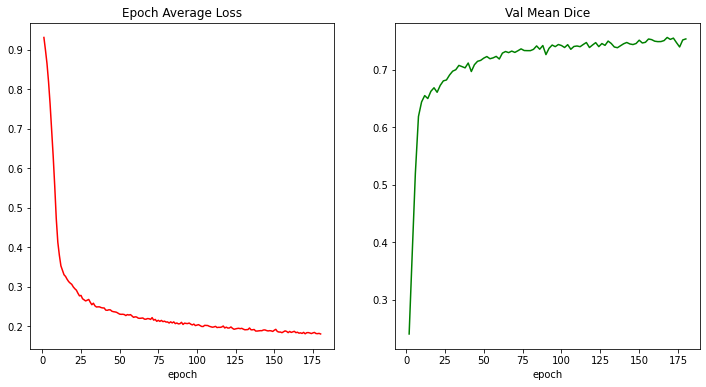

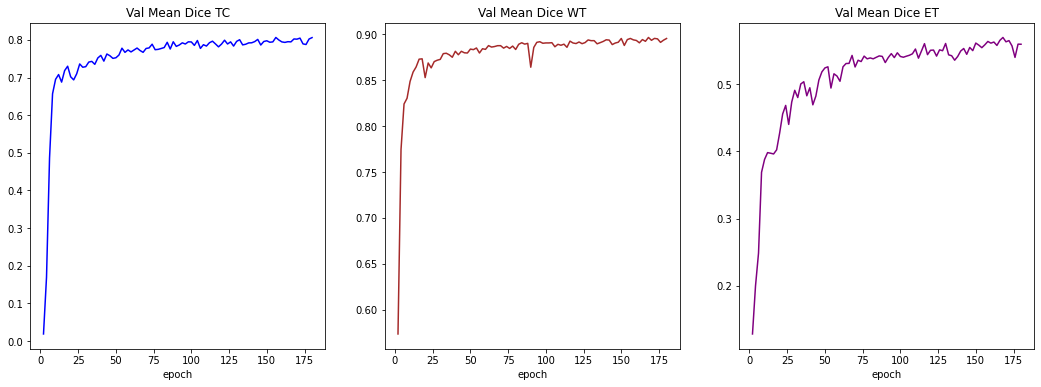

In [12]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

## Check best model output with the input image and label

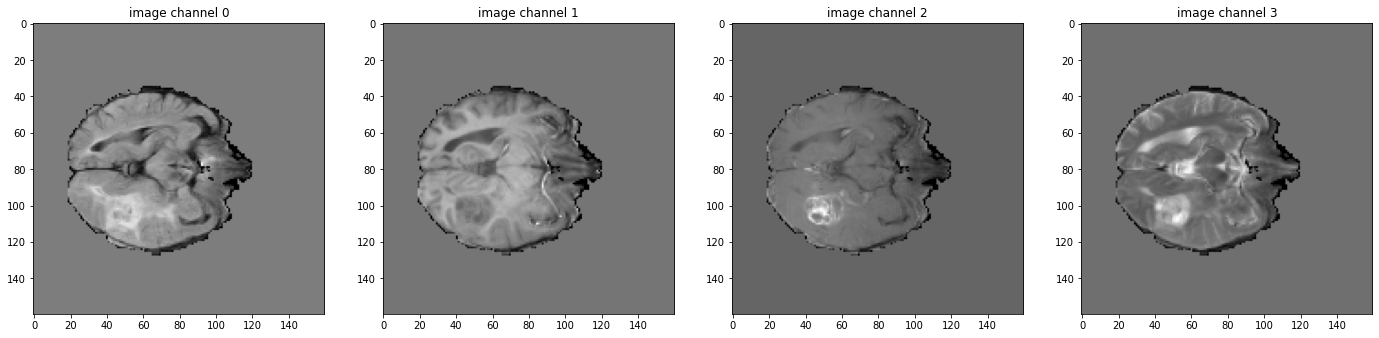

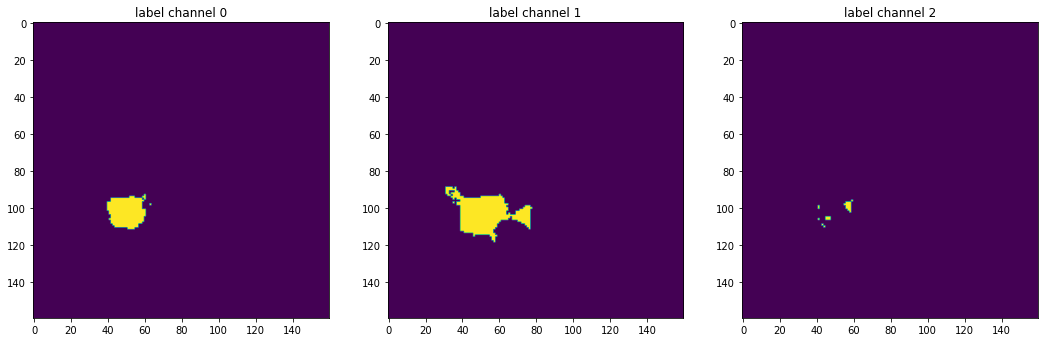

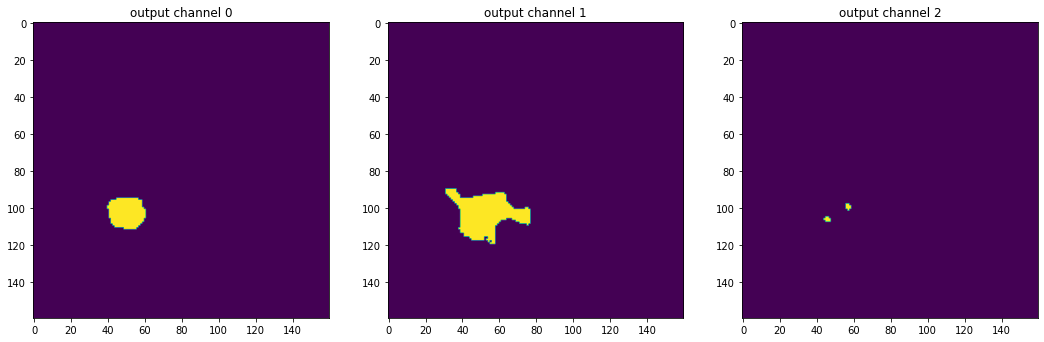

In [31]:
model.load_state_dict(
    torch.load(os.path.join(root_dir, "best_metric_model.pth"))
)
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[6]["image"].unsqueeze(0).to(device)
    val_outputs = sliding_window_inference(
        inputs=val_inputs, roi_size=(240, 240, 160), sw_batch_size=1, predictor=model, overlap=0.5
    )
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[6]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[6]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()

## Evaluation on original image spacings

In [ ]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
        Orientationd(keys=["image"], axcodes="RAS"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        EnsureTyped(keys=["image", "label"]),
    ]
)

val_org_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_org_transforms,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=0,
)
val_org_loader = DataLoader(val_org_ds, batch_size=1, shuffle=False, num_workers=4)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    Activationsd(keys="pred", sigmoid=True),
    AsDiscreted(keys="pred", threshold_values=True),
])

In [38]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        val_data["pred"] = sliding_window_inference(
            inputs=val_inputs, roi_size=(240, 240, 160), sw_batch_size=1, predictor=model, overlap=0.5
        )
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

    metric_org = dice_metric.aggregate().item()
    metric_batch_org = dice_metric_batch.aggregate()

    dice_metric.reset()
    dice_metric_batch.reset()

metric_tc, metric_wt, metric_et = metric_batch[0].item(), metric_batch[1].item(), metric_batch[2].item()

print("Metric on original image spacing: ", metric)
print(f"metric_tc: {metric_tc:.4f}")
print(f"metric_wt: {metric_wt:.4f}")
print(f"metric_et: {metric_et:.4f}")

Metric on original image spacing:  0.7536337971687317
metric_tc: 0.8062
metric_wt: 0.8956
metric_et: 0.5592


## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)